# ===   EDA. Predict rating hotels  ===

## Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import chi2, f_classif
import category_encoders as ce
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download necessary resources for sentiment analysis
#nltk.download('vader_lexicon')

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Load and Combine Train and Test Data

In [2]:
DATA_DIR = '/kaggle/input/sf-booking/'

df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv')
df_test = pd.read_csv(DATA_DIR + '/hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/submission.csv')

'''DATA_DIR = './sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн'''

"DATA_DIR = './sf-booking/'\ndf_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения\ndf_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания\nsample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн"

## Functions

In [3]:
#================= Function to calculate Cohen's d and check flag impact =============#
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2)/dof)
    return (x.mean() - y.mean()) / pooled_std

#================= Function to check impact of binary flags on reviewer scores =============#
def cohen_flag_check(df, flag_columns, score_col='reviewer_score'):

    sampled_hotels = df[df['sample'] == 1]  # only training data

    for flag in flag_columns:
        
        group1 = sampled_hotels[sampled_hotels[flag] == 1]['reviewer_score']
        group2 = sampled_hotels[sampled_hotels[flag] == 0]['reviewer_score']
        
        d = cohen_d(group1, group2)
        
        # Interpret effect size
        if abs(d) < 0.2:
            effect_desc = 'negligible'
        elif abs(d) < 0.5:
            effect_desc = 'small effect'
        elif abs(d) < 0.8:
            effect_desc = 'medium effect'
        else:
            effect_desc = 'large effect'
        
        print(f"Flag: {flag}")
        print(f"  Cohen's d: {d:.4f} ({effect_desc})\n")

# Initial Exploration & Cleaning

In [4]:
# Add sample flags
df_train['sample'] = 1  # training data
df_test['sample'] = 0   # test data
df_test['reviewer_score'] = 0  # placeholder for target

L0=len(df_train)
df_train.drop_duplicates(inplace=True)
L1=len(df_train)

print('Found and removed {} duplicates'.format(L0-L1))



# Combine train and test for consistent preprocessing
data = pd.concat([df_test, df_train], axis=0).reset_index(drop=True)

print(f"Combined dataset shape: {data.shape}")

Found and removed 307 duplicates
Combined dataset shape: (515431, 18)


In [5]:
# Create a copy for feature engineering
n_hotels = data.copy()

print("Number of unique hotels:", n_hotels['hotel_name'].nunique())

Number of unique hotels: 1492


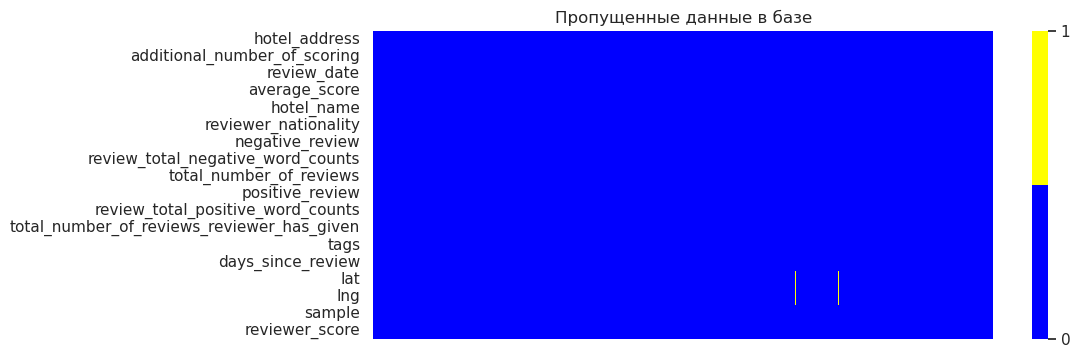

In [6]:
# Строим тепловую карту, где желтым отмечены пропущеные значения
cbar_kws = { 'ticks' : [0,1] }
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    n_hotels.T.isnull(), # Создаем карту пропущенных значений в базе данных
    cmap=sns.color_palette(colors),
    xticklabels=False,
    cbar_kws = cbar_kws
)
ax.set_title('Пропущенные данные в базе');

**Observation:** There missing lat lng for some positions in our data set

## Geographic coordinates. (Filling in the gaps, feature generation)

In [7]:
#n_hotels.info()

In [8]:
n_hotels[n_hotels['lat'].isnull()][['hotel_name', 'hotel_address']]


hotel_name  \
35                               Hotel Atlanta   
293                              Hotel Atlanta   
476                  City Hotel Deutschmeister   
526               Holiday Inn Paris Montmartre   
569        Fleming s Selection Hotel Wien City   
...                                        ...   
514720                      Hotel City Central   
515093                      Hotel City Central   
515132  Maison Albar Hotel Paris Op ra Diamond   
515330                      Hotel City Central   
515392                           Hotel Atlanta   

                                            hotel_address  
35      W hringer Stra e 33 35 09 Alsergrund 1090 Vien...  
293     W hringer Stra e 33 35 09 Alsergrund 1090 Vien...  
476     Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...  
526          23 Rue Damr mont 18th arr 75018 Paris France  
569     Josefst dter Stra e 10 12 08 Josefstadt 1080 V...  
...                                                   ...  
514720  Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...  
515093  Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...  
515132   4 rue de la P pini re 8th arr 75008 Paris France  
515330  Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...  
515392  W hringer Stra e 33 35 09 Alsergrund 1090 Vien...  

[3268 rows x 2 columns]

In [9]:
saved_coords = {
  "W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria": [
    48.225073,
    16.3583976
  ],
  "Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria": [
    48.225073,
    16.3583976
  ],
  "23 Rue Damr mont 18th arr 75018 Paris France": [
    48.8916223,
    2.3479768
  ],
  "Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria": [
    48.2108819,
    16.3473687
  ],
  "Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria": [
    48.2006384,
    16.4268953
  ],
  "Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria": [
    48.2108819,
    16.3473687
  ],
  "Bail n 4 6 Eixample 08010 Barcelona Spain": [
    41.3916498,
    2.1747892
  ],
  "Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria": [
    48.1936436,
    16.3962862
  ],
  "4 rue de la P pini re 8th arr 75008 Paris France": [
    48.8733792,
    2.3111527
  ],
  "20 Rue De La Ga t 14th arr 75014 Paris France": [
    48.8295667,
    2.3239625
  ],
  "W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria": [
    48.225073,
    16.3583976
  ],
  "Savoyenstra e 2 16 Ottakring 1160 Vienna Austria": [
    48.2149546,
    16.3021535
  ],
  "Pau Clar s 122 Eixample 08009 Barcelona Spain": [
    41.3948689,
    2.1691918
  ],
  "Sieveringer Stra e 4 19 D bling 1190 Vienna Austria": [
    48.2612506,
    16.328471
  ],
  "Paragonstra e 1 11 Simmering 1110 Vienna Austria": [
    48.1631087,
    16.4580128
  ],
  "Hasenauerstra e 12 19 D bling 1190 Vienna Austria": [
    48.2612506,
    16.328471
  ],
  "Sep lveda 180 Eixample 08011 Barcelona Spain": [
    41.384655,
    2.1593013
  ]
}

In [10]:
# Load the saved dictionary
import json

#with open("coords_dict.json", "r", encoding="utf-8") as f:
#    saved_coords = json.load(f)

# Map to DataFrame again
coords = n_hotels['hotel_address'].map(saved_coords)

# Fill missing lat/lng using saved values
# --- 3. Extract lat/lng safely from the mapped list ---
coords_lat = coords.apply(lambda x: float(x[0]) if isinstance(x, (list, tuple)) and len(x) == 2 else np.nan)
coords_lng = coords.apply(lambda x: float(x[1]) if isinstance(x, (list, tuple)) and len(x) == 2 else np.nan)

# --- 4. Fill ONLY missing lat/lng values ---
n_hotels['lat'] = n_hotels['lat'].fillna(coords_lat)
n_hotels['lng'] = n_hotels['lng'].fillna(coords_lng)


## Review analysis

In [11]:

# ============================================
# SENTIMENT ENCODING OF REVIEWS
# ============================================

import re
import unicodedata
from functools import lru_cache
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon (run once)
nltk.download('vader_lexicon')

# Initialize analyzer
sent_analyzer = SentimentIntensityAnalyzer()


# -------------------------------------------------------
# Shared text preprocessing
# -------------------------------------------------------

PUNCT_STRIP_REGEX = re.compile(r"[!.,;:?]+$")

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = unicodedata.normalize("NFKD", text)
    text = text.lower()
    text = text.strip()               # remove leading/trailing spaces
    text = text.replace("\xa0", " ")  # replace non-breaking space
    text = re.sub(r"\s+", " ", text)  # collapse multiple spaces
    return PUNCT_STRIP_REGEX.sub("", text)


EMPTY_REVIEW_REGEX = re.compile(
    r"""
    ^\s*(
        (?:none|nil|n/?a|n\.a\.?|na|n\s+a|nothing)             # none, nil, n/a, n.a.
        |
        (nothing(?:\s+\w+){0,3}?)
        |
        (no\s+(?:comments?|words?|negative?|positive?)(?:\s+\w+){0,3}?)
        |
        not\s+one\s+thing                                    # sometimes reviewers just write "empty"
    )\s*$""",
    re.IGNORECASE | re.VERBOSE
)


def count_words(text):
    if pd.isna(text):
        return 0    
    t = str(text).strip()
    # If review is empty placeholder → return 0 words
    if EMPTY_REVIEW_REGEX.fullmatch(t):
        return 0
    # Otherwise count words
    return len(t.split())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
nan_cols = n_hotels.isnull().any()
print(n_hotels.columns[nan_cols].tolist())

[]


In [13]:
n_hotels[['review_total_negative_word_counts','review_total_positive_word_counts']].describe()


review_total_negative_word_counts  review_total_positive_word_counts
count                      515431.000000                      515431.000000
mean                           18.539760                          17.777342
std                            29.690973                          21.803204
min                             0.000000                           0.000000
25%                             2.000000                           5.000000
50%                             9.000000                          11.000000
75%                            23.000000                          22.000000
max                           408.000000                         395.000000

In [14]:

n_hotels['positive_review'] = n_hotels['positive_review'].apply(clean_text)
n_hotels['negative_review'] = n_hotels['negative_review'].apply(clean_text)


n_hotels['review_total_negative_word_counts'] = ( n_hotels['negative_review'].apply(count_words) )
n_hotels['review_total_positive_word_counts'] = ( n_hotels['positive_review'].apply(count_words) )

n_hotels["neg_word_count_log"] = np.log1p(n_hotels["review_total_negative_word_counts"])
n_hotels["pos_word_count_log"] = np.log1p(n_hotels["review_total_positive_word_counts"])


n_hotels['empty_positive_flag'] = (n_hotels['review_total_positive_word_counts'] == 0).astype(int)
n_hotels['empty_negative_flag'] = (n_hotels['review_total_negative_word_counts'] == 0).astype(int)

bins = [-1, 20, 55, np.inf]
labels = [ 1, 10, 100]

n_hotels["pos_word_count_bin"] = pd.cut( n_hotels["review_total_positive_word_counts"], bins=bins, labels=labels ).astype(int)
n_hotels["neg_word_count_bin"] = pd.cut( n_hotels["review_total_negative_word_counts"], bins=bins, labels=labels ).astype(int)

n_hotels["pos_word_count_bin2"] = n_hotels["pos_word_count_bin"] / ( n_hotels["pos_word_count_bin"] + n_hotels["neg_word_count_bin"]  )
n_hotels["neg_word_count_bin2"] = n_hotels["neg_word_count_bin"] / ( n_hotels["pos_word_count_bin"] + n_hotels["neg_word_count_bin"]  )


In [15]:
from collections import Counter


# Convert to a DataFrame for easier viewing
for col in ['positive_review','negative_review']:
    reviews = ( n_hotels[col] )    
    # Count occurrences
    review_counts = Counter(reviews)
    popular_reviews = (
        pd.DataFrame(review_counts.items(), columns=[col, 'count'])
        .sort_values('count', ascending=False)
        .reset_index(drop=True)
    )
    
    # Display top 10 most common positive reviews
    print("Top " + col + ":")
    display(popular_reviews.head(15))

Top positive_review:


positive_review  count
0                  no positive  35924
1                     location  11933
2                   everything   3314
3                      nothing   1729
4               great location   1685
5                 the location   1604
6                good location   1495
7                    breakfast    795
8               friendly staff    732
9           excellent location    639
10                       staff    553
11          location and staff    452
12              location staff    432
13  location location location    345
14          location was great    328

Top negative_review:


negative_review   count
0          no negative  127816
1              nothing   21177
2                  n a    1815
3                 none    1501
4                          849
5       nothing really     655
6           small room     570
7            breakfast     545
8             all good     544
9        no complaints     523
10            location     501
11      nothing at all     466
12          everything     419
13  nothing to dislike     373
14               price     348

In [16]:

# -------------------------------------------------------
# Regex Patterns (simplified & faster)
# -------------------------------------------------------



NOTHING_BAD_REGEX = re.compile(
    r"""
    ^\s*(
        nothing\s+(bad|to\s+complain\s+about|negative?|really|at\s+all|to\s+dislike)
        |
        no\s+(problem?|issue?|complaint?|fault?|negative?)
        |
        can(?:'|’)t\s+think\s+of\s+anything\s+bad
        |
        not\s+a\s+single\s+problem
        |
        not\s+one\s+thing	
        |
        no\s+complaint?\s+at\s+all
    )\s*$""",
    re.IGNORECASE | re.VERBOSE
)

NOTHING_GOOD_REGEX = re.compile(
    r"""
    ^\s*(
        nothing\s+was\s+(good|positive|working)
        |
        nothing\s+(good|positive|work?)
        |
        no\s+(positive?|good\s+things?)
        |
        can(?:'|’)t\s+think\s+of\s+anything\s+good
        |
        nothing\s+at\s+all\s+was\s+good
        |
        not\s+a\s+single\s+good\s+thing
    )\s*$""",
    re.IGNORECASE | re.VERBOSE
)


EVERYTHING_REGEX = re.compile(
    #r"""^\s*(everything(?:\s+\w+){0,3}?)\s*$""",
    r"""^\s*(everything|all)\s*$""",
    re.IGNORECASE | re.VERBOSE
)

EVERYTHING_GOOD_REGEX = re.compile(
    r"""
    ^\s*(
        everything\s+(?:was\s+)?(?:good|fine|perfect|great|excellent|amazing|awesome|nice|ok|okay)
        |
        all(?:\s+(?:was|is))?\s*(?:good|fine|perfect|great|excellent|amazing|awesome|nice|ok|okay)
        |
        excellent|perfect|great|awesome|amazing|fantastic|wonderful|outstanding|superb|incredible|exceptional|marvelous|fabulous|phenomenal
    )\s*$""",
    re.IGNORECASE | re.VERBOSE
)

EVERYTHING_BAD_REGEX = re.compile(
    r"""
    ^\s*(
        everything\s+(?:was\s+)?(?:bad|terrible|awful|horrible|poor|sucks|worst)
        |
        all(?:\s+(?:was|is))?\s*(?:bad|terrible|awful|horrible|poor|sucks|worst)
        |
        bad|terrible|awful|horrible|poor|sucks|worst|dreadful|abysmal|subpar|lousy|disappointing|disappointed|unacceptable|unpleasant|nightmare|struggle|disgusting|terrible
        |
        bad\s+experience|not\s+good|not\s+great|not\s+ worth|never\s+again|not\s+recommend|not\s+recommended
        |
        don\s+t\s+like
    )\s*$""",
    re.IGNORECASE | re.VERBOSE
)


# -------------------------------------------------------
# Flag functions
# -------------------------------------------------------

def everything_flag(text):
    t = clean_text(text)
    if NOTHING_BAD_REGEX.match(t):
        return 1
    if NOTHING_GOOD_REGEX.match(t):
        return -1
    if EVERYTHING_GOOD_REGEX.search(t):
        return 1
    if EVERYTHING_BAD_REGEX.search(t):
        return -1
    return 0


def absolute_flag(text):
    t = clean_text(text)
    if EVERYTHING_REGEX.search(t):
        return 1
    #if NOTHING_REGEX.match(t):
    #    return -1
    return 0


def is_empty_review(text):
    text = clean_text(text)
    if pd.isna(text):
        return 1
    text = str(text).strip()
    return int(text == "" or bool(EMPTY_REVIEW_REGEX.match(text)))


@lru_cache(maxsize=300_000)
def cached_vader_sentiment(text):
    return sent_analyzer.polarity_scores(text)['compound']

def get_compound_score(text):
    cleaned = clean_text(text)
    return cached_vader_sentiment(cleaned)



In [17]:
###   1. Empty review flag.
n_hotels["p_empty_flag"] = n_hotels["positive_review"].apply(is_empty_review)
n_hotels["n_empty_flag"] = n_hotels["negative_review"].apply(is_empty_review)

n_hotels["both_empty_flag"] = ( n_hotels["p_empty_flag"] & n_hotels["n_empty_flag"] )

# Masks for non-empty reviews
mask_pos = n_hotels["p_empty_flag"] == False
mask_neg = n_hotels["n_empty_flag"] == False


###   2. Absolute flag creation. Apply only to non-empty reviews
n_hotels["p_absolute_flag"] = 0
n_hotels["n_absolute_flag"] = 0

n_hotels.loc[mask_pos, "p_absolute_flag"] = (
    n_hotels.loc[mask_pos, "positive_review"].apply(absolute_flag)
)

n_hotels.loc[mask_neg, "n_absolute_flag"] = (
    -n_hotels.loc[mask_neg, "negative_review"].apply(absolute_flag)
)

###   3. Everything flag creation
n_hotels["p_everything_flag"] = n_hotels["p_absolute_flag"]
n_hotels["n_everything_flag"] = n_hotels["n_absolute_flag"]

mask = (n_hotels["p_absolute_flag"] == 0) & (n_hotels["p_empty_flag"] == 0)
n_hotels.loc[mask, "p_everything_flag"] = (
        n_hotels.loc[mask, "positive_review"].apply( everything_flag )
)
mask = (n_hotels["n_absolute_flag"] == 0) & (n_hotels["n_empty_flag"] == 0)
n_hotels.loc[mask, "n_everything_flag"] = (
        n_hotels.loc[mask, "negative_review"].apply( everything_flag )
)

###   3. Score calculation. 
n_hotels["positive_score"] = n_hotels["p_everything_flag"]
n_hotels["negative_score"] = n_hotels["n_everything_flag"]

mask_p = (n_hotels["p_everything_flag"] == 0) & (n_hotels["p_empty_flag"] == 0)
n_hotels.loc[mask_p, "positive_score"] = (
        n_hotels.loc[mask_p, "positive_review"].apply( get_compound_score )
)
mask_n = (n_hotels["n_everything_flag"] == 0) & (n_hotels["n_empty_flag"] == 0)
n_hotels.loc[mask_n, "negative_score"] = (
        n_hotels.loc[mask_n, "negative_review"].apply( get_compound_score )
)


In [18]:
n_hotels[["positive_review","negative_review",'p_empty_flag', 'n_empty_flag', 'p_absolute_flag','p_everything_flag', 'n_absolute_flag','n_everything_flag', 'positive_score', 'negative_score']].sample(10)

positive_review  \
346271              amazing room we had the deluxe double   
55683   everything was superb excellent breakfast good...   
504871  overall good stay a experience you would expec...   
58034                                     rooms and staff   
97892   room was excellent staff excellent extremely p...   
197271  location good just opposite camden markets and...   
472540            pleasant environment busy but efficient   
493460  very comfy beds and good gym we were on top fl...   
167787  everything was better than we could have imagi...   
62522   the bed was very comfortable bathroom modern a...   

                                          negative_review  p_empty_flag  \
346271                                        no negative             0   
55683   no restaurant for evening meal hard to find if...             0   
504871                                        no negative             0   
58034                                             nothing             0   
97892   staff coming into the room while we were in th...             0   
197271  while location was good its actual positioning...             0   
472540  some of the breakfast was not as hot as it cou...             0   
493460  not the friendliest of desk staff when we book...             0   
167787                                        no negative             0   
62522                                         no negative             0   

        n_empty_flag  p_absolute_flag  p_everything_flag  n_absolute_flag  \
346271             1                0                  0                0   
55683              0                0                  0                0   
504871             1                0                  0                0   
58034              1                0                  0                0   
97892              0                0                  0                0   
197271             0                0                  0                0   
472540             0                0                  0                0   
493460             0                0                  0                0   
167787             1                0                  0                0   
62522              1                0                  0                0   

        n_everything_flag  positive_score  negative_score  
346271                  0          0.5859          0.0000  
55683                   0          0.9371         -0.3818  
504871                  0          0.4404          0.0000  
58034                   0          0.0000          0.0000  
97892                   0          0.8876         -0.2263  
197271                  0          0.8316         -0.9174  
472540                  0          0.7050          0.4215  
493460                  0          0.9233          0.2323  
167787                  0          0.9826          0.0000  
62522                   0          0.7425          0.0000

In [19]:

#n_hotels['no_positive_flag'] =  (mask_no_positive).astype(int)
#n_hotels.loc[mask_no_positive, 'positive_score'] = -0.5
#n_hotels['no_negative_flag'] =  (mask_no_negative).astype(int)
#n_hotels.loc[mask_no_negative, 'negative_score'] = 0.5


#n_hotels[["positive_review","negative_review","empty_positive_review","empty_negative_review","empty_both_reviews"]].sample(20)

n_hotels['tot_score']   = n_hotels['positive_score'] + n_hotels['negative_score']


n_hotels['positive_score_e'] = np.exp( n_hotels['positive_score'] )
n_hotels['negative_score_e'] = np.exp( - n_hotels['negative_score'] )


n_hotels['satisfaction_flag'] = np.sign( n_hotels['positive_score_e'] - n_hotels['negative_score_e'] )


n_hotels['positive_word_%'] = ( 
    n_hotels['review_total_positive_word_counts'] / (n_hotels['review_total_positive_word_counts'] + n_hotels['review_total_negative_word_counts'] + 1 )
    )
n_hotels['negative_word_%'] = ( 
    n_hotels['review_total_negative_word_counts'] / (n_hotels['review_total_positive_word_counts'] + n_hotels['review_total_negative_word_counts'] + 1 )
    )


n_hotels['pos_vs_neg'] = ( 
    n_hotels['positive_score_e']*n_hotels['positive_word_%'] - n_hotels['negative_score_e'] *n_hotels['negative_word_%']
    )


n_hotels['pos_vs_neg2'] = ( 
    n_hotels['positive_score_e']*n_hotels['positive_word_%'] - n_hotels['negative_score_e'] *n_hotels['negative_word_%'] +
    100 * ( np.exp(n_hotels['p_everything_flag']) - np.exp(-n_hotels['n_everything_flag']) )
    ) 


In [20]:
sampled_hotels = n_hotels[n_hotels['sample']==1].copy()
cohen_flag_check(sampled_hotels,flag_columns=['satisfaction_flag','p_empty_flag', 'n_empty_flag', 'p_absolute_flag','p_everything_flag', 'n_absolute_flag','n_everything_flag'])

Flag: satisfaction_flag
  Cohen's d: 0.4577 (small effect)

Flag: p_empty_flag
  Cohen's d: -1.1620 (large effect)

Flag: n_empty_flag
  Cohen's d: 0.9542 (large effect)

Flag: p_absolute_flag
  Cohen's d: 0.8001 (large effect)

Flag: p_everything_flag
  Cohen's d: 0.7788 (medium effect)

Flag: n_absolute_flag
  Cohen's d: nan (large effect)

Flag: n_everything_flag
  Cohen's d: 0.6925 (medium effect)



In [21]:
n_hotels['satisfaction_flag1'] = np.sign( n_hotels['pos_vs_neg'] )
n_hotels['satisfaction_flag2'] = np.sign( n_hotels['pos_vs_neg2'] )
n_hotels['satisfaction_flag3'] = np.sign( n_hotels['tot_score'] )
sampled_hotels = n_hotels[n_hotels['sample']==1].copy()

cohen_flag_check(sampled_hotels,flag_columns=['satisfaction_flag1','satisfaction_flag2','satisfaction_flag3'])


Flag: satisfaction_flag1
  Cohen's d: 1.1129 (large effect)

Flag: satisfaction_flag2
  Cohen's d: 1.1198 (large effect)

Flag: satisfaction_flag3
  Cohen's d: 0.4577 (small effect)



In [22]:
n_hotels[ (n_hotels['reviewer_score']<4) & (n_hotels['sample']==1) & (n_hotels['tot_score'] > 0) ][['positive_review', 'negative_review', 'reviewer_score', "p_empty_flag","n_empty_flag","both_empty_flag", 'positive_score','negative_score','tot_score']].sample(20)


positive_review  \
298058                                          free wifi   
324065  everything very comfortable warm and extremely...   
319090  besides the location with its close proximity ...   
144044                           breakfast buffet is good   
257415                                        no positive   
396429                                        no positive   
437777  this is the baddest hotel i can t believe this...   
264097                                           location   
204187              bed was comfortable linen was average   
351373                                           location   
128968  location was very good to commute within canar...   
297219                                        no positive   
171767                                        no positive   
299753                    location services s pretty good   
318703  on arrival the room was clean however i had ca...   
493475                               rather fair location   
136910                                        no positive   
371420  location only they have nothing but location t...   
293048                                        no positive   
488054              shower was lovely and room was modern   

                                          negative_review  reviewer_score  \
298058                                      the room size             3.8   
324065  the lack of wifi in our room also please be aw...             2.5   
319090  room was cold with heating on one water bottle...             3.8   
144044  hotel under staff hotel and all facilities are...             3.8   
257415  i was very un happy with the stay as we gilt m...             2.5   
396429  i didn t like it at all very small rooms very ...             3.3   
437777  this is the baddest hotel i can t believe this...             2.5   
264097  the rooms weren t what we expected they re too...             3.3   
204187  the first room i was checked into room 7 has a...             3.3   
351373  small rooms smelly corridors no soundproof fak...             3.3   
128968  personnel was very rude housekeeping staff don...             3.3   
297219  so much dust old structure value for money not...             3.3   
171767  corridors are awful the beds were very very sm...             3.8   
299753  the hotel is very dated it looks like it has n...             3.3   
318703  booked the junior suite and was expecting a se...             3.8   
493475  on arrival staff asked how i booked the room a...             3.3   
136910  first of all i want to start with saying that ...             3.8   
371420  customer service is non existent you know what...             3.8   
293048  specifically requested a double bed only to fi...             3.8   
488054  unclean failure to inform of charge for valet ...             3.3   

        p_empty_flag  n_empty_flag  both_empty_flag  positive_score  \
298058             0             0                0          0.5106   
324065             0             0                0          0.7630   
319090             0             0                0          0.6486   
144044             0             0                0          0.4404   
257415             1             0                0          0.0000   
396429             1             0                0          0.0000   
437777             0             0                0          0.2732   
264097             0             0                0          0.0000   
204187             0             0                0          0.5106   
351373             0             0                0          0.0000   
128968             0             0                0          0.4927   
297219             1             0                0          0.0000   
171767             1             0                0          0.0000   
299753             0             0                0          0.7269   
318703             0             0                0          0.0776   
493475

In [23]:
#n_hotels[ (n_hotels['reviewer_score']==10) & (n_hotels['positive_review']=='no positive') ][['positive_review', 'negative_review', 'reviewer_score', "empty_positive_review","empty_negative_review","mobile_flag", 'positive_score','negative_score']].sample(20)


In [24]:
n_hotels[ ( (n_hotels['sample'] == 1) & (n_hotels['pos_vs_neg2'] > 0) & (n_hotels['reviewer_score'] <4) )][['positive_review', 'negative_review', 'reviewer_score','positive_score','negative_score','tot_score','pos_vs_neg','pos_vs_neg2']].shape

(807, 8)

In [25]:
n_hotels['positive_review'].iloc[216551]

'we got a smoking room even so we asked for a nonesmoking room the housekeeping did not come the whole day our bed was not made at 6 pm the carpet is old and we did nod like to wale around withour shoes breakfast coasts 32 pounds per person i asked to organize us tickets for a concert the prize was more than double of the original prize'

### Removing confusing reviews

In [26]:
nn_hotels = n_hotels.copy()

In [27]:
sampled_hotels = nn_hotels[nn_hotels['sample']==1].copy()
sampled_hotels['reviewer_score'].describe()

count    386496.000000
mean          8.397299
std           1.635747
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: reviewer_score, dtype: float64

In [28]:
main_feature = 'pos_vs_neg'

mask_to_remove = (
    ((n_hotels[main_feature] < 0) & (n_hotels['reviewer_score'] >= 8)) |
    ((n_hotels[main_feature] > 0) & (n_hotels['reviewer_score'] <= 5) & (n_hotels['sample'] == 1))
)

#print("Rows removed:", len(mask_to_remove))
print("Rows removed:", n_hotels[mask_to_remove].shape[0] )
#display(n_hotels[mask_to_remove].sample(7))

# Filter out unwanted rows
to_remove = n_hotels[mask_to_remove]
n_hotels = n_hotels[~mask_to_remove]

    
n_hotels = n_hotels[
    ~(
        (n_hotels['positive_review'] == "no positive") &
        (n_hotels['negative_review'] == "no negative") &
        (n_hotels['sample'] == 1)
    )
]


print("Rows remained:", n_hotels.shape[0] )

#to_remove.sample(20)

Rows removed: 44867
Rows remained: 470470


In [29]:
to_remove[['positive_review','negative_review','reviewer_score', 'positive_score','negative_score','tot_score']].sample(20)

positive_review  \
355121                       central location was perfect   
406766                           the staff very efficient   
482517                    lovely meal in hotel restaurant   
351501  great location very friendly staff who were ve...   
363723        the location and the friendly helpful staff   
386316                                        no positive   
172867                                        no positive   
274410                                 fantastic location   
340385                                        no positive   
254875  the hotel is very modern clean and attractive ...   
468565                             amazing trip to london   
350620                                        no positive   
359239                                    great breakfast   
423789                 nice variety and excellent service   
384454  it is a fantastic location for seeing everythi...   
259513                           excellent friendly staff   
193932  the location is wonderful equal distance from ...   
260548                           great location and staff   
195328                           wifi location front desk   
148894    roof top pool was great for a day of relaxation   

                                          negative_review  reviewer_score  \
355121  got an up grade when we didn t need it as it w...             8.8   
406766  main shower tap brocken lack of lighting by co...             9.6   
482517  music in lounge bar area could send you off to...            10.0   
351501  no shower bath gel in bathroom so you have to ...            10.0   
363723  the never ending family parked in the pool has...            10.0   
386316                the room was very small but compact             9.6   
172867                                         hotel food             9.2   
274410  air con units outside were running all night b...             8.8   
340385  i requested a restaurant reservation by webval...             9.6   
254875  the bathroom had a deep tub which is difficult...             9.6   
468565  check in as it was brought as a birthday prese...             8.3   
350620                            breakfast too expensive             9.2   
359239                             expensive 3pm check in             9.2   
423789  restaurant in 7th floor by pool need more vari...             9.2   
384454  they have move the bar around and it has lost ...             9.2   
259513    bath drain too slowly and soap basket was loose             9.2   
193932  i thought the room was quite small for a coupl...            10.0   
260548  no complementry wi fi for all guests in this d...             8.8   
195328                         no real window at the room             8.8   
148894  it s quite far from the centre not far from th...             8.3   

        positive_score  negative_score  tot_score  
355121          0.5719          0.0000     0.5719  
406766          0.4754         -0.3182     0.1572  
482517          0.5859          0.0000     0.5859  
351501          0.9447         -0.5423     0.4024  
363723          0.7184          0.0000     0.7184  
386316          0.0000          0.0000     0.0000  
172867          0.0000          0.0000     0.0000  
274410          0.5574          0.0000     0.5574  
340385          0.0000         -0.4215    -0.4215  
254875          0.9038         -0.6310     0.2728  
468565          0.5859          0.3182     0.9041  
350620          0.0000          0.0000     0.0000  
359239          0.6249          0.0000     0.6249  
423789          0.7579         -0.5875     0.1704  
384454          0.5574         -0.3182     0.2392  
259513          0.7845         -0.3182     0.4663  
193932          0.8885         -0.0479     0.8406  
260548          0.6249         -0.5106     0.1143  
195328          0.0000         -0.2960    -0.2960  
148894          0.8519          0.0000     0.8519

In [30]:
#n_hotels[['pos_vs_neg','positive_score_e','negative_score_e','positive_word_%','negative_word_%','positive_score','negative_score','tot_score']].iloc[180167]

## Hotel location

In [31]:
#==================
#  Hotel Country
#==================

# Extract last word of address as hotel_country
#n_hotels['hotel_country'] = n_hotels['hotel_address'].apply(lambda x: str(x).split()[-1])

known_countries = ['United Kingdom', 'Spain', 'France', 'Netherlands', 'Austria', 'Italy']

def extract_hotel_country(address):
    for country in known_countries:
        if country.lower() in address.lower():
            return country
    return 'Unknown'

n_hotels['hotel_country'] = n_hotels['hotel_address'].apply(extract_hotel_country)

In [32]:
country_dummies = pd.get_dummies(
    n_hotels['hotel_country'],
    prefix='country',
    dtype='uint8'
)

n_hotels = pd.concat([n_hotels, country_dummies], axis=1)

In [33]:
#==================
#  Hotel City
#==================

from geopy.distance import geodesic

city_centers = {
    'London': (51.509865, -0.118092),
    'Barcelona': (41.3851, 2.1734),
    'Paris': (48.8566, 2.3522),
    'Amsterdam': (52.3676, 4.9041),
    'Vienna': (48.2082, 16.3738),
    'Milan': (45.4642, 9.19)
}


def compute_distance(row):
    city = row['hotel_city']
    if city == 'Unknown' or pd.isna(row['lat']) or pd.isna(row['lng']):
        return np.nan
    center_coords = city_centers.get(city)
    hotel_coords = (row['lat'], row['lng'])
    return geodesic(hotel_coords, center_coords).km


def extract_city(address):
    """Extract city name from address (based on known city list)."""
    for city in city_centers.keys():
        if city.lower() in address.lower():
            return city
    return 'Unknown'

# Create hotel_city
n_hotels['hotel_city'] = n_hotels['hotel_address'].apply(extract_city)
n_hotels['distance_from_city_center'] = n_hotels.apply(compute_distance, axis=1)


In [34]:
from geopy.distance import geodesic
import numpy as np
import pandas as pd

# Extended landmarks for each city
city_landmarks = {
    'London': {
        'Big Ben': (51.5007, -0.1246),
        'Buckingham Palace': (51.5014, -0.1419),
        'Tower of London': (51.5081, -0.0759),
        'London Eye': (51.5033, -0.1196),
        'British Museum': (51.5194, -0.1270),
        'Hyde Park': (51.507268, -0.165730)
    },
    'Barcelona': {
        'Sagrada Familia': (41.4036, 2.1744),
        'Park Güell': (41.4145, 2.1527),
        'La Rambla': (41.3809, 2.1730),
        'Casa Batlló': (41.3917, 2.1649),
        'Camp Nou': (41.3809, 2.1228),
        'Montjuïc': (41.3636, 2.1580)
    },
    'Paris': {
        'Eiffel Tower': (48.8584, 2.2945),
        'Louvre Museum': (48.8606, 2.3376),
        'Notre Dame': (48.852968, 2.349902),
        'Sacré-Cœur': (48.8867, 2.3431),
        'Arc de Triomphe': (48.8738, 2.2950),
        'Palace of Versailles': (48.8049, 2.1204)
    },
    'Amsterdam': {
        'Dam Square': (52.3731, 4.8922),
        'Rijksmuseum': (52.359997, 4.885219),
        'Anne Frank House': (52.375218, 4.883977),
        'Van Gogh Museum': (52.3584, 4.8811),
        'Vondelpark': (52.3570, 4.8686),
        'Heineken Experience': (52.3578, 4.8910)
    },
    'Vienna': {
        'St. Stephen’s Cathedral': (48.2082, 16.3738),
        'Schönbrunn Palace': (48.1845, 16.3122),
        'Belvedere Palace': (48.1913, 16.3805),
        'Hofburg Palace': (48.2065, 16.3653),
        'Vienna State Opera': (48.2020, 16.3685),
        'Prater': (48.2169, 16.4001)
    },
    'Milan': {
        'Duomo di Milano': (45.4642, 9.19),
        'Sforza Castle': (45.4704, 9.1799),
        'Galleria Vittorio Emanuele II': (45.4658, 9.189),
        'Teatro alla Scala': (45.4678, 9.1898),
        'Santa Maria delle Grazie': (45.4659, 9.1702),
        'Navigli District': (45.4506, 9.1706)
    }
}



# 2. Function to compute closest landmark distance
def compute_closest_landmark_distance(row):
    city = row['hotel_city']
    hotel_coords = (row['lat'], row['lng'])

    # Missing or unknown
    if city not in city_landmarks or pd.isna(row['lat']) or pd.isna(row['lng']):
        return np.nan

    distances = []
    for landmark, coords in city_landmarks[city].items():
        dist = geodesic(hotel_coords, coords).km
        distances.append(dist)

    return min(distances) if distances else np.nan


# 3. Apply to dataframe
n_hotels['distance_to_closest_landmark'] = n_hotels.apply(
    compute_closest_landmark_distance, axis=1
)


In [35]:
# Unpopular / less visited areas for each city
city_landmarks = {
    'London': {
        'Barking': (51.5390, 0.0810),
        'Dagenham': (51.5470, 0.1650),
        'Enfield': (51.6530, -0.0810),
        'Croydon Outskirts': (51.3537, -0.1130),
        'Hounslow': (51.4730, -0.3610),
        'Walthamstow': (51.5833, -0.0167)
    },
    'Barcelona': {
        'Nou Barris': (41.4510, 2.1830),
        'Sant Andreu': (41.4382, 2.1900),
        'Sants-Montjuïc outskirts': (41.3710, 2.1410),
        'La Bordeta': (41.3690, 2.1300),
        'El Carmel': (41.4230, 2.1750),
        'Vallbona': (41.4510, 2.2100)
    },
    'Paris': {
        'La Villette': (48.8890, 2.3870),
        'Montreuil': (48.8610, 2.4360),
        'Saint-Denis outskirts': (48.9360, 2.3570),
        'Pantin': (48.8920, 2.4090),
        'Ivry-sur-Seine': (48.8130, 2.3840),
        'Bobigny': (48.9050, 2.4500)
    },
    'Amsterdam': {
        'Amsterdam-Noord residential': (52.3980, 4.9310),
        'Sloterdijk industrial': (52.3890, 4.8370),
        'Osdorp': (52.3500, 4.8200),
        'Geuzenveld': (52.3470, 4.8100),
        'Bijlmermeer outskirts': (52.3250, 4.9500),
        'Zuidoost': (52.3200, 4.9600)
    },
    'Vienna': {
        'Simmering': (48.1770, 16.4500),
        'Favoriten outskirts': (48.1775, 16.4000),
        'Liesing': (48.1330, 16.3000),
        'Floridsdorf outskirts': (48.2400, 16.4200),
        'Donaustadt residential': (48.2600, 16.4500),
        'Brigittenau': (48.2230, 16.3660)
    },
    'Milan': {
        'Quarto Oggiaro': (45.5140, 9.1230),
        'Baggio': (45.4570, 9.1250),
        'Niguarda outskirts': (45.5160, 9.2000),
        'Gratosoglio': (45.4320, 9.1750),
        'Lorenteggio': (45.4500, 9.1550),
        'Precotto': (45.5020, 9.2100)
    }
}

'''# 2. Function to compute closest landmark distance
def compute_closest_landmark_distance(row):
    city = row['hotel_city']
    hotel_coords = (row['lat'], row['lng'])

    # Missing or unknown
    if city not in city_landmarks or pd.isna(row['lat']) or pd.isna(row['lng']):
        return np.nan

    distances = []
    for landmark, coords in city_landmarks[city].items():
        dist = geodesic(hotel_coords, coords).km
        distances.append(dist)

    return min(distances) if distances else np.nan

'''

# 3. Apply to dataframe
n_hotels['distance_to_bad_landmark'] = n_hotels.apply(
    compute_closest_landmark_distance, axis=1
)

In [36]:
#n_hotels['distance_check'] = n_hotels['distance_to_closest_landmark'] - n_hotels['distance_to_bad_landmark'] 

/tmp/ipykernel_21/3753105372.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_hotels['distance_bin'] = pd.cut(sampled_hotels['distance_to_closest_landmark'], bins=9)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_21/3753105372.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


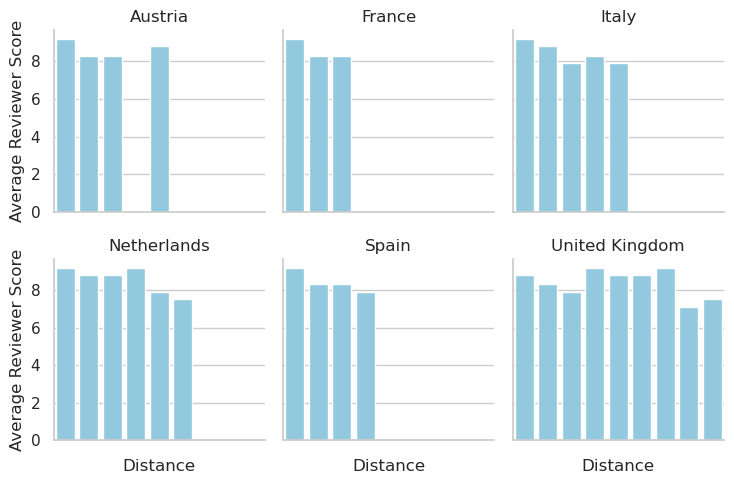

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sampled_hotels = n_hotels[n_hotels['sample'] == 1] 
# Bin distance globally
sampled_hotels['distance_bin'] = pd.cut(sampled_hotels['distance_to_closest_landmark'], bins=9)

# Precompute averages
avg_scores_binned = (
    sampled_hotels.groupby(['hotel_country', 'distance_bin'])['reviewer_score']
    .median()
    .reset_index()
)

# FacetGrid for multiple plots
g = sns.FacetGrid(avg_scores_binned, col='hotel_country', col_wrap=3, height=2.5, sharey=True)
g.map_dataframe(sns.barplot, x='distance_bin', y='reviewer_score', color='skyblue')
g.set_xticklabels(rotation=90)
g.set_axis_labels("Distance", "Average Reviewer Score")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()

/tmp/ipykernel_21/4136333316.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_hotels['distance_bin'] = pd.cut(sampled_hotels['distance_to_bad_landmark'], bins=9)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_21/4136333316.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


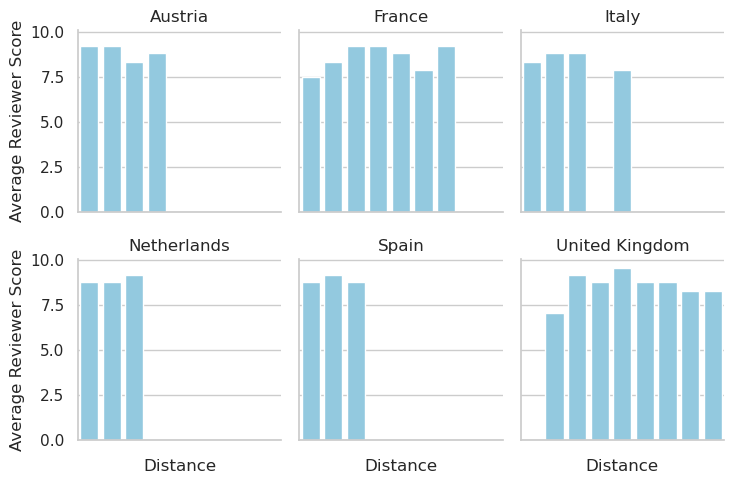

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

sampled_hotels = n_hotels[n_hotels['sample'] == 1] 
# Bin distance globally
sampled_hotels['distance_bin'] = pd.cut(sampled_hotels['distance_to_bad_landmark'], bins=9)

# Precompute averages
avg_scores_binned = (
    sampled_hotels.groupby(['hotel_country', 'distance_bin'])['reviewer_score']
    .median()
    .reset_index()
)

# FacetGrid for multiple plots
g = sns.FacetGrid(avg_scores_binned, col='hotel_country', col_wrap=3, height=2.5, sharey=True)
g.map_dataframe(sns.barplot, x='distance_bin', y='reviewer_score', color='skyblue')
g.set_xticklabels(rotation=90)
g.set_axis_labels("Distance", "Average Reviewer Score")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()

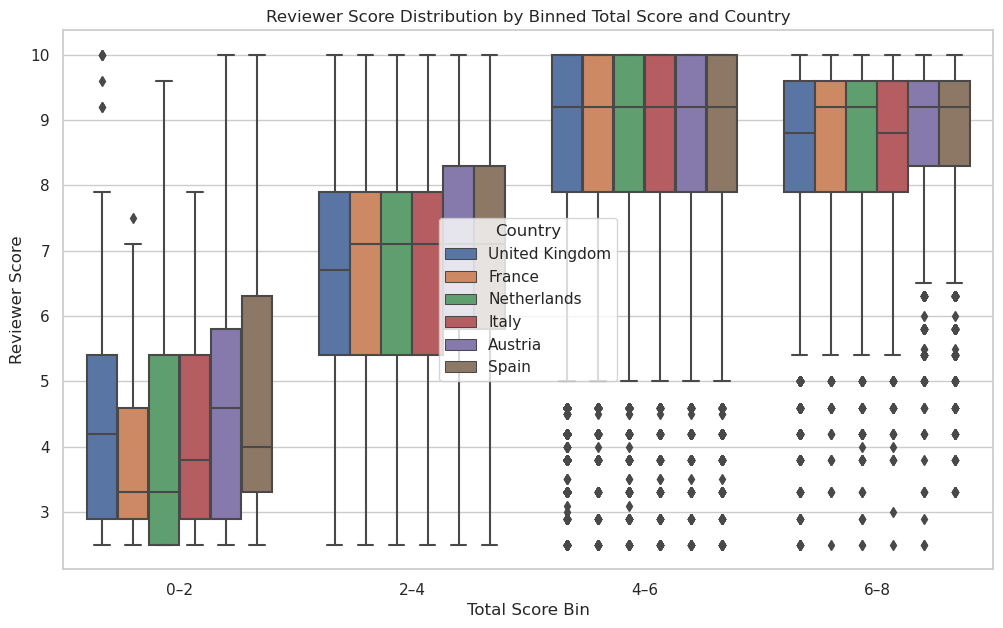

In [39]:
bins = [-2, -1, 0, 1, 2]
labels = ['0–2', '2–4', '4–6', '6–8']

n_hotels['tot_score_bin'] = pd.cut(
    n_hotels['tot_score'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

top_countries = (
    n_hotels['hotel_country']
    .value_counts()
    .head(6)
    .index
)

df = n_hotels[n_hotels['sample']==1 ]

plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df,
    x="tot_score_bin",
    y="reviewer_score",
    hue="hotel_country",
    order=labels
)

plt.title("Reviewer Score Distribution by Binned Total Score and Country")
plt.xlabel("Total Score Bin")
plt.ylabel("Reviewer Score")
plt.legend(title="Country")
plt.show()



In [40]:
#==================
#  Domestic Ttravel
#==================

n_hotels['domestic_traveler_flag'] = (
    n_hotels['hotel_country'].str.strip().str.lower() ==
    n_hotels['reviewer_nationality'].str.strip().str.lower()
).astype(int)

print(n_hotels['domestic_traveler_flag'].value_counts())

sampled_hotels = n_hotels[n_hotels['sample']==1].copy()
cohen_flag_check(sampled_hotels, flag_columns=["domestic_traveler_flag"])

0    308879
1    161591
Name: domestic_traveler_flag, dtype: int64
Flag: domestic_traveler_flag
  Cohen's d: 0.0052 (negligible)



In [41]:
#==================
#  Cross Continent Travel
#==================

continent_map = {
    'britain': ['united kingdom', 'england', 'scotland', 'wales', 'ireland','northern ireland'],
    'europe': [ 'france', 'germany', 'spain', 'italy', 'netherlands', 'belgium', 'sweden', 'norway', 'switzerland', 'portugal', 'poland', 'austria', 'greece',  'finland', 'czech republic', 'denmark', 'hungary', 'slovakia', 'romania', 'bulgaria', 'croatia', 'slovenia', 'iceland'],
    'asia': ['china', 'india', 'japan', 'malaysia', 'singapore', 'thailand', 'south korea', 'indonesia', 'philippines', 'vietnam', 'pakistan', 'bangladesh'],
    'americas': ['united states of america', 'canada', 'mexico', 'brazil', 'argentina', 'chile', 'colombia', 'peru'],
    'middle_east': ['united arab emirates', 'saudi arabia', 'qatar', 'kuwait', 'bahrain', 'oman', 'lebanon'],
    'africa': ['south africa', 'morocco', 'egypt', 'kenya', 'nigeria', 'ghana'],
    'oceania': ['australia', 'new zealand']
}

def get_continent(country):
    if pd.isna(country) or country.strip() == '':
        return 'unknown'
    country = country.strip().lower()
    for cont, countries in continent_map.items():
        if country in countries:
            return cont
    return 'other'

n_hotels['hotel_continent'] = n_hotels['hotel_country'].apply(get_continent)
n_hotels['reviewer_continent'] = n_hotels['reviewer_nationality'].apply(get_continent)

#dummies = pd.get_dummies(n_hotels['reviewer_continent'], prefix='nat')
#n_hotels = pd.concat([n_hotels, dummies], axis=1)

n_hotels['cross_region_flag'] = (
    (n_hotels['hotel_continent'] != n_hotels['reviewer_continent']).astype(int)
)

print(n_hotels[['hotel_country', 'reviewer_nationality', 'domestic_traveler_flag']].sample(10))
print(n_hotels['cross_region_flag'].value_counts(normalize=True))

         hotel_country reviewer_nationality  domestic_traveler_flag
494027     Netherlands               Egypt                        0
144232  United Kingdom             Denmark                        0
25776   United Kingdom      United Kingdom                        1
10951      Netherlands      United Kingdom                        0
426858  United Kingdom      United Kingdom                        1
21594           France              Turkey                        0
318952     Netherlands      United Kingdom                        0
280313          France      United Kingdom                        0
3463    United Kingdom      United Kingdom                        1
361013     Netherlands             Belgium                        0
1    0.544033
0    0.455967
Name: cross_region_flag, dtype: float64


Local visitors often have different expectations → tend to rate differently.

Far travelers might visit more expensive or tourist-oriented hotels → correlation with higher/lower reviewer_score.

It also serves as a proxy for tourism type or international popularity.

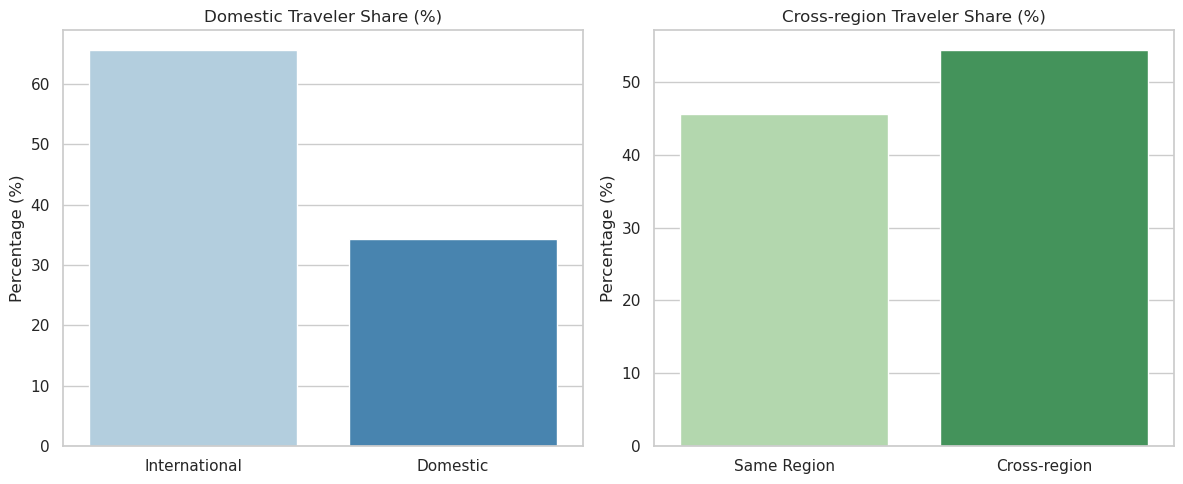

Flag: domestic_traveler_flag
  Cohen's d: 0.0052 (negligible)

Flag: cross_region_flag
  Cohen's d: 0.0320 (negligible)



In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot domestic vs international (cross-region)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Domestic traveler share
domestic_counts = n_hotels['domestic_traveler_flag'].value_counts(normalize=True) * 100
sns.barplot(
    x=domestic_counts.index,
    y=domestic_counts.values,
    ax=ax[0],
    palette='Blues'
)
ax[0].set_title("Domestic Traveler Share (%)")
ax[0].set_xticklabels(['International', 'Domestic'])
ax[0].set_ylabel("Percentage (%)")

# Cross-region share
cross_counts = n_hotels['cross_region_flag'].value_counts(normalize=True) * 100
sns.barplot(
    x=cross_counts.index,
    y=cross_counts.values,
    ax=ax[1],
    palette='Greens'
)
ax[1].set_title("Cross-region Traveler Share (%)")
ax[1].set_xticklabels(['Same Region', 'Cross-region'])
ax[1].set_ylabel("Percentage (%)")

plt.tight_layout()
plt.show()

sampled_hotels=n_hotels[n_hotels['sample']==1].copy()
cohen_flag_check(
    sampled_hotels,
    flag_columns=['domestic_traveler_flag', 'cross_region_flag'],
    score_col='reviewer_score'
)


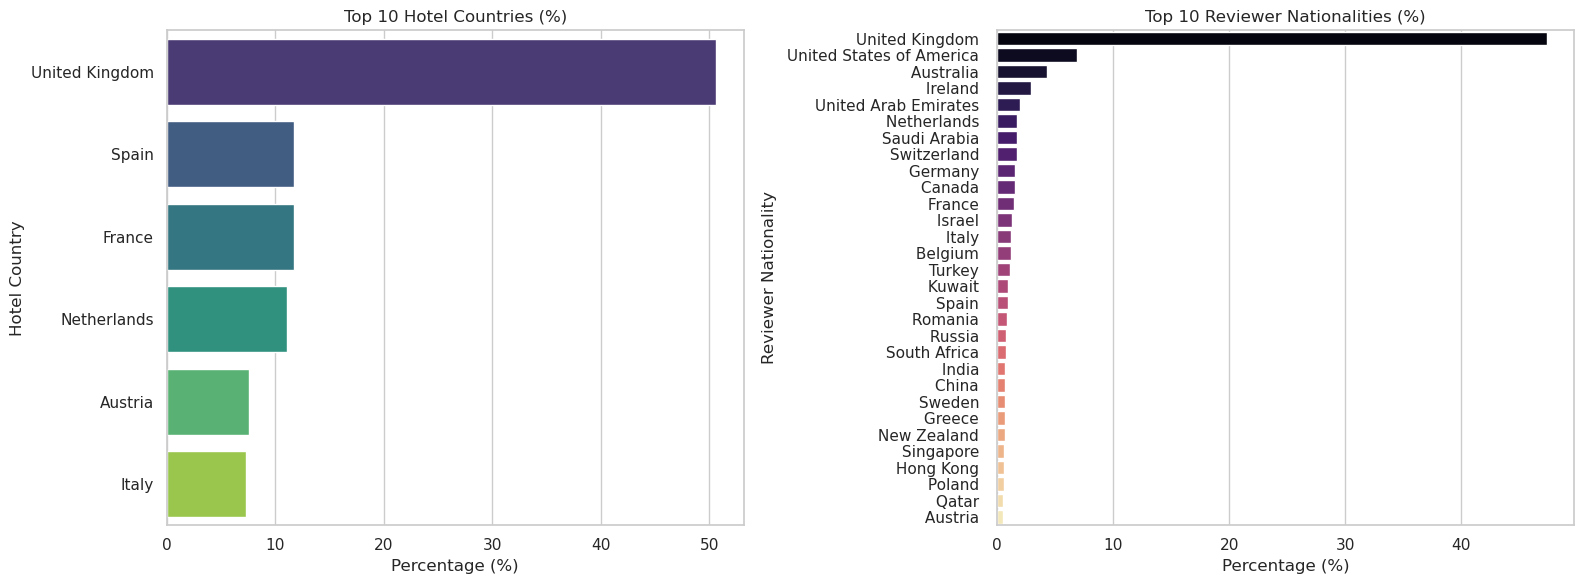

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Top hotel countries
top_hotels = n_hotels['hotel_country'].value_counts(normalize=True) * 100
sns.barplot(
    y=top_hotels.index,
    x=top_hotels.values,
    ax=ax[0],
    palette='viridis'
)
ax[0].set_title("Top 10 Hotel Countries (%)")
ax[0].set_xlabel("Percentage (%)")
ax[0].set_ylabel("Hotel Country")

# Top reviewer nationalities
top_reviewers = n_hotels['reviewer_nationality'].value_counts(normalize=True).head(30) * 100
sns.barplot(
    y=top_reviewers.index,
    x=top_reviewers.values,
    ax=ax[1],
    palette='magma'
)
ax[1].set_title("Top 10 Reviewer Nationalities (%)")
ax[1].set_xlabel("Percentage (%)")
ax[1].set_ylabel("Reviewer Nationality")

plt.tight_layout()
plt.show()


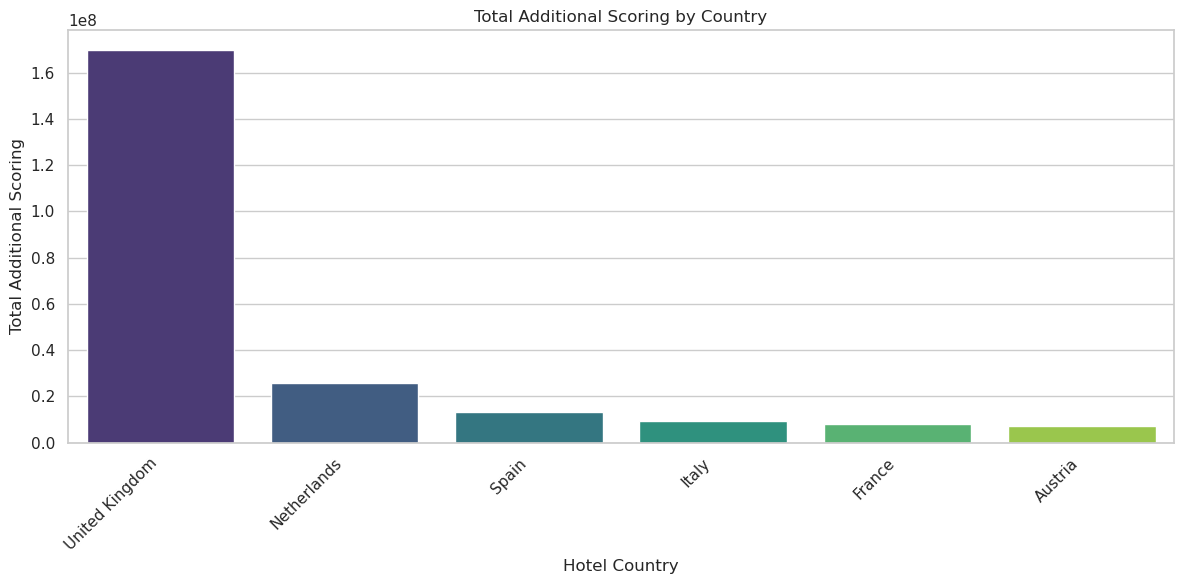

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and sort
country_scores = (
    n_hotels.groupby("hotel_country")["additional_number_of_scoring"]
           .sum()
           .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(
    x=country_scores.index,
    y=country_scores.values,
    palette="viridis"
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Additional Scoring")
plt.xlabel("Hotel Country")
plt.title("Total Additional Scoring by Country")
plt.tight_layout()
plt.show()


In [45]:
(
    n_hotels[n_hotels['sample'] == 1]
    .groupby("hotel_name")
    .agg({
        "additional_number_of_scoring": "mean",
        "reviewer_score": "mean",
        "average_score": "mean",
        "total_number_of_reviews": "mean"
    })
    .sort_values("additional_number_of_scoring", ascending=False)
    .head(10)
)


additional_number_of_scoring  \
hotel_name                                                                        
Britannia International Hotel Canary Wharf                               2682.0   
Park Plaza Westminster Bridge London                                     2623.0   
Strand Palace Hotel                                                      2288.0   
DoubleTree by Hilton Hotel London Tower of London                        1936.0   
Copthorne Tara Hotel London Kensington                                   1831.0   
Hilton London Metropole                                                  1485.0   
M by Montcalm Shoreditch London Tech City                                1471.0   
Millennium Gloucester Hotel London                                       1444.0   
Hilton London Wembley                                                    1427.0   
Park Plaza County Hall London                                            1322.0   

                                                   reviewer_score  \
hotel_name                                                          
Britannia International Hotel Canary Wharf               6.729543   
Park Plaza Westminster Bridge London                     8.581525   
Strand Palace Hotel                                      8.024499   
DoubleTree by Hilton Hotel London Tower of London        8.565774   
Copthorne Tara Hotel London Kensington                   7.988537   
Hilton London Metropole                                  7.246905   
M by Montcalm Shoreditch London Tech City                9.065841   
Millennium Gloucester Hotel London                       7.541194   
Hilton London Wembley                                    8.693516   
Park Plaza County Hall London                            8.290829   

                                                   average_score  \
hotel_name                                                         
Britannia International Hotel Canary Wharf                   7.1   
Park Plaza Westminster Bridge London                         8.7   
Strand Palace Hotel                                          8.1   
DoubleTree by Hilton Hotel London Tower of London            8.7   
Copthorne Tara Hotel London Kensington                       8.1   
Hilton London Metropole                                      7.5   
M by Montcalm Shoreditch London Tech City                    9.1   
Millennium Gloucester Hotel London                           7.8   
Hilton London Wembley                                        8.8   
Park Plaza County Hall London                                8.4   

                                                   total_number_of_reviews  
hotel_name                                                                  
Britannia International Hotel Canary Wharf                          9086.0  
Park Plaza Westminster Bridge London                               12158.0  
Strand Palace Hotel                                                 9568.0  
DoubleTree by Hilton Hotel London Tower of London                   7491.0  
Copthorne Tara Hotel London Kensington                              7105.0  
Hilton London Metropole                                             6977.0  
M by Montcalm Shoreditch London Tech City                           4802.0  
Millennium Gloucester Hotel London                                  5726.0  
Hilton London Wembley                                               4305.0  
Park Plaza County Hall London                                       6117.0

In [46]:
'''plt.figure(figsize=(20, 6))

# Select top N nationalities (optional)
top_nationalities = (
    n_hotels['reviewer_nationality']
    .value_counts()
    .head(55)   # change this number if needed
    .index
)
sampled_hotels = n_hotels[n_hotels['sample'] == 1]  
subset = sampled_hotels[n_hotels['reviewer_nationality'].isin(top_nationalities)]

sns.boxplot(
    data=subset,
    x='reviewer_nationality',
    y='reviewer_score',
    palette='Set3'
)

plt.title("Reviewer Score Distribution for Top Reviewer Nationalities", fontsize=14)
plt.xlabel("Reviewer Nationality")
plt.ylabel("Reviewer Score")
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()'''

'plt.figure(figsize=(20, 6))\n\n# Select top N nationalities (optional)\ntop_nationalities = (\n    n_hotels[\'reviewer_nationality\']\n    .value_counts()\n    .head(55)   # change this number if needed\n    .index\n)\nsampled_hotels = n_hotels[n_hotels[\'sample\'] == 1]  \nsubset = sampled_hotels[n_hotels[\'reviewer_nationality\'].isin(top_nationalities)]\n\nsns.boxplot(\n    data=subset,\n    x=\'reviewer_nationality\',\n    y=\'reviewer_score\',\n    palette=\'Set3\'\n)\n\nplt.title("Reviewer Score Distribution for Top Reviewer Nationalities", fontsize=14)\nplt.xlabel("Reviewer Nationality")\nplt.ylabel("Reviewer Score")\nplt.xticks(rotation=90, ha=\'right\')\n\nplt.tight_layout()\nplt.show()'

In [47]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'neg_word_count_log', 'pos_word_count_log', 'empty_positive_flag',
       'empty_negative_flag', 'pos_word_count_bin', 'neg_word_count_bin',
       'pos_word_count_bin2', 'neg_word_count_bin2', 'p_empty_flag',
       'n_empty_flag', 'both_empty_flag', 'p_absolute_flag', 'n_absolute_flag',
       'p_everything_flag', 'n_everything_flag', 'positive_score',
       'negative_score', 'tot_score', 'positive_score_e', 'negative_score_e',
       'satisfaction_flag', 'positive_word_%', 'negative_word_%', 'pos_vs_neg',
       'pos_vs_neg2', 'satisfaction_flag1', 'satisfact

## Reviewer nationality

In [48]:
# ======================================================
# 1. CLEAN WHITESPACE AND NA VALUES
# ======================================================

n_hotels['reviewer_nationality'] = (
    n_hotels['reviewer_nationality']
    .astype(str)                       # in case there are numbers or None
    .str.strip()                       # remove spaces, tabs, newlines
    .replace({"": None})               # convert "" into NaN
    .fillna("Other")                   # fill NaN → Other
)


# ======================================================
# 2. REPLACE RARE NATIONALITIES (appearing < threshold)
# ======================================================

threshold = 100

nat_counts = n_hotels['reviewer_nationality'].value_counts()

unpopular_nationalities = nat_counts[nat_counts < threshold].index

n_hotels['reviewer_nationality'] = (
    n_hotels['reviewer_nationality']
    .where(~n_hotels['reviewer_nationality'].isin(unpopular_nationalities),
           "Other")
)

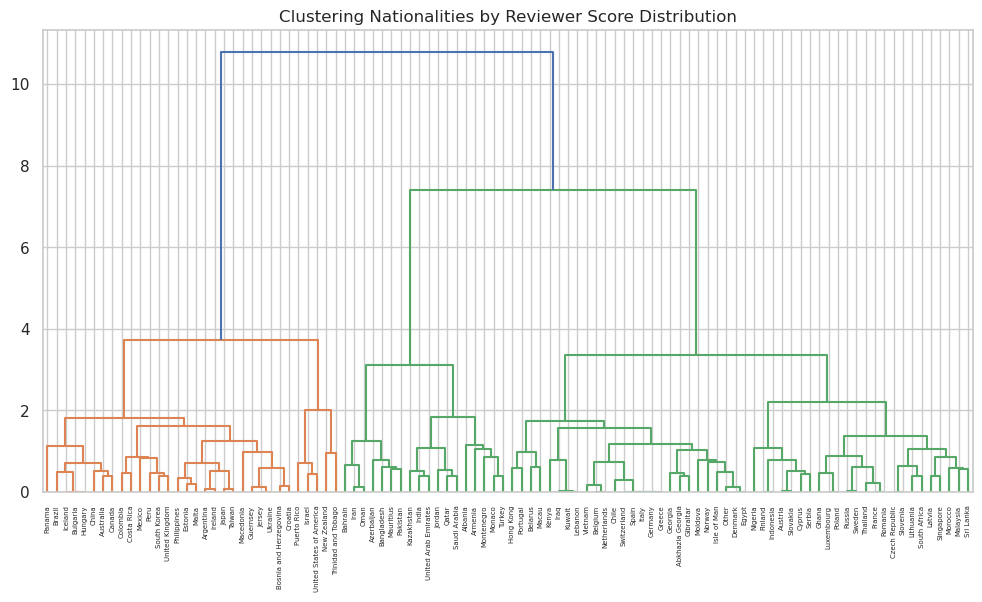


Cluster 1:
['Brazil', 'Bulgaria', 'Hungary', 'Iceland']

Cluster 2:
['Australia', 'Canada', 'China']

Cluster 3:
['Panama']

Cluster 4:
['Colombia', 'Costa Rica']

Cluster 5:
['Peru', 'South Korea', 'United Kingdom']

Cluster 6:
['Mexico']

Cluster 7:
['Estonia', 'Malta', 'Philippines']

Cluster 8:
['Argentina', 'Ireland', 'Japan', 'Taiwan']

Cluster 9:
['Guernsey', 'Jersey', 'Ukraine']

Cluster 10:
['Bosnia and Herzegovina', 'Croatia']

Cluster 11:
['Macedonia']

Cluster 12:
['Israel', 'United States of America']

Cluster 13:
['Puerto Rico']

Cluster 14:
['New Zealand']

Cluster 15:
['Trinidad and Tobago']

Cluster 16:
['Iran', 'Oman']

Cluster 17:
['Bahrain']

Cluster 18:
['Mauritius', 'Pakistan']

Cluster 19:
['Bangladesh']

Cluster 20:
['Azerbaijan']

Cluster 21:
['India', 'Kazakhstan', 'United Arab Emirates']

Cluster 22:
['Jordan', 'Qatar', 'Saudi Arabia']

Cluster 23:
['Monaco', 'Turkey']

Cluster 24:
['Montenegro']

Cluster 25:
['Armenia']

Cluster 26:
['Albania']

Cluster 27:

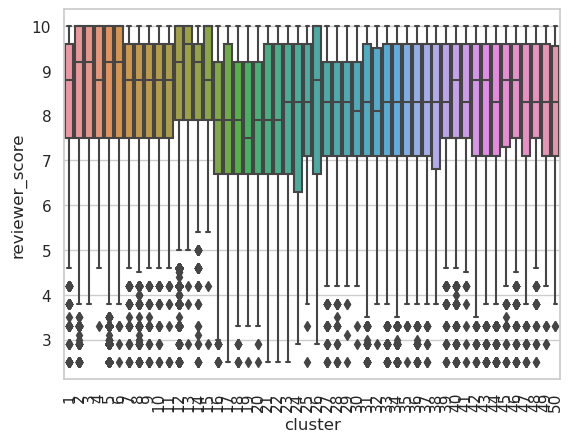

In [49]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# 1. Select nationalities with enough observations
# ======================================================


#n_hotels = nn_hotels.copy()

def remove_outliers_iqr(df, group_col, value_col):
    def _filter(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return group[(group[value_col] >= lower) & (group[value_col] <= upper)]
    
    return df.groupby(group_col, group_keys=False).apply(_filter)



#top_n = 150
nationalities = (
    n_hotels['reviewer_nationality']
    .value_counts()
    #.head(top_n)
    .index
)
#sampled_hotels = n_hotels[n_hotels['sample'] == 1]  
#df_sub = sampled_hotels[sampled_hotels['reviewer_nationality'].isin(nationalities)]


sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()

# Remove outliers before clustering
df_sub = remove_outliers_iqr(
    sampled_hotels,
    group_col='reviewer_nationality',
    value_col='reviewer_score'
)


df_sub = df_sub[df_sub['reviewer_nationality'].isin(nationalities)]



# ======================================================
# 2. Compute quantile vectors
# ======================================================

qs = np.linspace(0.05, 0.95, 10)

quantile_vectors = (
    df_sub.groupby('reviewer_nationality')['reviewer_score']
          .quantile(qs)
          .unstack()     # => nationality × 10 quantiles
)

# ======================================================
# 3. Hierarchical clustering (Ward)
# ======================================================

Z = linkage(quantile_vectors, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=quantile_vectors.index, leaf_rotation=90)
plt.title("Clustering Nationalities by Reviewer Score Distribution")
plt.show()

# ======================================================
# 4. Cut dendrogram into clusters
# ======================================================

num_clusters = 50
quantile_vectors['cluster'] = fcluster(Z, num_clusters, criterion='maxclust').astype('int64')

# Inspect clusters
for c, group in quantile_vectors.groupby('cluster').groups.items():
    print(f"\nCluster {c}:")
    print(list(group))

# ======================================================
# 5. Make cluster lookup table
# ======================================================

nationality_clusters = quantile_vectors['cluster'].reset_index()
nationality_clusters.columns = ['reviewer_nationality', 'cluster']

# ======================================================
# 6. Merge cluster labels into main dataset
# ======================================================

n_hotels = n_hotels.merge(
    nationality_clusters,
    how='left',
    on='reviewer_nationality'
)

# ======================================================
# 7. Compute cluster-level statistics
# ======================================================

cluster_stats = (
    n_hotels.groupby('cluster')['reviewer_score']
    .agg(
        cluster_mean_score='mean',
        cluster_median_score='median',
        cluster_std_score='std'
    )
    .reset_index()
)

# Merge cluster stats back
n_hotels = n_hotels.merge(cluster_stats, on='cluster', how='left')

# ======================================================
# 8. Optional: Plot cluster boxplots
# ======================================================
sampled_hotels = n_hotels[n_hotels['sample'] == 1]  # only training data
sns.boxplot(
    data=sampled_hotels[sampled_hotels['cluster'].notna()],
    x='cluster',
    y='reviewer_score'
)

plt.xticks(rotation=90)
plt.show()


In [50]:
n_hotels[n_hotels['cluster'].isna()]

Empty DataFrame
Columns: [hotel_address, additional_number_of_scoring, review_date, average_score, hotel_name, reviewer_nationality, negative_review, review_total_negative_word_counts, total_number_of_reviews, positive_review, review_total_positive_word_counts, total_number_of_reviews_reviewer_has_given, tags, days_since_review, lat, lng, sample, reviewer_score, neg_word_count_log, pos_word_count_log, empty_positive_flag, empty_negative_flag, pos_word_count_bin, neg_word_count_bin, pos_word_count_bin2, neg_word_count_bin2, p_empty_flag, n_empty_flag, both_empty_flag, p_absolute_flag, n_absolute_flag, p_everything_flag, n_everything_flag, positive_score, negative_score, tot_score, positive_score_e, negative_score_e, satisfaction_flag, positive_word_%, negative_word_%, pos_vs_neg, pos_vs_neg2, satisfaction_flag1, satisfaction_flag2, satisfaction_flag3, hotel_country, country_Austria, country_France, country_Italy, country_Netherlands, country_Spain, country_United Kingdom, hotel_city, distance_from_city_center, distance_to_closest_landmark, distance_to_bad_landmark, tot_score_bin, domestic_traveler_flag, hotel_continent, reviewer_continent, cross_region_flag, cluster, cluster_mean_score, cluster_median_score, cluster_std_score]
Index: []

## Tag Processing

In [51]:
#n_hotels = nn_hotels.copy()

###  Nights stayed

In [52]:
# -------------------------------
#  Extract number of nights stayed
# -------------------------------

# Extract the number of nights from tags, e.g., "Stayed 3 nights"
regex_nights = r'Stayed (\d+) night[s]?'
n_hotels['nights'] = n_hotels['tags'].str.extract(regex_nights)
n_hotels['nights'] = n_hotels['nights'].fillna(0).astype(int)

# Remove nights-related tags from the 'tags' column
n_hotels['tags'] = n_hotels['tags'].str.replace(regex_nights, '', regex=True)

#  Short stay flag
#sampled_hotels = n_hotels[n_hotels['sample']==1]
n_hotels['short_stay_flag'] = (n_hotels['nights'] < 1).astype(int)

sampled_hotels = n_hotels[n_hotels['sample']==1]
cohen_flag_check(
    sampled_hotels,
    flag_columns=['short_stay_flag'],
    score_col='reviewer_score'
)

Flag: short_stay_flag
  Cohen's d: -1.1386 (large effect)



In [53]:
n_hotels['tags'].apply(lambda x: x.split(',')[0].strip()).unique()

array(["[' Leisure trip '", "[' Business trip '", "[' Group '",
       "[' Couple '", "[' With a pet '",
       "[' Family with young children '", "[' Solo traveler '",
       "[' Family with older children '", "[' Group ']",
       "[' Travelers with friends '", "[' Couple ']",
       "[' Family with young children ']"], dtype=object)

In [54]:

# -------------------------------
#  Trip type
# -------------------------------
# Extract trip type tags, e.g., "Leisure trip", "Business trip"
#regex_trip = r"(Leisure trip|Business trip|.*? trip)"
#n_hotels['trip'] = n_hotels['tags'].str.extract(regex_trip)
# Encode trip type as ordinal
#trip_encoder = ce.OrdinalEncoder()
#n_hotels['trip'] = trip_encoder.fit_transform(n_hotels[['trip']])
# Remove trip tags from 'tags' column
#n_hotels['tags'] = n_hotels['tags'].str.replace(regex_trip, '', regex=True)


# -------------------------------
#  Simplified Traveler type
# -------------------------------

def categorize_traveler(tag_str):
    """
    Categorize traveler type based on keywords anywhere in the tag string.
    Returns:
      1 = solo
      2 = couple
      3 = group/family/friends
      0 = unknown
    """
    if pd.isna(tag_str) or not isinstance(tag_str, str) or tag_str.strip() == '':
        return 0

    tag_lower = tag_str.lower()

    if "solo" in tag_lower:
        return 1
    elif "couple" in tag_lower:
        return 2
    elif any(word in tag_lower for word in ["family"]):
        return 3
    elif "friends" in tag_lower:
        return 3
    elif "group" in tag_lower:
        return 3
    #elif any(word in tag_lower for word in [ "children" ]):
    #    return 6
    else:
        return 0


# Apply the function
n_hotels['traveler_type'] = n_hotels['tags'].apply(categorize_traveler)
'''
# Show distribution
traveler_type_counts = n_hotels['traveler_type'].value_counts().sort_index().reset_index()
traveler_type_counts.columns = ['Traveler_Type', 'Count']
print("Simplified traveler types:")
print(traveler_type_counts)

'''
n_hotels['traveler_type'].unique()


array([2, 3, 1])

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_21/2308589467.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


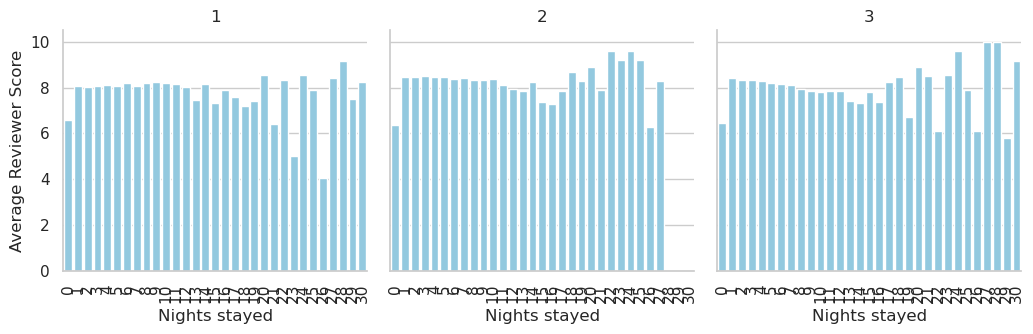

In [55]:
sampled_hotels = n_hotels[n_hotels['sample'] == 1] 
# Bin distance globally
#sampled_hotels['distance_bin'] = pd.cut(sampled_hotels['distance_from_city_center'], bins=19)

# Precompute averages
avg_scores_binned = (
    sampled_hotels.groupby(['traveler_type', 'nights'])['reviewer_score']
    .mean()
    .reset_index()
)

# FacetGrid for multiple plots
g = sns.FacetGrid(avg_scores_binned, col='traveler_type', col_wrap=3, height=3.5, sharey=True)
g.map_dataframe(sns.barplot, x='nights', y='reviewer_score', color='skyblue')
g.set_xticklabels(rotation=90)
g.set_axis_labels("Nights stayed", "Average Reviewer Score")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()

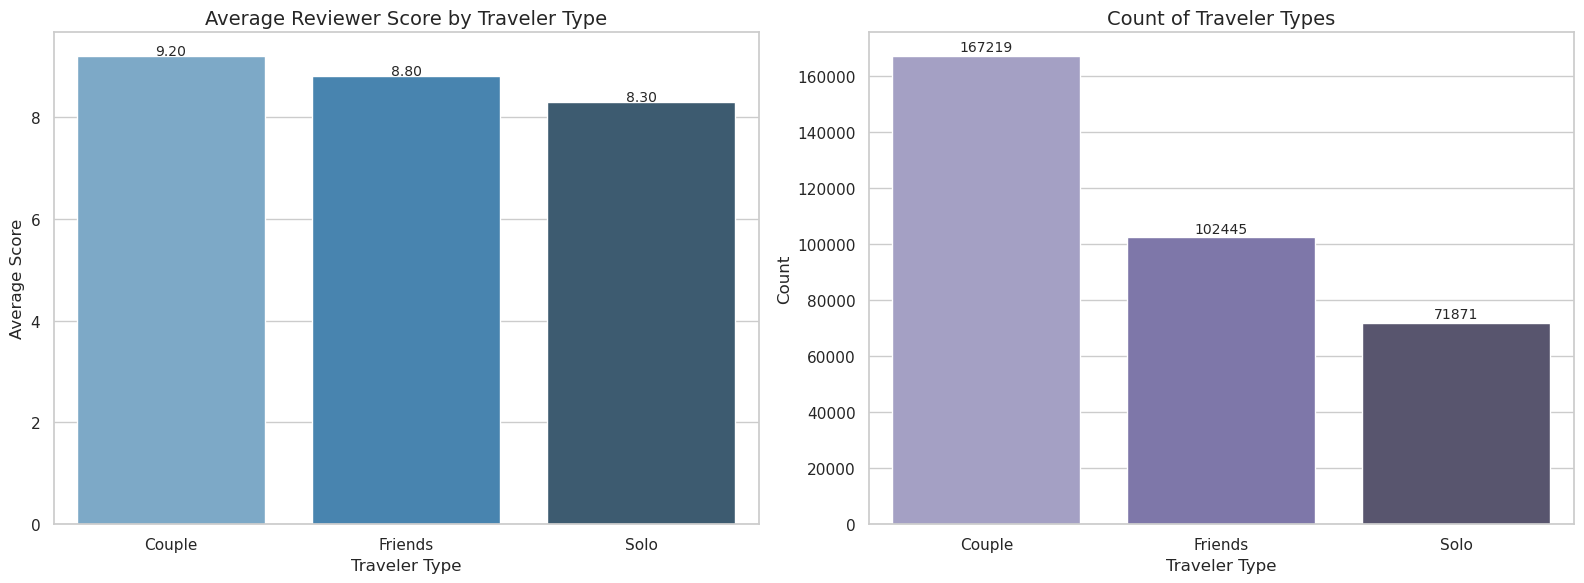

In [56]:
traveler_labels = {
    0: 'Unknown',
    1: 'Solo',
    2: 'Couple',
    3: 'Friends',
    4: 'Group',
    5: 'Family',
    6: 'Children'
}

sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()
sampled_hotels['traveler_type_label'] = sampled_hotels['traveler_type'].map(traveler_labels)


# ==== A: Mean reviewer score by traveler type ====
mean_scores = (
    sampled_hotels.groupby('traveler_type_label')['reviewer_score']
    .median()
    .reset_index()
    .sort_values(by='reviewer_score', ascending=False)
)

# ==== B: Count of traveler types ====
traveler_counts = (
    sampled_hotels['traveler_type_label']
    .value_counts()
    .reset_index()
)

traveler_counts.columns = ['traveler_type_label', 'count']

# ==== Plot ====
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Left plot: Mean scores ---
sns.barplot(
    data=mean_scores,
    x='traveler_type_label',
    y='reviewer_score',
    palette='Blues_d',
    ax=axes[0]
)

axes[0].set_title("Average Reviewer Score by Traveler Type", fontsize=14)
axes[0].set_xlabel("Traveler Type", fontsize=12)
axes[0].set_ylabel("Average Score", fontsize=12)
axes[0].tick_params(axis='x')

# Add numbers above bars
for i, row in mean_scores.iterrows():
    axes[0].text(
        i,
        row['reviewer_score'] + 0.02,
        f"{row['reviewer_score']:.2f}",
        ha='center',
        fontsize=10
    )

# ------------------------
# Plot 2: Frequency of traveler types
# ------------------------
sns.barplot(
    data=traveler_counts,
    x='traveler_type_label',
    y='count',
    palette='Purples_d',
    ax=axes[1]
)

axes[1].set_title("Count of Traveler Types", fontsize=14)
axes[1].set_xlabel("Traveler Type", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].tick_params(axis='x')

# Add numbers above bars
for i, row in traveler_counts.iterrows():
    axes[1].text(
        i,
        row['count'] + traveler_counts['count'].max() * 0.01,
        f"{row['count']}",
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [57]:
# Remove traveler_type tag from 'tags' column (optional cleanup)
traveler_type_original = ['Couple','Solo traveler','Family with young children','Group','Family with older children','Travelers with friends']
for key in traveler_type_original: #traveler_type_counts['Traveler_Type'].unique():
    n_hotels['tags'] = n_hotels['tags'].str.replace(str(key), '', regex=False)

In [58]:
n_hotels['tags']

0           [' Leisure trip ', '  ', ' Double Room ', '  ']
1           [' Leisure trip ', '  ', ' Triple Room ', '  ']
2         [' Business trip ', '  ', ' Twin Room ', '  ',...
3         [' Leisure trip ', '  ', ' Ambassador Junior S...
4         [' Business trip ', '  ', ' Classic Double or ...
                                ...                        
470465    [' Leisure trip ', '  ', ' Club Double or Twin...
470466    [' Leisure trip ', '  ', ' Standard Double Roo...
470467     [' Business trip ', '  ', ' Single Room ', '  ']
470468    [' Leisure trip ', '  ', ' Deluxe Double Room ...
470469    [' Leisure trip ', '  ', ' Bunk Bed Room ', '  ']
Name: tags, Length: 470470, dtype: object

In [59]:
# Dictionary of flags with associated keywords
keywords_dict = {
    'pet_flag': ['With a pet'],
    'mobile_flag': ['Submitted from a mobile device'],
    'non_smoking_flag': ['Non Smoking'],
    'business_trip_flag': ['Business trip'],
    'disability_flag': ['Disability'],
    'free_flag': ['Free', 'Complimentary', 'No charge','Access', 'Included'],
    'view_flag': ['View','balcony','terrase','garden', 'patio', 'deck', 'veranda', 'lawn', 'courtyard', 'outdoor seating'],
    #'balcony_flag': ['balcony','terrase','garden', 'patio', 'deck', 'veranda', 'lawn', 'courtyard', 'outdoor seating'],
    'no_window_flag': ['No Window', 'Interior room'],
    'romantic_flag': ['Romantic', 'Honeymoon', 'Couple'],
}


import re

# Precompile regex patterns
regex_dict = {
    flag: re.compile("|".join(map(re.escape, keywords)), flags=re.IGNORECASE)
    for flag, keywords in keywords_dict.items()
}

# Create all flags
for flag_name, pattern in regex_dict.items():
    n_hotels[flag_name] = n_hotels['tags'].str.contains(pattern).astype(int)
    n_hotels['tags'] = n_hotels['tags'].str.replace(pattern, '', regex=True)


In [60]:

cohen_flag_check(n_hotels, list(keywords_dict.keys()), score_col='reviewer_score')

Flag: pet_flag
  Cohen's d: -0.0064 (negligible)

Flag: mobile_flag
  Cohen's d: 0.0300 (negligible)

Flag: non_smoking_flag
  Cohen's d: -0.2082 (small effect)

Flag: business_trip_flag
  Cohen's d: -0.3318 (small effect)

Flag: disability_flag
  Cohen's d: -0.0660 (negligible)

Flag: free_flag
  Cohen's d: 0.0359 (negligible)

Flag: view_flag
  Cohen's d: 0.1501 (negligible)

Flag: no_window_flag
  Cohen's d: -0.8906 (large effect)

Flag: romantic_flag
  Cohen's d: 0.2098 (small effect)



In [61]:
import numpy as np
import pandas as pd

sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()
# Automatically select all columns that end with "_flag"
flag_cols = [col for col in n_hotels.columns if col.endswith('_flag')]


flag_summary = []
for col in flag_cols:
    # drop rows where reviewer_score is NaN
    subset = sampled_hotels[['reviewer_score', col]].dropna(subset=['reviewer_score'])
    # medians
    med0 = subset.loc[subset[col] == 0, 'reviewer_score'].median()
    med1 = subset.loc[subset[col] == 1, 'reviewer_score'].median()
    # means
    mn0 = subset.loc[subset[col] == 0, 'reviewer_score'].mean()
    mn1 = subset.loc[subset[col] == 1, 'reviewer_score'].mean()
    # counts
    c0 = subset.loc[subset[col] == 0].shape[0]
    c1 = subset.loc[subset[col] == 1].shape[0]
    flag_summary.append({
        'flag': col,
        'median_flag_0': med0,
        'median_flag_1': med1,
        'mean_flag_0': mn0,
        'mean_flag_1': mn1,
        'count_flag_0': c0,
        'count_flag_1': c1,
        'median_diff': med1 - med0,
        'mean_diff': mn1 - mn0
    })

flag_summary_df = pd.DataFrame(flag_summary).set_index('flag').sort_values('median_flag_1', ascending=False)
display(flag_summary_df)


median_flag_0  median_flag_1  mean_flag_0  \
flag                                                                
p_absolute_flag                   8.8           10.0     8.332507   
p_everything_flag                 8.8           10.0     8.328559   
n_everything_flag                 8.8           10.0     8.338514   
n_empty_flag                      7.9            9.6     7.768381   
empty_negative_flag               7.9            9.6     7.768381   
romantic_flag                     8.8            9.2     8.341176   
view_flag                         8.8            9.2     8.331075   
both_empty_flag                   8.8            9.2     8.341590   
satisfaction_flag                 7.9            9.2     7.890090   
free_flag                         8.8            9.0     8.340210   
mobile_flag                       8.8            8.8     8.311526   
disability_flag                   8.8            8.8     8.341447   
cross_region_flag                 8.8            8.8     8.312149   
pet_flag                          8.8            8.8     8.341277   
domestic_traveler_flag            8.8            8.8     8.338262   
non_smoking_flag                  8.8            8.3     8.344241   
business_trip_flag                8.8            7.9     8.429056   
no_window_flag                    8.8            7.1     8.342750   
short_stay_flag                   8.8            6.7     8.341977   
p_empty_flag                      9.2            5.8     8.506215   
empty_positive_flag               9.2            5.8     8.506215   
n_absolute_flag                   8.8            NaN     8.343787   

                        mean_flag_1  count_flag_0  count_flag_1  median_diff  \
flag                                                                           
p_absolute_flag            9.732833        339403          2132          1.2   
p_everything_flag          9.692450        338287          3232          1.2   
n_everything_flag          9.528791        339681          1563          1.2   
n_empty_flag               9.416217        222801        118734          1.7   
empty_negative_flag        9.416217        222801        118734          1.7   
romantic_flag              8.691429        341465            70          0.4   
view_flag                  8.581579        327665         13870          0.4   
both_empty_flag            7.951505        341236           299          0.4   
satisfaction_flag          8.721525         29606        272870          1.3   
free_flag                  8.400084        335613          5922          0.2   
mobile_flag                8.361602        138820        202715          0.0   
disability_flag            8.231169        340919           616          0.0   
cross_region_flag          8.365592        155571        185964          0.0   
pet_flag                   8.330630        340598           937          0.0   
domestic_traveler_flag     8.346969        224406        117129          0.0   
non_smoking_flag           7.996702        338594          2941         -0.5   
business_trip_flag         7.879157        286999         54536         -0.9   
no_window_flag             6.856232        341190           345         -1.7   
short_stay_flag            6.441221        341404           131         -2.1   
p_empty_flag               5.792646        320772         20763         -3.4   
empty_positive_flag        5.792646        320772         20763         -3.4   
n_absolute_flag                 NaN        341257             0          NaN   

                        mean_diff  
flag                               
p_absolute_flag          1.400326  
p_everything_flag        1.363891  
n_everything_flag        1.190276  
n_empty_flag             1.647836  
empty_negative_flag      1.647836  
romantic_flag            0.350252  
view_flag                0.250504  
both_empty_flag         -0.390085  
satisfaction_flag        0.831435  
free_flag                0.059874  
mobile_flag   

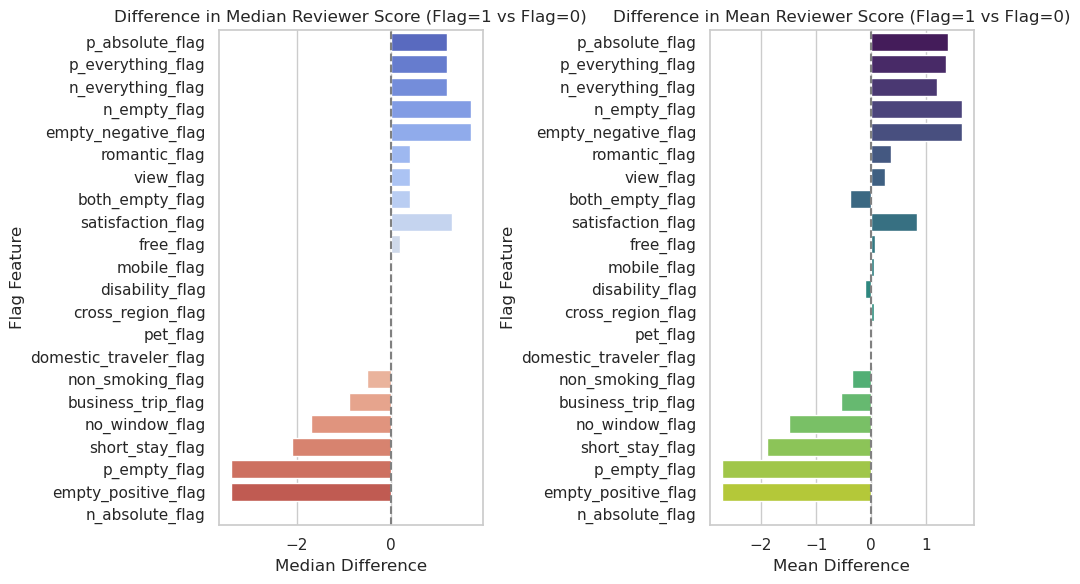

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
#plt.figure(figsize=(10, 6))
sns.barplot(
    x='median_diff',
    y=flag_summary_df.index,
    data=flag_summary_df,
    palette='coolwarm',
    ax = axes[0]
)
axes[0].axvline(0, color='gray', linestyle='--')
axes[0].set_title("Difference in Median Reviewer Score (Flag=1 vs Flag=0)")
axes[0].set_xlabel("Median Difference")
axes[0].set_ylabel("Flag Feature")

sns.barplot(
    x='mean_diff',
    y=flag_summary_df.index,
    data=flag_summary_df,
    palette='viridis',
    ax=axes[1]
)
axes[1].axvline(0, color='gray', linestyle='--')
axes[1].set_title("Difference in Mean Reviewer Score (Flag=1 vs Flag=0)")
axes[1].set_xlabel("Mean Difference")
axes[1].set_ylabel("Flag Feature")

plt.tight_layout()
plt.show()

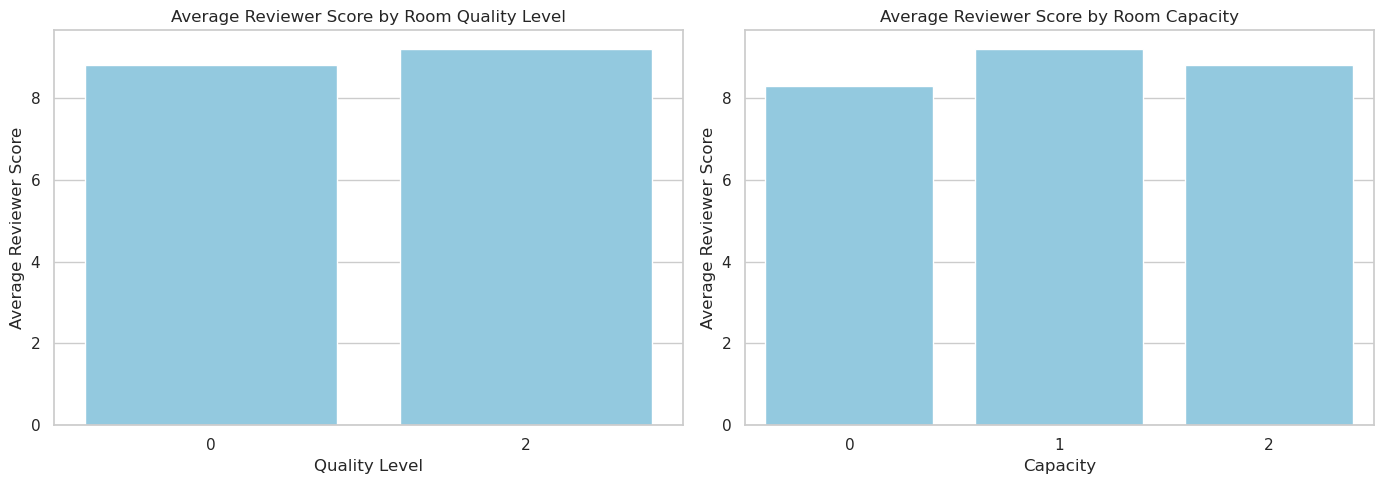

In [63]:
# ============================================
# ROOM FEATURES EXTRACTION
# ============================================

#  Room capacity

def get_room_capacity(tag):
    tag = str(tag).lower()
    
    if "single" in tag :
        return 0
    #elif "studio" in tag or "suite" in tag:
    #    return 1
    #elif "queen room" in tag or "standart room" in tag:
    #    return 1
    #elif "king room" in tag :
    #    return 1
    elif "double" in tag or "twin" in tag or "2 rooms" in tag:
        return 2
    elif "triple" in tag or "3 rooms" in tag:
        return 2
    elif "quadruple" in tag:
        return 2
    else:
        return 1

n_hotels['room_capacity'] = n_hotels['tags'].apply(get_room_capacity)



#   Room description

quality_tag_1 = [ 'standard', 'basic', 'economy', 'ordinary', 'classic']
quality_tag_2 = [ 'superior', 'deluxe', 'executive', 'premium','premier', 'luxury','queen', 'king']
def get_room_quality(tag):
    tag = str(tag).lower()
    if any(word in tag for word in quality_tag_1):
        return 0
    elif any(word in tag for word in quality_tag_2):
        return 2
    else:
        return 0

n_hotels['room_quality_level'] = n_hotels['tags'].apply(get_room_quality)


sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()
# Compute mean reviewer_score for each room_capacity
mean_scores2 = sampled_hotels.groupby('room_quality_level')['reviewer_score'].median().reset_index()
mean_scores1 = sampled_hotels.groupby('room_capacity')['reviewer_score'].median().reset_index()


fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(data=mean_scores2, x='room_quality_level', y='reviewer_score', color='skyblue', ax=axes[0])
axes[0].set_title("Average Reviewer Score by Room Quality Level")
axes[0].set_xlabel("Quality Level")
axes[0].set_ylabel("Average Reviewer Score")

sns.barplot(data=mean_scores1, x='room_capacity', y='reviewer_score', color='skyblue', ax=axes[1])
axes[1].set_title("Average Reviewer Score by Room Capacity")
axes[1].set_xlabel("Capacity")
axes[1].set_ylabel("Average Reviewer Score")

plt.tight_layout()
plt.show()





In [64]:
# -------------------------------
#  Clean leftover tags string
# -------------------------------
import re

# Remove traveler_type tag from 'tags' column (optional cleanup)
remove_tag = ["leisure trip", "business trip", "single", "studio", "suite", "double","twin" , "2 rooms","triple","3 rooms" ,"quadruple"] + quality_tag_1 + quality_tag_2

for key in remove_tag:
    # (?i) makes the pattern case-insensitive
    pattern = rf"(?i){re.escape(key)}"
    n_hotels['tags'] = n_hotels['tags'].str.replace(pattern, '', regex=True)

n_hotels['tags'] = n_hotels['tags'].str.replace('[\[\]\'\,]', '', regex=True)
n_hotels['tags'] = n_hotels['tags'].str.strip()
n_hotels['tags'].unique()

array(['Room', 'Ambassador Junior', 'or  Room', ...,
       'Family Room 6 Adults', 'Two Adjoining Rooms with Dock  Upper',
       'Westminster  with  Bed'], dtype=object)

## Encoding of Reviews

In [65]:
'''keywords =  ["poor", "terrible", "awful", "horrible", "dreadful", "abysmal", "subpar", "lousy", "disappointing","disappointed","unacceptable","unpleasant","bad experience","not good","not great","not worth", "never again","not recommend","not recommended","never stay", "hate","dont recommend","worst","struggle","nightmare","dirty",'disaster','dont like','disgusting']

for word in keywords:
    if " " in word:  
        # multi-word → no word boundaries
        pattern = rf"{word}"
    else:
        # single word → use \b
        pattern = rf"\b{word}\b"
        
    mask = n_hotels["positive_review"].str.contains(pattern, case=False, regex=True, na=False)
    if mask.sum()==0:
        print(word, mask.sum())
    if mask.sum()>=1000:
        print(word, mask.sum())
'''

'keywords =  ["poor", "terrible", "awful", "horrible", "dreadful", "abysmal", "subpar", "lousy", "disappointing","disappointed","unacceptable","unpleasant","bad experience","not good","not great","not worth", "never again","not recommend","not recommended","never stay", "hate","dont recommend","worst","struggle","nightmare","dirty",\'disaster\',\'dont like\',\'disgusting\']\n\nfor word in keywords:\n    if " " in word:  \n        # multi-word → no word boundaries\n        pattern = rf"{word}"\n    else:\n        # single word → use \x08\n        pattern = rf"\x08{word}\x08"\n        \n    mask = n_hotels["positive_review"].str.contains(pattern, case=False, regex=True, na=False)\n    if mask.sum()==0:\n        print(word, mask.sum())\n    if mask.sum()>=1000:\n        print(word, mask.sum())\n'

In [66]:
# Dictionary of flags with associated keywords
keywords_dict = {
    'r_room_flag': ["room", "rooms", " bed ","beds","pillows", "tv","television", "noise","quiet", "view","balcony","window","space", "spacious", "patio","hotel"],
    'r_ac_flag': ["air conditioning"," ac ","a c " ,"heating"],
    'r_bath_flag': ["bathroom","bath","shower","toilet"],
    'r_wifi_flag': ["wifi", "wi fi","internet","tv","television"],
    'r_pool_flag': ["pool","swimmingpool"],
    'r_stuff_flag': [ "staff","service", "servise","service","friendly","helpful","rude","unprofessional","polite","reception","manager","personnel","team","employees","cleaning","housekeeping","maid","concierge"],
    'r_food_flag': [ "food","breakfast","dinner","restaurant","bar"],
    'r_price_flag': ["expensive", "price","cheap","cost","value","worth","affordable","overpriced","budget","money","rate","rates","deal","discount"],
    'r_location_flag': ["location","view","central","centre","city center","city centre","distance","close","far","walking","transport","metro","bus","train","airport","space","subway"],
    'r_everything_flag': ["everything", "every thing", " all ","anything", "everythig", "everythin"],
    }

keywords_dict2 = {
    'r_excellent_flag': ["excellent", "perfect", "amazing", "fantastic", "wonderful", "outstanding", "superb", "incredible", "exceptional","marvelous","fabulous","phenomenal"],
    'r_red_flag': ["poor", "terrible", "awful", "horrible", "dreadful", "abysmal", "subpar", "lousy", "disappointing","disappointed","unacceptable","unpleasant","bad experience","miserable" ,"not good","not great","not worth", "never again","not recommend","not recommended","never stay", "hate","worst","struggle","nightmare","dirty",'disaster','dont like','disgusting'],
    'r_come_back_flag': ["will come back", "definitely return", "certainly return", "absolutely return", "sure return", "will return","would come back","would return","will stay again","would stay again","its my favorite","my favorite","love this hotel","loved this hotel","as always great","always great","my go to hotel","as usual"],
    'r_nice_flag': ["nice", "cute", "cosy","good"],
    'r_dirty_flag': ["dirty","messy","mess","noisy","noise"],
}

# Function to create a flag from a list of keywords
def create_flag(text, keywords):
    """Return 1 if any keyword is found """
    text = str(text).lower()
    for word in keywords:
        if word.lower() in text:
            return 1
    return 0

# Loop over the dictionary and generate flags
for flag_name, keywords in keywords_dict.items():
    n_hotels[flag_name] = n_hotels['positive_review'].apply(lambda x: create_flag(x, keywords)) - n_hotels['negative_review'].apply(lambda x: create_flag(x, keywords))
for flag_name, keywords in keywords_dict2.items():
    n_hotels[flag_name] = n_hotels['positive_review'].apply(lambda x: create_flag(x, keywords)) + n_hotels['negative_review'].apply(lambda x: create_flag(x, keywords))

n_hotels['something_flag'] = (
    n_hotels[keywords_dict.keys()].sum(axis=1) + 5 * ( n_hotels['r_excellent_flag'] + n_hotels['r_everything_flag'] -  n_hotels['r_red_flag'])
)

cohen_flag_check(n_hotels, list(keywords_dict.keys())+ ['something_flag'] , score_col='reviewer_score')


# Check the result
n_hotels[ list(keywords_dict.keys()) + ['something_flag'] ].tail(10)

Flag: r_room_flag
  Cohen's d: 0.5848 (medium effect)

Flag: r_ac_flag
  Cohen's d: 0.2045 (small effect)

Flag: r_bath_flag
  Cohen's d: 0.2364 (small effect)

Flag: r_wifi_flag
  Cohen's d: 0.1285 (negligible)

Flag: r_pool_flag
  Cohen's d: 0.3086 (small effect)

Flag: r_stuff_flag
  Cohen's d: 0.6160 (medium effect)

Flag: r_food_flag
  Cohen's d: 0.3219 (small effect)

Flag: r_price_flag
  Cohen's d: 0.2957 (small effect)

Flag: r_location_flag
  Cohen's d: 0.1483 (negligible)

Flag: r_everything_flag
  Cohen's d: 0.6536 (medium effect)

Flag: something_flag
  Cohen's d: 0.5288 (medium effect)



r_room_flag  r_ac_flag  r_bath_flag  r_wifi_flag  r_pool_flag  \
470460            0          0            0            0            0   
470461            1          0            0            0            0   
470462           -1          0            0            0            0   
470463           -1          0            0           -1            0   
470464            0          0            0            0            0   
470465            0          0            0            0            0   
470466            1          0            0            0            0   
470467           -1          0            1            0            0   
470468            0          0            0            0            0   
470469            0          0            0            0            0   

        r_stuff_flag  r_food_flag  r_price_flag  r_location_flag  \
470460             0            0             0                1   
470461             0            0             0                1   
470462            -1            0             0                1   
470463             1            0             0                0   
470464             0            0             0                1   
470465             0            0             0                1   
470466             0            0             0                1   
470467             0            0             0                1   
470468             0            0             0                1   
470469             1            0             0                0   

        r_everything_flag  something_flag  
470460                  0               1  
470461                  0               7  
470462                  0              -1  
470463                  0              -6  
470464                  0               1  
470465                  0               1  
470466                  0               7  
470467                  0               1  
470468                  0               1  
470469                  0               1

In [67]:
n_hotels[list(keywords_dict.keys())+['something_flag','reviewer_score']].tail(10)

r_room_flag  r_ac_flag  r_bath_flag  r_wifi_flag  r_pool_flag  \
470460            0          0            0            0            0   
470461            1          0            0            0            0   
470462           -1          0            0            0            0   
470463           -1          0            0           -1            0   
470464            0          0            0            0            0   
470465            0          0            0            0            0   
470466            1          0            0            0            0   
470467           -1          0            1            0            0   
470468            0          0            0            0            0   
470469            0          0            0            0            0   

        r_stuff_flag  r_food_flag  r_price_flag  r_location_flag  \
470460             0            0             0                1   
470461             0            0             0                1   
470462            -1            0             0                1   
470463             1            0             0                0   
470464             0            0             0                1   
470465             0            0             0                1   
470466             0            0             0                1   
470467             0            0             0                1   
470468             0            0             0                1   
470469             1            0             0                0   

        r_everything_flag  something_flag  reviewer_score  
470460                  0               1             9.6  
470461                  0               7             9.2  
470462                  0              -1             5.8  
470463                  0              -6             5.0  
470464                  0               1             7.9  
470465                  0               1             8.8  
470466                  0               7             9.2  
470467                  0               1             8.3  
470468                  0               1             9.2  
470469                  0               1             8.8

In [68]:
#n_hotels[['positive_review','negative_review']].iloc[511407]

In [69]:
low_reviews = (
    n_hotels[
        (n_hotels["reviewer_score"] < 3) &
        (n_hotels["sample"] == 1)
    ][["negative_review", "positive_review"]]
    .dropna()
)

sampled = low_reviews.sample(10, random_state=42)

for idx, row in sampled.iterrows():
    print("—", row["negative_review"], "\n")
    print("+", row["positive_review"], "\n")
    print("=" * 60)


— everything went wrong with the hotel room 

+ nothing 

— not worth rude check in staff hopeless breakfast choice room cleaning only once no real w hotel feel 

+ n0thing 

— staff very poor and service also poor 

+ breakfast good but expensive 

— its not clean at all and the staff r slow and rude 

+ no positive 

— unfriendly staff overall specially one of their night evening supervisor named namakan he is non cooperative and rude other than that even location of hotel is not good highly unsafe 

+ no positive 

— nothing everything whas horrible first of all the hotel did not say that it is a gay hotel and also they put pictures that they show on booking that are not true at all everything is a scam 

+ nothing everything whas horrible its a scam 

— the rooms be careful when you make reservation or booking they gave me a room from 1 tiny tiny window in a souterrain room awkward smell from bathroom not well cleaned and dusty in front of the so called window opening where you can

In [70]:
cohen_flag_check(n_hotels, list(keywords_dict2.keys()), score_col='reviewer_score')


Flag: r_excellent_flag
  Cohen's d: 0.7032 (medium effect)

Flag: r_red_flag
  Cohen's d: -1.3140 (large effect)

Flag: r_come_back_flag
  Cohen's d: 0.6015 (medium effect)

Flag: r_nice_flag
  Cohen's d: 0.0073 (negligible)

Flag: r_dirty_flag
  Cohen's d: -0.8383 (large effect)



In [71]:
'''for type in ['positive_review' , 'negative_review']:
        # Normalize case and drop missing
    pos_reviews = (
        n_hotels[type]
        .dropna()
        .str.strip()
        .str.lower()  # make case-insensitive
    )
    
    # Count unique occurrences
    popular_positive = (
        pos_reviews.value_counts()
        .reset_index()
        .rename(columns={'index': type, type: 'count'})
    )
    
    # Display top 10
    print(" Most Popular {type}:")
    display(popular_positive.head(10))'''


'for type in [\'positive_review\' , \'negative_review\']:\n        # Normalize case and drop missing\n    pos_reviews = (\n        n_hotels[type]\n        .dropna()\n        .str.strip()\n        .str.lower()  # make case-insensitive\n    )\n    \n    # Count unique occurrences\n    popular_positive = (\n        pos_reviews.value_counts()\n        .reset_index()\n        .rename(columns={\'index\': type, type: \'count\'})\n    )\n    \n    # Display top 10\n    print(" Most Popular {type}:")\n    display(popular_positive.head(10))'

In [72]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'neg_word_count_log', 'pos_word_count_log', 'empty_positive_flag',
       'empty_negative_flag', 'pos_word_count_bin', 'neg_word_count_bin',
       'pos_word_count_bin2', 'neg_word_count_bin2', 'p_empty_flag',
       'n_empty_flag', 'both_empty_flag', 'p_absolute_flag', 'n_absolute_flag',
       'p_everything_flag', 'n_everything_flag', 'positive_score',
       'negative_score', 'tot_score', 'positive_score_e', 'negative_score_e',
       'satisfaction_flag', 'positive_word_%', 'negative_word_%', 'pos_vs_neg',
       'pos_vs_neg2', 'satisfaction_flag1', 'satisfact

In [73]:
n_hotels[ (n_hotels['sample']==1) ][['positive_review', 'negative_review','tot_score', 'reviewer_score', 'something_flag']].sample(30)


positive_review  \
301887               nothing much apart from the location   
214866              great position in centre of amsterdam   
238870  the croissants were extra flaky the champagne ...   
321306                                           location   
193136  great central location clean comfortable room ...   
232936  very comfortable beds rooms very well designed...   
392965                       good location good breakfast   
131064  small boutique hotel centrally located nice la...   
382783  this is truly a superb hotel i arrived with th...   
301631  it was quiet in the old town close to the rail...   
405393          exactly what you want from a 5 star hotel   
358760  a pleasant surprise when we arrived for the pr...   
400188  we liked the fact that it was very clean the c...   
202317                         the location is very great   
339078  the lobby staff were professional very nice po...   
206082                         good breakfast and service   
340445  the bed was very comfortable and the room was ...   
250993                                       localisation   
297455                                location good staff   
369549                   the breakfast and room was great   
362810  good location with spacious room excellent sta...   
448383  perfect location beside milano centrale walkin...   
398812  really loved this hotel the check in was smoot...   
223753  good proximity to 2 underground stations and b...   
319676  the room was great very spacious with massive ...   
443598         perfect location on high end shopping area   
374617  lift flew up and down great location peaceful ...   
135159   friendly staff and a modern hotel great location   
388700  the beds were really comfortable and the towel...   
415206  room was big enough and it was quiet good loca...   

                                          negative_review  tot_score  \
301887  firstly the car park has tiny spaces and diffi...     0.9746   
214866                       very small room cracked sink     0.6249   
238870                                        not a thing     0.5106   
321306                                    everything else     0.0000   
193136  a very minor point couldn t get the tv to swit...     0.9538   
232936                                        no negative     0.9346   
392965  bed ok but mattress not great worn old carpet ...     0.3373   
131064                                        no negative     0.9147   
382783                                        no negative     0.9897   
301631  the pool area crowded no room to sit no ambien...     0.3035   
405393                                        no negative     0.0772   
358760                                            nothing     0.9530   
400188         the wi fi signal was fluctuating sometimes     0.9212   
202317  the bathroom s door is from glass the breakfas...     0.6590   
339078  dissappointed no one replaced burned out bulb ...     0.4759   
206082                                    beds a bit hard     0.3377   
340445                                        no negative     0.9473   
250993                                              price     0.0000   
297455                              rooms need a facelift     0.4404   
369549  the lunch there was delicious but it took aski...     0.1482   
362810            the breakfast 17 is not value for money     0.5066   
448383  reception could do with some training on pleas...     1.2595   
398812  parking is very limited some confusion over th...     0.3473   
223753  the room size was compact for a doubletree hot...    -0.0692   
319676  unfortunately there was a problem with the spa...     0.3345   
443598                                        no negative     0.5719   
374617               decour and facilities were bit dated     0.8074   
135159                                        no negative     0.8074   
388700                                            nothing     

In [74]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'neg_word_count_log', 'pos_word_count_log', 'empty_positive_flag',
       'empty_negative_flag', 'pos_word_count_bin', 'neg_word_count_bin',
       'pos_word_count_bin2', 'neg_word_count_bin2', 'p_empty_flag',
       'n_empty_flag', 'both_empty_flag', 'p_absolute_flag', 'n_absolute_flag',
       'p_everything_flag', 'n_everything_flag', 'positive_score',
       'negative_score', 'tot_score', 'positive_score_e', 'negative_score_e',
       'satisfaction_flag', 'positive_word_%', 'negative_word_%', 'pos_vs_neg',
       'pos_vs_neg2', 'satisfaction_flag1', 'satisfact

In [75]:
n_hotels[
    ((n_hotels['negative_score'] == -1) |
    (n_hotels['positive_score'] == -1)) &
    (n_hotels['reviewer_score'] <= 10)
][['positive_review', 'negative_review', 'reviewer_score', 'positive_score','negative_score','tot_score']].sample(10)

positive_review negative_review  \
243386                   can t fault this hotel excellent      everything   
195912                             everything was perfect      everything   
415661                                            nothing      everything   
392622                everything about the hotel was aone      everything   
444377                                            nothing      everything   
125660                                           very bad      everything   
335557                                            nothing      everything   
336187  it was amazing hotel all around could not faul...      everything   
161948                                            nothing      everything   
2069    friendly helpful staff lovely food and comfort...      everything   

        reviewer_score  positive_score  negative_score  tot_score  
243386            10.0          0.2500            -1.0    -0.7500  
195912            10.0          1.0000            -1.0     0.0000  
415661             3.3          0.0000            -1.0    -1.0000  
392622            10.0          0.0000            -1.0    -1.0000  
444377             2.5          0.0000            -1.0    -1.0000  
125660             0.0         -0.5849            -1.0    -1.5849  
335557             2.9          0.0000            -1.0    -1.0000  
336187            10.0          0.7234            -1.0    -0.2766  
161948             2.9          0.0000            -1.0    -1.0000  
2069               0.0          0.9201            -1.0    -0.0799

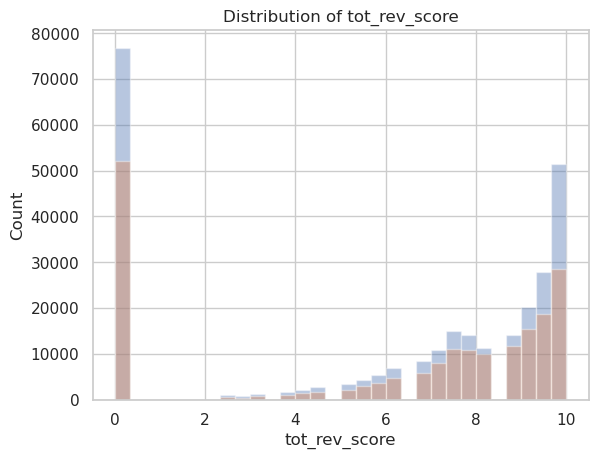

In [76]:
import matplotlib.pyplot as plt

#plt.hist(n_hotels[n_hotels['tot_score']<0]['tot_rev_score'], bins=30, alpha=0.4)
plt.hist(n_hotels[n_hotels['mobile_flag'] == 1]['reviewer_score'], bins=30, alpha=0.4)
plt.hist(n_hotels[n_hotels['mobile_flag'] == 0 ]['reviewer_score'], bins=30, alpha=0.4)
plt.xlabel("tot_rev_score")
plt.ylabel("Count")
plt.title("Distribution of tot_rev_score")
plt.show()

In [77]:
flag_cols = [col for col in n_hotels.columns if col.startswith('r_') and col.endswith('_flag')]
n_hotels[n_hotels['sample']==1][['positive_review','negative_review' ]+ flag_cols + ['something_flag','reviewer_score']].sample(20)


positive_review  \
447795  value location to see tour attraction very clo...   
422083  the location of the hotel is very nice near th...   
431099  friendly helpful staff room comfy nice tea tra...   
449659                             location staff comfort   
335680  friendly receptionists and great location to g...   
332984                                        no positive   
392398  the room was very comfortable and contained al...   
433312  ok breakfest the staff was friendly and helpfu...   
427088                         the location was 1st class   
439193             the breakfast was good that s about it   
212902                                        no positive   
329254            it s great a lovely old fashioned place   
354962  great location clean and modern hotel very com...   
138804  free breakfast for the children lovely suite w...   
327436  central location on a quiet street spacious co...   
393380                          location and modern decor   
153291                                        no positive   
192634  vegan friendly with options for breakfast dinn...   
400990  the hotel was in the middle of renovations whi...   
226548  we were upgraded at no extra cost which was lo...   

                                          negative_review  r_room_flag  \
447795                                        no negative            0   
422083  the bed was not very comfy and the breakfast i...            0   
431099             needs new carpets stairs bit difficult            1   
449659  the room is too small it was the executive and...           -1   
335680  breakfast is a buffet so it s never going to b...            1   
332984                        prices of drinks in the bar            0   
392398                                        no negative            1   
433312  the room was ok at best wierd layout and not a...           -1   
427088  the initial front desk staff were efficient bu...           -1   
439193  they lied in there advert they say they have a...           -1   
212902  the room was the worst hotel room we have ever...           -1   
329254                                        no negative            0   
354962  too bad that complimentary minibar was not rep...            0   
138804                                        no negative            1   
327436  small elevator lots of old stairs reception is...            0   
393380                             size of room too small           -1   
153291  staff completely unhelpful did not give me a s...            0   
192634  room temperature controlled centrally i believ...            0   
400990                            breakfast was very poor            1   
226548  the fact that both mornings the cooked breakfa...            0   

        r_ac_flag  r_bath_flag  r_wifi_flag  r_pool_flag  r_stuff_flag  \
447795          0            0            0            0             0   
422083          0            0            0            0             0   
431099          0            1            0            0             1   
449659          0            0            0            0             1   
335680          0            0            0            0             1   
332984          0            0            0            0             0   
392398          0            0            0            0             1   
433312          0            0            0            0             1   
427088         -1            0            0            0            -1   
439193         -1           -1            0            0            -1   
212902          0           -1            0            0             0   
329254          0            0            0            0             0   
354962          0            0            0            0             0   
138804          0            0            1            0             0   
327436          0            0            0            0             0   
393380          0    

In [78]:
'''n_hotels[n_hotels['reviewer_score'] == 10] \
         .nsmallest(35, 'pos_vs_neg')[['pos_vs_neg','positive_review', 'negative_review','reviewer_score']]

count_bad_10 = n_hotels[(n_hotels['reviewer_score'] == 10) & 
                        (n_hotels['pos_vs_neg'] <= 0)].shape[0]

print(count_bad_10)
print("Proportion of bad reviews with score 10: ", count_bad_10 / n_hotels[n_hotels['reviewer_score'] == 10].shape[0])


mask = (n_hotels['reviewer_score'] == 10) & (n_hotels['pos_vs_neg'] <= 0)

# Keep only rows where mask is False
n_hotels = n_hotels[~mask]

print("New dataset size after removing bad 10s: ", n_hotels.shape[0])'''

'n_hotels[n_hotels[\'reviewer_score\'] == 10]          .nsmallest(35, \'pos_vs_neg\')[[\'pos_vs_neg\',\'positive_review\', \'negative_review\',\'reviewer_score\']]\n\ncount_bad_10 = n_hotels[(n_hotels[\'reviewer_score\'] == 10) & \n                        (n_hotels[\'pos_vs_neg\'] <= 0)].shape[0]\n\nprint(count_bad_10)\nprint("Proportion of bad reviews with score 10: ", count_bad_10 / n_hotels[n_hotels[\'reviewer_score\'] == 10].shape[0])\n\n\nmask = (n_hotels[\'reviewer_score\'] == 10) & (n_hotels[\'pos_vs_neg\'] <= 0)\n\n# Keep only rows where mask is False\nn_hotels = n_hotels[~mask]\n\nprint("New dataset size after removing bad 10s: ", n_hotels.shape[0])'

In [79]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'neg_word_count_log', 'pos_word_count_log', 'empty_positive_flag',
       'empty_negative_flag', 'pos_word_count_bin', 'neg_word_count_bin',
       'pos_word_count_bin2', 'neg_word_count_bin2', 'p_empty_flag',
       'n_empty_flag', 'both_empty_flag', 'p_absolute_flag', 'n_absolute_flag',
       'p_everything_flag', 'n_everything_flag', 'positive_score',
       'negative_score', 'tot_score', 'positive_score_e', 'negative_score_e',
       'satisfaction_flag', 'positive_word_%', 'negative_word_%', 'pos_vs_neg',
       'pos_vs_neg2', 'satisfaction_flag1', 'satisfact

In [80]:
#n_hotels[ ((n_hotels['reviewer_score'] == 10) & (n_hotels['mobile_flag']==0)) ].nsmallest(50, 'pos_vs_neg')[['pos_vs_neg','positive_review', 'negative_review','reviewer_score','positive_score', 'negative_score','mobile_flag']]

In [81]:
count_bad_10 = n_hotels[(n_hotels['reviewer_score'] == 10) & 
                        (n_hotels['tot_score'] <= 0)].shape[0]
count_bad_10

5725

In [82]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'neg_word_count_log', 'pos_word_count_log', 'empty_positive_flag',
       'empty_negative_flag', 'pos_word_count_bin', 'neg_word_count_bin',
       'pos_word_count_bin2', 'neg_word_count_bin2', 'p_empty_flag',
       'n_empty_flag', 'both_empty_flag', 'p_absolute_flag', 'n_absolute_flag',
       'p_everything_flag', 'n_everything_flag', 'positive_score',
       'negative_score', 'tot_score', 'positive_score_e', 'negative_score_e',
       'satisfaction_flag', 'positive_word_%', 'negative_word_%', 'pos_vs_neg',
       'pos_vs_neg2', 'satisfaction_flag1', 'satisfact

In [83]:
n_hotels.nlargest(15, 'review_total_negative_word_counts')[['positive_review', 'negative_review','reviewer_score','positive_score', 'negative_score']]

positive_review  \
182439  slept well quiet rooms and enjoyed the view ap...   
246008                 i liked the location and the rooms   
254506               breakfast was good location was good   
63845                                             nothing   
135916                                        no positive   
408472                                            nothing   
278917   the location is very central and close to a tube   
378861                               conveniently located   
453659  sunaina soares assistant front office manager ...   
193860   only the park outside of the hotel was beautiful   
297086  the overall look of the communal areas very ni...   
251113  my first stay was absolutely lovely clean room...   
298285  no much really had aircon and the double bed w...   
81596   location is good 2 mins to earl s court statio...   
438069  i liked the room view because it was as i expe...   

                                          negative_review  reviewer_score  \
182439  the staff had a bad experience even after book...             5.4   
246008  i did not like how the management handled my c...             7.1   
254506  i didn t like the fact that when i wrote an em...             4.2   
63845   the customer service was really bad on arrival...             0.0   
135916  first of all i want to start with saying that ...             3.8   
408472  want to be happy in london don t ever go to cl...             2.5   
278917  overall summary decent location but do not sta...             6.3   
378861  unfair day 1 9 p m friday tired after many hou...             4.6   
453659  we were a bit dissatisfied with our check in e...             7.9   
193860  i am so angry that i made this post available ...             2.9   
297086  the fact that i had booked a suite and was sho...             7.9   
251113  my second stay at the end of my trip was a nig...             6.3   
298285  let me start by saying i booked months ago and...             2.9   
81596   rigid rules our plane arrives in the morning s...             0.0   
438069  the stuff informed us that the hotel is under ...             7.1   

        positive_score  negative_score  
182439          0.6597         -0.9972  
246008          0.4215         -0.8841  
254506          0.7003         -0.3291  
63845           0.0000         -0.9804  
135916          0.0000          0.8628  
408472          0.0000          0.7163  
278917          0.0000          0.9402  
378861          0.0000         -0.1266  
453659          0.8555         -0.7981  
193860          0.5994         -0.9418  
297086          0.9391          0.7199  
251113          0.9036          0.9804  
298285         -0.6369         -0.8806  
81596           0.8834         -0.9092  
438069          0.8883         -0.8879

In [84]:
n_hotels['negative_review'].iloc[320513]

'no negative'

In [85]:
'''# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()

# --- Left plot: difference ---
axes[0].hist(sampled_hotels['diff_pos_neg_words'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Positive vs Negative Word Difference')
axes[0].set_xlabel('Positive - Negative Word Count')
axes[0].set_ylabel('Frequency')

# --- Right plot: ratio ---
axes[1].hist(sampled_hotels['pos_vs_neg'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Positive to Negative Word Ratio')
axes[1].set_xlabel('Positive / Negative Word Ratio')
axes[1].set_ylabel('Frequency')

# --- Right plot: ratio ---
#axes[2].hist(data.loc[data['total_number_of_reviews_reviewer_has_given'] > 100, 'total_number_of_reviews_reviewer_has_given'], bins=50, color='salmon', edgecolor='black')
#axes[2].hist(sampled_hotels['pos_to_neg_ratio'], bins=50, color='salmon', edgecolor='black')
#axes[2].set_title('Distribution of Positive to Negative Word Ratio')
#axes[2].set_xlabel('Positive / Negative Word Ratio')
#axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()'''

"# Set up the figure\nfig, axes = plt.subplots(1, 3, figsize=(14, 5))\nsampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()\n\n# --- Left plot: difference ---\naxes[0].hist(sampled_hotels['diff_pos_neg_words'], bins=50, color='skyblue', edgecolor='black')\naxes[0].set_title('Distribution of Positive vs Negative Word Difference')\naxes[0].set_xlabel('Positive - Negative Word Count')\naxes[0].set_ylabel('Frequency')\n\n# --- Right plot: ratio ---\naxes[1].hist(sampled_hotels['pos_vs_neg'], bins=50, color='salmon', edgecolor='black')\naxes[1].set_title('Distribution of Positive to Negative Word Ratio')\naxes[1].set_xlabel('Positive / Negative Word Ratio')\naxes[1].set_ylabel('Frequency')\n\n# --- Right plot: ratio ---\n#axes[2].hist(data.loc[data['total_number_of_reviews_reviewer_has_given'] > 100, 'total_number_of_reviews_reviewer_has_given'], bins=50, color='salmon', edgecolor='black')\n#axes[2].hist(sampled_hotels['pos_to_neg_ratio'], bins=50, color='salmon', edgecolor='black')\n#

In [86]:
for type in ['positive' , 'negative']:
    reviews = (
        n_hotels[[type+'_review', 'reviewer_score', 'positive_score','negative_score','positive_word_%','negative_word_%','pos_vs_neg','satisfaction_flag']]
        .dropna(subset=[type+'_score'])
        .sort_values(by=type+'_score', ascending=True)  # ascending → most negative first
    )
    # Display 
    print(type+" reviews with highest (most negative) sentiment scores:")
    display(reviews.head(10))
    print(type+" reviews with lowest (most negative) sentiment scores:")
    display(reviews.tail(10))

# Drop the original text columns as they are now encoded
#n_hotels.drop(['positive_review', 'negative_review'], axis=1, inplace=True)

positive reviews with highest (most negative) sentiment scores:


positive_review  reviewer_score  positive_score  negative_score  \
376917  not recommended             2.5            -1.0         -1.0000   
400404   everything bad             2.5            -1.0         -0.5849   
383266         not good             5.0            -1.0          0.0000   
244832             poor             3.8            -1.0          0.0000   
154163              bad             5.0            -1.0         -1.0000   
77481   not recommended             0.0            -1.0          0.0000   
229185         not good             3.3            -1.0          0.2484   
248517   bad experience             4.2            -1.0         -0.9035   
140138             poor             2.9            -1.0         -1.0000   
345477        nightmare             4.6            -1.0         -0.2173   

        positive_word_%  negative_word_%  pos_vs_neg  satisfaction_flag  
376917         0.500000         0.250000   -0.495631               -1.0  
400404         0.333333         0.500000   -0.774779               -1.0  
383266         0.200000         0.700000   -0.626424               -1.0  
244832         0.090909         0.818182   -0.784738               -1.0  
154163         0.333333         0.333333   -0.783467               -1.0  
77481          0.333333         0.500000   -0.377374               -1.0  
229185         0.181818         0.727273   -0.500420               -1.0  
248517         0.021277         0.968085   -2.381626               -1.0  
140138         0.333333         0.333333   -0.783467               -1.0  
345477         0.032258         0.935484   -1.150675               -1.0

positive reviews with lowest (most negative) sentiment scores:


positive_review  reviewer_score  positive_score  \
96127                   all fine             0.0             1.0   
29886                 everything             0.0             1.0   
416993  everything was excellent            10.0             1.0   
175811             all excellent            10.0             1.0   
250667    everything was perfect            10.0             1.0   
175906                everything            10.0             1.0   
323794                   perfect            10.0             1.0   
455518                 excellent            10.0             1.0   
455474                  all good            10.0             1.0   
151566                   perfect            10.0             1.0   

        negative_score  positive_word_%  negative_word_%  pos_vs_neg  \
96127           0.0000         0.285714         0.571429    0.205223   
29886           0.0000         0.500000         0.000000    1.359141   
416993          0.3818         0.230769         0.692308    0.154705   
175811          0.0000         0.666667         0.000000    1.812188   
250667          0.0000         0.750000         0.000000    2.038711   
175906          0.0000         0.500000         0.000000    1.359141   
323794          0.0000         0.500000         0.000000    1.359141   
455518         -1.0000         0.333333         0.333333    0.000000   
455474          0.0000         0.666667         0.000000    1.812188   
151566          0.0000         0.500000         0.000000    1.359141   

        satisfaction_flag  
96127                 1.0  
29886                 1.0  
416993                1.0  
175811                1.0  
250667                1.0  
175906                1.0  
323794                1.0  
455518                0.0  
455474                1.0  
151566                1.0

negative reviews with highest (most negative) sentiment scores:


negative_review  reviewer_score  positive_score  negative_score  \
289470             all            10.0          1.0000            -1.0   
319257      everything             2.5          0.0000            -1.0   
228728      everything             6.3          0.0000            -1.0   
273115      everything             2.5          0.0000            -1.0   
319351      everything             7.9          1.0000            -1.0   
222193      everything             2.5          0.0000            -1.0   
329595             all             5.8          0.9040            -1.0   
270715      everything             2.5          0.0000            -1.0   
76611              all             0.0          0.0000            -1.0   
208977      everything            10.0          0.5719            -1.0   

        positive_word_%  negative_word_%  pos_vs_neg  satisfaction_flag  
289470         0.333333         0.333333    0.000000                0.0  
319257         0.000000         0.500000   -1.359141               -1.0  
228728         0.000000         0.500000   -1.359141               -1.0  
273115         0.000000         0.500000   -1.359141               -1.0  
319351         0.500000         0.250000    0.679570                0.0  
222193         0.000000         0.500000   -1.359141               -1.0  
329595         0.939394         0.030303    2.237425               -1.0  
270715         0.000000         0.500000   -1.359141               -1.0  
76611          0.666667         0.166667    0.213620               -1.0  
208977         0.750000         0.125000    0.988937               -1.0

negative reviews with lowest (most negative) sentiment scores:


negative_review  reviewer_score  positive_score  \
365313                all good             9.2          0.5240   
88654              all perfect             0.0          0.9216   
43768   everything was perfect             0.0          0.9531   
117186    everything was great             0.0          0.9493   
365380                all good             7.9          0.7269   
8291    everything was perfect             0.0          0.0516   
340966                all good            10.0          0.5574   
411552     everything was fine             9.6          0.7178   
12773                 all good             0.0          0.9731   
305374  everything was perfect             9.6          0.9579   

        negative_score  positive_word_%  negative_word_%  pos_vs_neg  \
365313             1.0         0.857143         0.095238    1.412480   
88654              1.0         0.769231         0.153846    1.876717   
43768              1.0         0.885714         0.085714    2.265778   
117186             1.0         0.933333         0.050000    2.393246   
365380             1.0         0.750000         0.166667    1.490180   
8291               1.0         0.428571         0.428571    0.293604   
340966             1.0         0.785714         0.142857    1.319402   
411552             1.0         0.851852         0.111111    1.705351   
12773              1.0         0.884615         0.076923    2.312513   
305374             1.0         0.924528         0.056604    2.388699   

        satisfaction_flag  
365313                1.0  
88654                 1.0  
43768                 1.0  
117186                1.0  
365380                1.0  
8291                  1.0  
340966                1.0  
411552                1.0  
12773                 1.0  
305374                1.0

In [87]:
# Count occurrences of each unique positive review (ignore NaN)
popular_positive_reviews = (
    n_hotels['positive_review']
    .dropna()
    .value_counts()
    .reset_index()
)

# Rename columns for clarity
popular_positive_reviews.columns = ['positive_review', 'count']

# Display top 10 most frequent positive reviews
popular_positive_reviews.head(10)

positive_review  count
0         no positive  28015
1            location  10692
2          everything   2833
3             nothing   1721
4        the location   1471
5      great location   1456
6       good location   1406
7           breakfast    694
8      friendly staff    622
9  excellent location    546

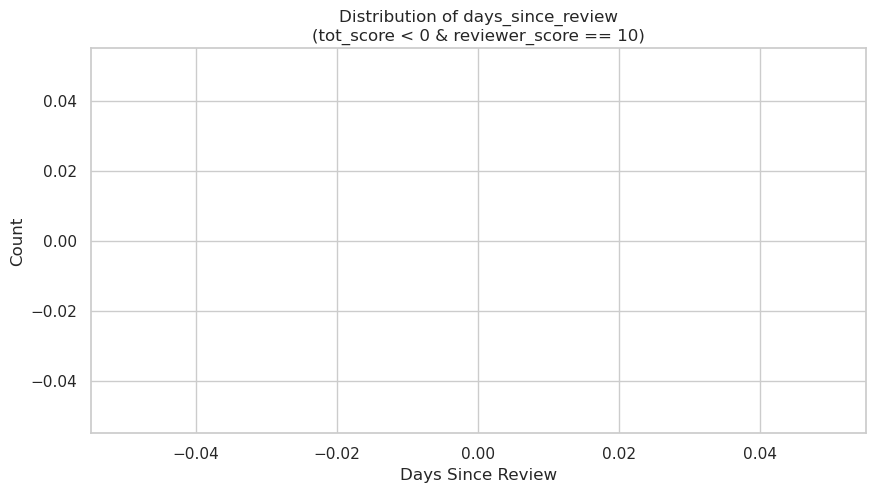

In [88]:

subset = n_hotels[
   ( (n_hotels['negative_score'] == -1) &
    (n_hotels['positive_score'] == -1) &
    (n_hotels['reviewer_score'] == 10))
]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(subset['review_date'], bins=30, kde=True)
plt.title("Distribution of days_since_review\n(tot_score < 0 & reviewer_score == 10)")
plt.xlabel("Days Since Review")
plt.ylabel("Count")
plt.show()


In [89]:
sampled_hotels.isna().sum().sum()

0

In [90]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'neg_word_count_log', 'pos_word_count_log', 'empty_positive_flag',
       'empty_negative_flag', 'pos_word_count_bin', 'neg_word_count_bin',
       'pos_word_count_bin2', 'neg_word_count_bin2', 'p_empty_flag',
       'n_empty_flag', 'both_empty_flag', 'p_absolute_flag', 'n_absolute_flag',
       'p_everything_flag', 'n_everything_flag', 'positive_score',
       'negative_score', 'tot_score', 'positive_score_e', 'negative_score_e',
       'satisfaction_flag', 'positive_word_%', 'negative_word_%', 'pos_vs_neg',
       'pos_vs_neg2', 'satisfaction_flag1', 'satisfact

In [91]:
#  difference between positive and negative word counts
#n_hotels['pos_vs_neg'] = ( 
#    n_hotels['positive_score']*n_hotels['positive_word_%'] - 
#    n_hotels['negative_score'] *n_hotels['negative_word_%'])

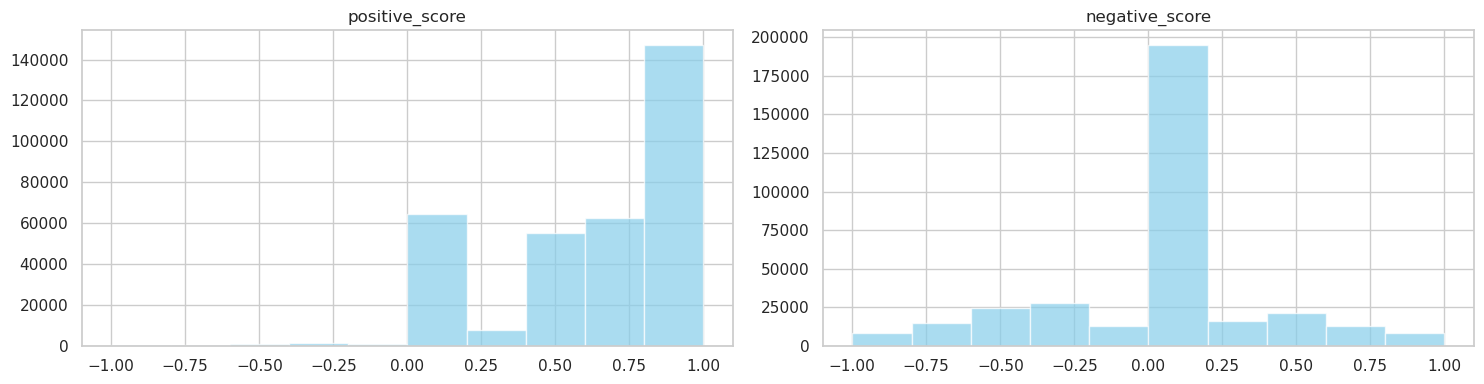

In [92]:
sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()

plt.figure(figsize=(15, 4))
i=1
for  col in ['positive_score', 'negative_score']:
    plt.subplot(1, 2, i)
    plt.hist(x=sampled_hotels[col], color='skyblue', alpha=0.7)
    plt.title(col)
    i+=1
plt.tight_layout()
plt.show()

In [93]:
n_hotels['active_reviewer_flag'] = pd.cut(
    data['total_number_of_reviews_reviewer_has_given'],
    bins=[ -float('inf'),  15,  float('inf')],
    labels=[ 0, 1 ]
).astype(int)

In [94]:
"""top_pos = get_top_words(n_hotels['positive_review'], n=20)
top_neg = get_top_words(n_hotels['negative_review'], n=20)

print(" Top Positive Words:")
print(pd.DataFrame(top_pos, columns=['Word', 'Count']))

print("\n Top Negative Words:")
print(pd.DataFrame(top_neg, columns=['Word', 'Count']))
"""

'top_pos = get_top_words(n_hotels[\'positive_review\'], n=20)\ntop_neg = get_top_words(n_hotels[\'negative_review\'], n=20)\n\nprint(" Top Positive Words:")\nprint(pd.DataFrame(top_pos, columns=[\'Word\', \'Count\']))\n\nprint("\n Top Negative Words:")\nprint(pd.DataFrame(top_neg, columns=[\'Word\', \'Count\']))\n'

In [95]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'neg_word_count_log', 'pos_word_count_log', 'empty_positive_flag',
       'empty_negative_flag', 'pos_word_count_bin', 'neg_word_count_bin',
       'pos_word_count_bin2', 'neg_word_count_bin2', 'p_empty_flag',
       'n_empty_flag', 'both_empty_flag', 'p_absolute_flag', 'n_absolute_flag',
       'p_everything_flag', 'n_everything_flag', 'positive_score',
       'negative_score', 'tot_score', 'positive_score_e', 'negative_score_e',
       'satisfaction_flag', 'positive_word_%', 'negative_word_%', 'pos_vs_neg',
       'pos_vs_neg2', 'satisfaction_flag1', 'satisfact

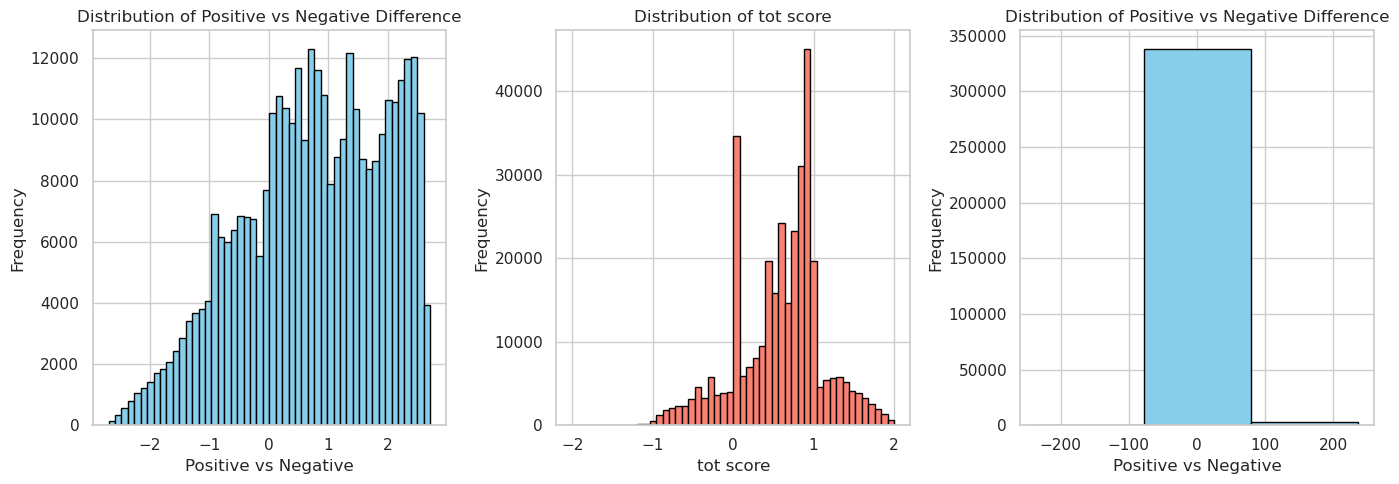

In [96]:

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()

# --- Left plot: difference ---
axes[0].hist(sampled_hotels['pos_vs_neg'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Positive vs Negative Difference')
axes[0].set_xlabel('Positive vs Negative')
axes[0].set_ylabel('Frequency')

# --- Right plot: ratio ---
axes[1].hist(sampled_hotels['tot_score'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of tot score')
axes[1].set_xlabel('tot score')
axes[1].set_ylabel('Frequency')

# --- Left plot: difference ---
axes[2].hist(sampled_hotels['pos_vs_neg2'], bins=3, color='skyblue', edgecolor='black')
axes[2].set_title('Distribution of Positive vs Negative Difference')
axes[2].set_xlabel('Positive vs Negative')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

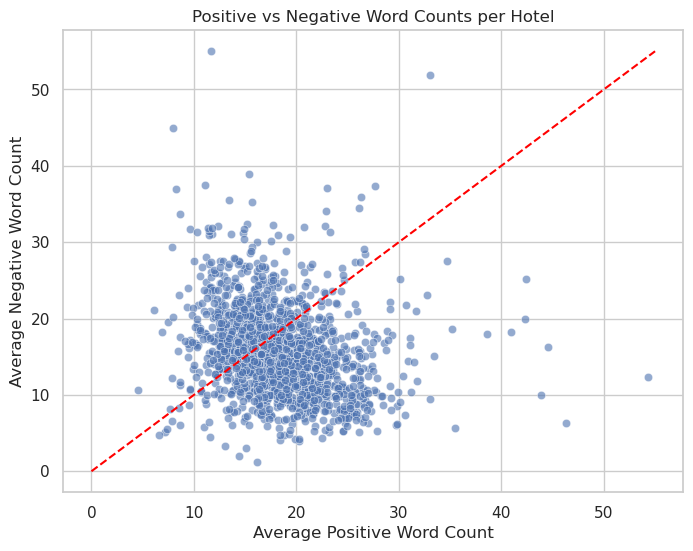

In [97]:
# Aggregate word counts and sentiment scores per hotel
hotel_review_stats = (
    sampled_hotels.groupby('hotel_name', as_index=False)
    .agg({
        'review_total_positive_word_counts': 'mean',
        'review_total_negative_word_counts': 'mean',
        'positive_score': 'mean',
        'negative_score': 'mean'
    })
    .rename(columns={
        'review_total_positive_word_counts': 'avg_positive_words',
        'review_total_negative_word_counts': 'avg_negative_words',
        'positive_score': 'avg_positive_score',
        'negative_score': 'avg_negative_score'
    })
)


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=hotel_review_stats,
    x='avg_positive_words',
    y='avg_negative_words',
    alpha=0.6
)
plt.title('Positive vs Negative Word Counts per Hotel')
plt.xlabel('Average Positive Word Count')
plt.ylabel('Average Negative Word Count')
plt.plot([0, hotel_review_stats[['avg_positive_words','avg_negative_words']].max().max()],
         [0, hotel_review_stats[['avg_positive_words','avg_negative_words']].max().max()],
         color='red', linestyle='--')
plt.show()


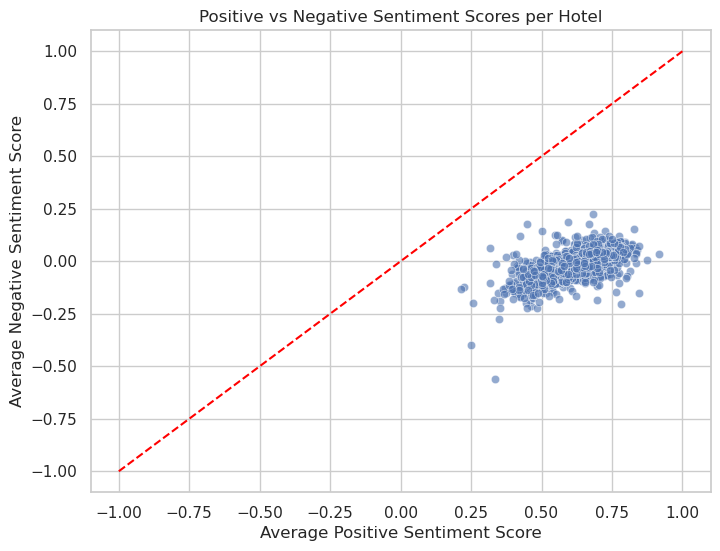

In [98]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=hotel_review_stats,
    x='avg_positive_score',
    y='avg_negative_score',
    alpha=0.6
)
plt.title('Positive vs Negative Sentiment Scores per Hotel')
plt.xlabel('Average Positive Sentiment Score')
plt.ylabel('Average Negative Sentiment Score')
plt.plot([-1, 1], [-1, 1], color='red', linestyle='--')
plt.show()


In [99]:
hotel_review_stats['sentiment_gap'] = hotel_review_stats['avg_positive_score'] - hotel_review_stats['avg_negative_score']
hotel_review_stats.nlargest(5, 'sentiment_gap')[['hotel_name', 'sentiment_gap']]


hotel_name  sentiment_gap
1209       Room Mate Gerard       0.995089
760   Hotel Seven One Seven       0.985580
766            Hotel Square       0.909500
852      Kube Hotel Ice Bar       0.894393
1012                MiHotel       0.882709

## Date-Based Features

In [100]:

# =====================================================
#  Transform Days Since Review
# =====================================================

# Convert review date to datetime format
# Remove non-digit characters and convert to int
# Convert all values to string, extract digits, then convert to int
n_hotels['days_since_review'] = (
    n_hotels['days_since_review']
    .astype(str)                 # ensure all values are strings
    .str.extract(r'(\d+)')       # extract numeric part
    .astype(int)                 # convert to integer
)


#  Ensure review_date is a datetime object
n_hotels['review_date'] = pd.to_datetime(n_hotels['review_date'], errors='coerce')

# Optional: extract year/month/season for analysis
n_hotels['travel_year'] = n_hotels['review_date'].dt.year
n_hotels['travel_month'] = n_hotels['review_date'].dt.month

In [101]:
# ==========================================
#  Recency weight
# ==========================================
#n_hotels['recency_weight'] = 1 / np.log1p( n_hotels['days_since_review'] + 1 )



n_hotels['old_review'] = n_hotels['days_since_review'].apply(lambda x: 1 if x > 650 else 0)
n_hotels['old_review'].value_counts()

cohen_flag_check(n_hotels, ['old_review'], score_col='reviewer_score')

n_hotels['days_since_review'].describe()

Flag: old_review
  Cohen's d: -0.0786 (negligible)



count    470470.000000
mean        354.952095
std         208.980905
min           0.000000
25%         176.000000
50%         354.000000
75%         528.000000
max         730.000000
Name: days_since_review, dtype: float64

In [102]:
n_hotels['hotel_name'].nunique()
hotel_avg_scores = (
    n_hotels.groupby('hotel_name')['average_score']
    .mean()
    .sort_values(ascending=False)
)

best_hotel = hotel_avg_scores.index[0]
best_score = hotel_avg_scores.iloc[0]

print("Hotel with highest average score:")
print(best_hotel, "→", best_score)


Hotel with highest average score:
Ritz Paris → 9.8


In [103]:
n_hotels['total_feedback'] = (
    n_hotels['total_number_of_reviews'] + 
    n_hotels['additional_number_of_scoring']
)

top_hotels_by_feedback = (
    n_hotels.groupby('hotel_name')['total_feedback']
    .sum()
    .sort_values(ascending=False)
)

print("Top hotels by total feedback:")
print(top_hotels_by_feedback.head(10))


Top hotels by total feedback:
hotel_name
Park Plaza Westminster Bridge London                 53876745
Britannia International Hotel Canary Wharf           52544120
Strand Palace Hotel                                  45598176
Hotel Da Vinci                                       30227280
Copthorne Tara Hotel London Kensington               29390504
DoubleTree by Hilton Hotel London Tower of London    26857523
Grand Royale London Hyde Park                        21595132
Hilton London Metropole                              20368034
Holiday Inn London Kensington                        17600341
Millennium Gloucester Hotel London                   16856670
Name: total_feedback, dtype: int64



Cluster 1:
['Hotel Plaza Athenee Paris', 'Splendide Royal Paris']

Cluster 2:
['41', 'Drawing Hotel', 'Egerton House', 'H tel de La Tamise Esprit de France', 'Haymarket Hotel', 'Hotel Dupond Smith', 'Hotel J ger', 'Hotel The Peninsula Paris', 'Le Narcisse Blanc Spa', 'Mandarin Oriental Barcelona', 'Mandarin Oriental Milan', 'Palais Coburg Residenz', 'Ritz Paris', 'The Goring']

Cluster 3:
['Charlotte Street Hotel', 'Claridge s', 'Excelsior Hotel Gallia Luxury Collection Hotel', 'H tel Fabric', 'H10 Casa Mimosa 4 Sup', 'Hollmann Beletage Design Boutique', 'Hotel Casa Camper', 'Hotel Eiffel Blomet', 'Hotel Imperial A Luxury Collection Hotel', 'Hotel Monge', 'Hotel Palace GL', 'Hotel Sacher Wien', 'Hotel Sans Souci Wien', 'Hotel The Serras', 'Intercontinental London The O2', 'La Chambre du Marais', 'Nolinski Paris', 'Relais Christine', 'Rosewood London', 'Taj 51 Buckingham Gate Suites and Residences', 'The Beaumont Hotel', 'The One Barcelona GL', 'The Ritz London', 'The Toren', 'The Well

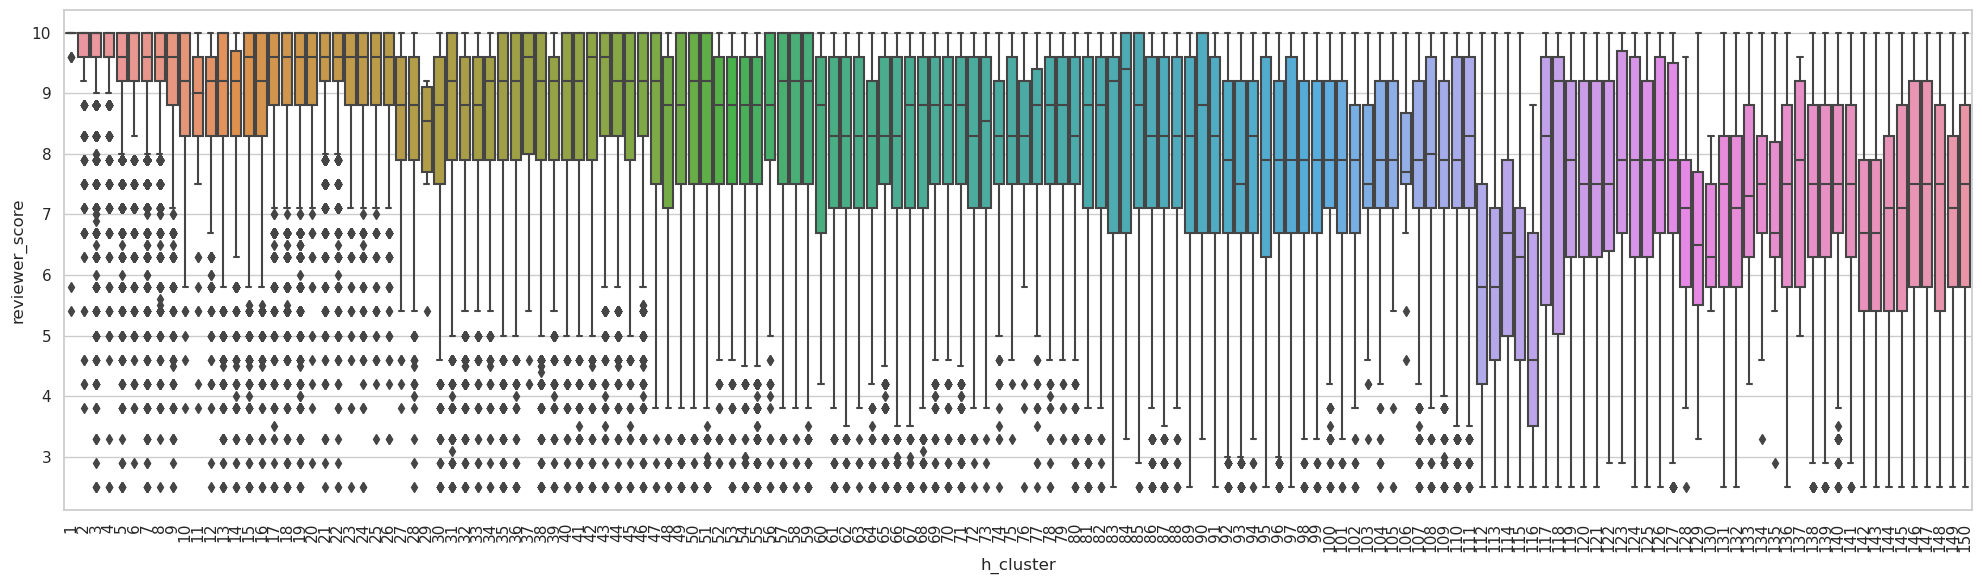

In [104]:

top_n = 1500
hotels = (
    n_hotels['hotel_name']
    .value_counts()
    .head(top_n)
    .index
)

sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()

# Remove outliers before clustering
df_sub = remove_outliers_iqr(
    sampled_hotels,
    group_col='hotel_name',
    value_col='reviewer_score'
)


df_sub = df_sub[df_sub['hotel_name'].isin(hotels)]



# ======================================================
# 2. Compute quantile vectors
# ======================================================

qs = np.linspace(0.05, 0.95, 10)

quantile_vectors = (
    df_sub.groupby('hotel_name')['reviewer_score']
          .quantile(qs)
          .unstack()     # => nationality × 10 quantiles
)

# ======================================================
# 3. Hierarchical clustering (Ward)
# ======================================================

Z = linkage(quantile_vectors, method='ward')

'''# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=quantile_vectors.index, leaf_rotation=90)
plt.title("Clustering Hotels by Reviewer Score Distribution")
plt.show()'''

# ======================================================
# 4. Cut dendrogram into clusters
# ======================================================

num_clusters = 150
quantile_vectors['h_cluster'] = fcluster(Z, num_clusters, criterion='maxclust').astype('int64')

# Inspect clusters
for c, group in quantile_vectors.groupby('h_cluster').groups.items():
    print(f"\nCluster {c}:")
    print(list(group))

# ======================================================
# 5. Make cluster lookup table
# ======================================================

hotel_clusters = quantile_vectors['h_cluster'].reset_index()
hotel_clusters.columns = ['hotel_name', 'h_cluster']

# ======================================================
# 6. Merge cluster labels into main dataset
# ======================================================

n_hotels = n_hotels.merge(
    hotel_clusters,
    how='left',
    on='hotel_name'
)

# ======================================================
# 7. Compute cluster-level statistics
# ======================================================

cluster_stats = (
    n_hotels.groupby('h_cluster')['reviewer_score']
    .agg(
        hotel_mean_score='mean',
        hotel_median_score='median',
        hotel_std_score='std'
    )
    .reset_index()
)

# Merge cluster stats back
n_hotels = n_hotels.merge(cluster_stats, on='h_cluster', how='left')

# ======================================================
# 8. Optional: Plot cluster boxplots
# ======================================================
plt.figure(figsize=(20, 6))   # ← wider figure (increase width here)

sampled_hotels = n_hotels[n_hotels['sample'] == 1]  # only training data
sns.boxplot(
    data=sampled_hotels[sampled_hotels['h_cluster'].notna()],
    x='h_cluster',
    y='reviewer_score'
)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [105]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       ...
       'something_flag', 'active_reviewer_flag', 'travel_year', 'travel_month',
       'old_review', 'total_feedback', 'h_cluster', 'hotel_mean_score',
       'hotel_median_score', 'hotel_std_score'],
      dtype='object', length=105)

In [106]:
"""
# 1. Find the 5 most popular hotels (by review count)
top_hotels = (
    n_hotels['hotel_name']
    .value_counts()
    .head(30)
    .index
)

# Filter only these hotels
top_data = n_hotels[n_hotels['hotel_name'].isin(top_hotels)]

# 2. Plot distributions
plt.figure(figsize=(18, 10))

for i, hotel in enumerate(top_hotels, 1):
    plt.subplot(5, 6, i)
    
    sns.scatterplot(
        data=top_data[top_data['hotel_name'] == hotel],
        x='days_since_review',
        y='reviewer_score',
        alpha=0.4,
        label="reviewer_score"
    )
    sns.scatterplot(
        data=top_data[top_data['hotel_name'] == hotel],
        x='days_since_review',
        y='average_score',
        alpha=0.4
    )


    plt.title(f"{hotel}\n(days_since_review vs average_score)")
    plt.xlabel("Days Since Review")
    plt.ylabel("Average Score")
    plt.ylim(0, 10)

plt.tight_layout()
plt.show()"""

'\n# 1. Find the 5 most popular hotels (by review count)\ntop_hotels = (\n    n_hotels[\'hotel_name\']\n    .value_counts()\n    .head(30)\n    .index\n)\n\n# Filter only these hotels\ntop_data = n_hotels[n_hotels[\'hotel_name\'].isin(top_hotels)]\n\n# 2. Plot distributions\nplt.figure(figsize=(18, 10))\n\nfor i, hotel in enumerate(top_hotels, 1):\n    plt.subplot(5, 6, i)\n    \n    sns.scatterplot(\n        data=top_data[top_data[\'hotel_name\'] == hotel],\n        x=\'days_since_review\',\n        y=\'reviewer_score\',\n        alpha=0.4,\n        label="reviewer_score"\n    )\n    sns.scatterplot(\n        data=top_data[top_data[\'hotel_name\'] == hotel],\n        x=\'days_since_review\',\n        y=\'average_score\',\n        alpha=0.4\n    )\n\n\n    plt.title(f"{hotel}\n(days_since_review vs average_score)")\n    plt.xlabel("Days Since Review")\n    plt.ylabel("Average Score")\n    plt.ylim(0, 10)\n\nplt.tight_layout()\nplt.show()'

In [107]:
"""import pandas as pd



# Group by hotel
hotel_stats = sampled_hotels.groupby('hotel_name').agg(
    mean_reviewer_score=('reviewer_score', 'mean'),
    std_reviewer_score=('reviewer_score', 'std'),
    average_score=('average_score', 'first'),  # assuming average_score is repeated per hotel
    total_reviews=('reviewer_score', 'count')
).reset_index()


#  Hotels where average_score differs a lot from mean reviewer_score
# Compute absolute difference
hotel_stats['score_diff'] = abs(hotel_stats['average_score'] - hotel_stats['mean_reviewer_score'])
'''
# Let's pick hotels with large difference, e.g., diff > 1 (you can adjust threshold)
suspicious_hotels = hotel_stats[hotel_stats['score_diff'] > 0 ].sort_values('score_diff', ascending=False)
suspicious_hotel_names = set(suspicious_hotels['hotel_name'])
# Add suspicious_flag column
#n_hotels['suspicious_flag'] = n_hotels['hotel_name'].apply(lambda x: 1 if x in suspicious_hotel_names else 0)


# Create a dictionary mapping hotel_name -> mean_reviewer_score
hotel_mean_score_dict = dict(zip(hotel_stats['hotel_name'], hotel_stats['mean_reviewer_score']))
hotel_score_diff_dict = dict(zip(hotel_stats['hotel_name'], hotel_stats['score_diff']))

# Create the new column
n_hotels['mean_reviewer_score'] = n_hotels.apply(
    lambda row: hotel_mean_score_dict.get(row['hotel_name'], row['average_score']),
    axis=1
)
n_hotels['diff_reviewer_score'] = n_hotels.apply(
    lambda row: hotel_score_diff_dict.get(row['hotel_name'], 1),
    axis=1
)


print("\nHotels with suspicious average_score:")
print(suspicious_hotels[['hotel_name', 'average_score', 'mean_reviewer_score', 'score_diff']])



#  Hotels with narrow distribution of reviewer_score
# Let's consider "narrow" as std deviation < 1 (you can adjust threshold)
narrow_distribution_hotels = hotel_stats[hotel_stats['std_reviewer_score'] < 0.5].sort_values('std_reviewer_score')
narrow_hotel_names = set(narrow_distribution_hotels['hotel_name'])
# Add good_hotel flag
n_hotels['good_hotel'] = n_hotels['hotel_name'].apply(
    lambda x: 1 if x in narrow_hotel_names and x not in suspicious_hotel_names else 0
)
print("Hotels with narrow reviewer score distribution:")
print(narrow_distribution_hotels[['hotel_name', 'std_reviewer_score', 'total_reviews']])
'''


# -----------------------------
# One-block feature creation
# -----------------------------

# Step 1: create dictionaries for fast lookup
mean_dict = dict(zip(hotel_stats['hotel_name'], hotel_stats['mean_reviewer_score']))
diff_dict = dict(zip(hotel_stats['hotel_name'], hotel_stats['score_diff']))

# Step 2: create mask for hotels existing in hotel_stats
mask = n_hotels['hotel_name'].isin(hotel_stats['hotel_name'])

# Step 3: fill features using mask and dictionaries
n_hotels.loc[mask, 'mean_reviewer_score'] = n_hotels.loc[mask, 'hotel_name'].map(mean_dict)
n_hotels.loc[mask, 'diff_reviewer_score'] = n_hotels.loc[mask, 'hotel_name'].map(diff_dict)

# Step 4: fill fallback values for hotels not in hotel_stats
n_hotels['mean_reviewer_score'] = n_hotels['mean_reviewer_score'].fillna(n_hotels['average_score'])
n_hotels['diff_reviewer_score'] = n_hotels['diff_reviewer_score'].fillna( n_hotels['diff_reviewer_score'].mean() )
"""

'import pandas as pd\n\n\n\n# Group by hotel\nhotel_stats = sampled_hotels.groupby(\'hotel_name\').agg(\n    mean_reviewer_score=(\'reviewer_score\', \'mean\'),\n    std_reviewer_score=(\'reviewer_score\', \'std\'),\n    average_score=(\'average_score\', \'first\'),  # assuming average_score is repeated per hotel\n    total_reviews=(\'reviewer_score\', \'count\')\n).reset_index()\n\n\n#  Hotels where average_score differs a lot from mean reviewer_score\n# Compute absolute difference\nhotel_stats[\'score_diff\'] = abs(hotel_stats[\'average_score\'] - hotel_stats[\'mean_reviewer_score\'])\n\'\'\'\n# Let\'s pick hotels with large difference, e.g., diff > 1 (you can adjust threshold)\nsuspicious_hotels = hotel_stats[hotel_stats[\'score_diff\'] > 0 ].sort_values(\'score_diff\', ascending=False)\nsuspicious_hotel_names = set(suspicious_hotels[\'hotel_name\'])\n# Add suspicious_flag column\n#n_hotels[\'suspicious_flag\'] = n_hotels[\'hotel_name\'].apply(lambda x: 1 if x in suspicious_hotel_na

In [108]:
# Let's pick hotels with large difference, e.g., diff > 1 (you can adjust threshold)
#suspicious_hotels = hotel_stats[hotel_stats['score_diff'] > 0.9 ].sort_values('score_diff', ascending=False)
#suspicious_hotel_names = set(suspicious_hotels['hotel_name'])
#suspicious_hotel_names


#{'Holiday Inn Paris Montparnasse Pasteur', 'Kube Hotel Ice Bar'}

In [109]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       ...
       'something_flag', 'active_reviewer_flag', 'travel_year', 'travel_month',
       'old_review', 'total_feedback', 'h_cluster', 'hotel_mean_score',
       'hotel_median_score', 'hotel_std_score'],
      dtype='object', length=105)

In [110]:
sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()

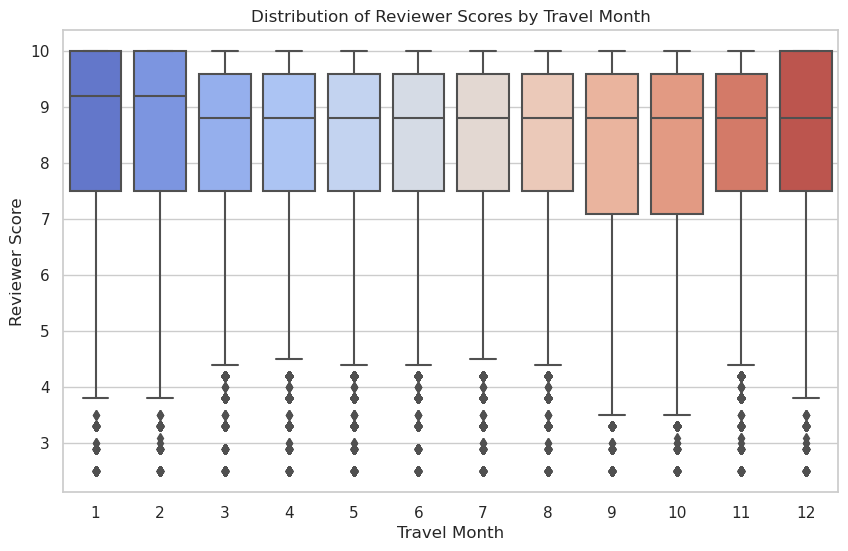

In [111]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=sampled_hotels,
    x='travel_month',
    y='reviewer_score',
    palette='coolwarm'
)
plt.title("Distribution of Reviewer Scores by Travel Month")
plt.xlabel("Travel Month")
plt.ylabel("Reviewer Score")
plt.show()


In [112]:
n_hotels.shape

(470470, 105)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_21/320892210.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


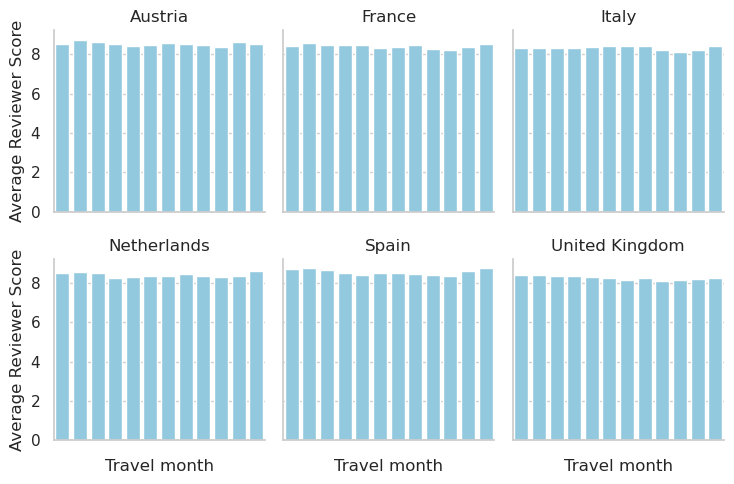

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

sampled_hotels = n_hotels[n_hotels['sample'] == 1] 
# Bin distance globally
#ampled_hotels['distance_bin'] = pd.cut(sampled_hotels['distance_from_city_center'], bins=19)

# Precompute averages
avg_scores_binned = (
    sampled_hotels.groupby(['hotel_country', 'travel_month'])['reviewer_score']
    .mean()
    .reset_index()
)

# FacetGrid for multiple plots
g = sns.FacetGrid(avg_scores_binned, col='hotel_country', col_wrap=3, height=2.5, sharey=True)
g.map_dataframe(sns.barplot, x='travel_month', y='reviewer_score', color='skyblue')
g.set_xticklabels(rotation=90)
g.set_axis_labels("Travel month", "Average Reviewer Score")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()

In [114]:
"""
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'winter'
    elif date.month in [3, 4, 5]:
        return 'spring'
    elif date.month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'
# Create the 'season' column from travel_date
n_hotels['season'] = n_hotels['review_date'].apply(get_season)


import matplotlib.pyplot as plt
import seaborn as sns

# Apply your function to both date columns
#travel_season = n_hotels['travel_date'].apply(get_season)
review_season = n_hotels['review_date'].apply(get_season)

# Create the figure with two subplots
fig, ax = plt.subplots(figsize=(6, 6))

# Common color palette (consistent across both)
palette = sns.color_palette('coolwarm', 4)
season_order = ['winter', 'spring', 'summer', 'autumn']

# Right: Review date season pie chart
review_season.value_counts()[season_order].plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=palette,
    ax=ax
)
ax.set_title('Percentage of Reviews by Season')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

# ==========================================
#  Season encoded (cyclical transformation)
# sin/cos encoding helps models understand seasonality
# ==========================================
#season_map = {'spring': 0, 'summer': 1, 'autumn': 2, 'winter': 3}
#n_hotels['season_num'] = n_hotels['season'].str.lower().map(season_map)

#n_hotels['season_sin'] = np.sin(2 * np.pi * n_hotels['season_num'] / 4)
#n_hotels['season_cos'] = np.cos(2 * np.pi * n_hotels['season_num'] / 4)"""

"\ndef get_season(date):\n    if date.month in [12, 1, 2]:\n        return 'winter'\n    elif date.month in [3, 4, 5]:\n        return 'spring'\n    elif date.month in [6, 7, 8]:\n        return 'summer'\n    else:\n        return 'autumn'\n# Create the 'season' column from travel_date\nn_hotels['season'] = n_hotels['review_date'].apply(get_season)\n\n\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Apply your function to both date columns\n#travel_season = n_hotels['travel_date'].apply(get_season)\nreview_season = n_hotels['review_date'].apply(get_season)\n\n# Create the figure with two subplots\nfig, ax = plt.subplots(figsize=(6, 6))\n\n# Common color palette (consistent across both)\npalette = sns.color_palette('coolwarm', 4)\nseason_order = ['winter', 'spring', 'summer', 'autumn']\n\n# Right: Review date season pie chart\nreview_season.value_counts()[season_order].plot(\n    kind='pie',\n    autopct='%1.1f%%',\n    startangle=90,\n    colors=palette,\n    ax=ax\n)\nax.

In [115]:
def get_first_months(date):
    if date.month in [ 1, 2 ]:
        return 1
    else:
        return 0
# Create the 'season' column from travel_date
n_hotels['first_months_flag'] = n_hotels['review_date'].apply(get_first_months)

In [116]:
"""n_hotels['country_season_freq'] = (
    n_hotels.groupby(['hotel_country', 'season']).transform('size')
)

n_hotels['country_season'] = (
    n_hotels['hotel_country'].astype(str) + "_" +
    n_hotels['season'].astype(str)
)

n_hotels = pd.get_dummies(n_hotels, columns=['country_season'])




import seaborn as sns
import matplotlib.pyplot as plt

# Define season order
season_order = ['winter', 'spring', 'summer', 'autumn']

# Limit to top N countries (optional, to keep it readable)
sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()
top_countries = sampled_hotels['hotel_country'].value_counts().index
subset = sampled_hotels[sampled_hotels['hotel_country'].isin(top_countries)]

# Faceted violin plot
g = sns.FacetGrid(subset, col='hotel_country', col_wrap=3, height=4, sharey=True)
g.map_dataframe(
    sns.boxplot,
    x='season',
    y='reviewer_score',
    order=season_order,
    palette='coolwarm'
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Travel Season", "Reviewer Score")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Reviewer Score by Season and Country (sample==1)", fontsize=14)
plt.show()"""

'n_hotels[\'country_season_freq\'] = (\n    n_hotels.groupby([\'hotel_country\', \'season\']).transform(\'size\')\n)\n\nn_hotels[\'country_season\'] = (\n    n_hotels[\'hotel_country\'].astype(str) + "_" +\n    n_hotels[\'season\'].astype(str)\n)\n\nn_hotels = pd.get_dummies(n_hotels, columns=[\'country_season\'])\n\n\n\n\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Define season order\nseason_order = [\'winter\', \'spring\', \'summer\', \'autumn\']\n\n# Limit to top N countries (optional, to keep it readable)\nsampled_hotels = n_hotels[n_hotels[\'sample\'] == 1].copy()\ntop_countries = sampled_hotels[\'hotel_country\'].value_counts().index\nsubset = sampled_hotels[sampled_hotels[\'hotel_country\'].isin(top_countries)]\n\n# Faceted violin plot\ng = sns.FacetGrid(subset, col=\'hotel_country\', col_wrap=3, height=4, sharey=True)\ng.map_dataframe(\n    sns.boxplot,\n    x=\'season\',\n    y=\'reviewer_score\',\n    order=season_order,\n    palette=\'coolwarm\'\n)\ng.set_ti

In [117]:
"""

combo_stats = (
    n_hotels.groupby(['hotel_country', 'travel_season'])['reviewer_score']
    .agg(['mean', 'median', 'count', 'std'])
    .reset_index()
)

combo_stats.head()

n_hotels = n_hotels.merge(
    combo_stats[['hotel_country', 'travel_season', 'mean']],
    on=['hotel_country', 'travel_season'],
    how='left'
)

n_hotels.rename(columns={'mean': 'reviewer_score_by_country_season'}, inplace=True)


n_hotels['reviewer_score_dev'] = (
    n_hotels['reviewer_score'] - n_hotels['reviewer_score_by_country_season']
)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(
    combo_stats.pivot('hotel_country', 'travel_season', 'mean'),
    annot=True, fmt=".2f", cmap="coolwarm"
)
plt.title("Mean Reviewer Score by Country and Season")
plt.show()"""

'\n\ncombo_stats = (\n    n_hotels.groupby([\'hotel_country\', \'travel_season\'])[\'reviewer_score\']\n    .agg([\'mean\', \'median\', \'count\', \'std\'])\n    .reset_index()\n)\n\ncombo_stats.head()\n\nn_hotels = n_hotels.merge(\n    combo_stats[[\'hotel_country\', \'travel_season\', \'mean\']],\n    on=[\'hotel_country\', \'travel_season\'],\n    how=\'left\'\n)\n\nn_hotels.rename(columns={\'mean\': \'reviewer_score_by_country_season\'}, inplace=True)\n\n\nn_hotels[\'reviewer_score_dev\'] = (\n    n_hotels[\'reviewer_score\'] - n_hotels[\'reviewer_score_by_country_season\']\n)\n\n\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(12,6))\nsns.heatmap(\n    combo_stats.pivot(\'hotel_country\', \'travel_season\', \'mean\'),\n    annot=True, fmt=".2f", cmap="coolwarm"\n)\nplt.title("Mean Reviewer Score by Country and Season")\nplt.show()'

## More features!

In [118]:
# ==========================================
#  Popularity and adjusted score features
# ==========================================


#n_hotels['popularity_index'] = ( n_hotels['average_score'] 
#                                * np.log1p(n_hotels['total_number_of_reviews']) )

n_hotels['total_scoring'] =  ( n_hotels['total_number_of_reviews'] + n_hotels['additional_number_of_scoring'] )

n_hotels['add_scoreing_%'] = ( n_hotels['additional_number_of_scoring'] / ( n_hotels['total_scoring'] + 1 ) )

n_hotels['tot_reviews_%'] = ( n_hotels['total_number_of_reviews'] / ( n_hotels['total_scoring'] + 1 ) )

n_hotels['tot_rev_vs_add_scoring'] = ( n_hotels['total_number_of_reviews'] / (n_hotels['additional_number_of_scoring'] + 1) )

n_hotels['days_since_review_e'] = np.exp(-n_hotels['days_since_review'])

cols_to_log = [
    'additional_number_of_scoring',
    'total_feedback',
    'total_number_of_reviews',
    'total_scoring'
]

for col in cols_to_log:
    new_col = col + '_log'
    n_hotels[new_col] = np.log1p(n_hotels[col])

In [119]:
n_hotels[cols_to_log].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470470 entries, 0 to 470469
Data columns (total 4 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   additional_number_of_scoring  470470 non-null  int64
 1   total_feedback                470470 non-null  int64
 2   total_number_of_reviews       470470 non-null  int64
 3   total_scoring                 470470 non-null  int64
dtypes: int64(4)
memory usage: 17.9 MB


In [120]:
# Reviewer trust score based on number of reviews given
# 
#def reviewer_trust_sigmoid(num_reviews):
#    increase = 1 / (1 + np.exp(-0.2 * (num_reviews - 5)))      # grows after 5
#    decrease = 1 - 1 / (1 + np.exp(-0.05 * (num_reviews - 30)))  # drops after 80
#    return increase * decrease
#n_hotels['reviewer_trust_score'] = n_hotels['total_number_of_reviews_reviewer_has_given'].apply(reviewer_trust_sigmoid)

# Drop the original count column 
#n_hotels.drop('total_number_of_reviews_reviewer_has_given', axis=1, inplace=True)

In [121]:
'''x = np.arange(0, 400)
#plt.plot(x, [reviewer_trust(i) for i in x], label="Gaussian")
#plt.plot(x, [reviewer_trust_piecewise(i) for i in x], label="Piecewise")
plt.plot(x, [reviewer_trust_sigmoid(i) for i in x], label="Sigmoid Combo")
plt.xlabel("Total Reviews by Reviewer")
plt.ylabel("Trust Weight")
plt.legend()
plt.title("Reviewer Trust Function")
plt.show()'''

'x = np.arange(0, 400)\n#plt.plot(x, [reviewer_trust(i) for i in x], label="Gaussian")\n#plt.plot(x, [reviewer_trust_piecewise(i) for i in x], label="Piecewise")\nplt.plot(x, [reviewer_trust_sigmoid(i) for i in x], label="Sigmoid Combo")\nplt.xlabel("Total Reviews by Reviewer")\nplt.ylabel("Trust Weight")\nplt.legend()\nplt.title("Reviewer Trust Function")\nplt.show()'

Strong features kept: 47
Weak features removed: 54


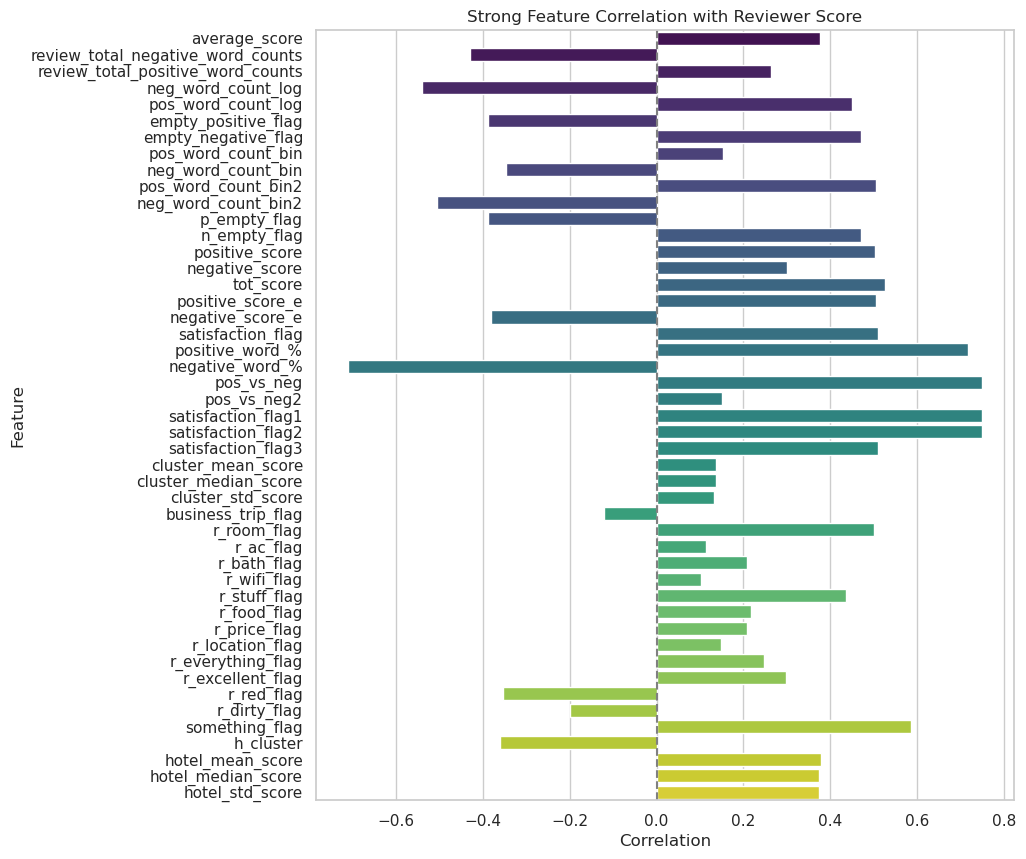

In [122]:
# Select only numerical columns
my_hotels = n_hotels.select_dtypes(include=['number']).copy()
sampled_hotels = my_hotels[my_hotels['sample'] == 1]

# Correlation matrix
corr = sampled_hotels.corr()

# Correlation with reviewer_score
corr_reviewer = corr['reviewer_score'].drop('reviewer_score')

threshold = 0.1

ok_flags = corr_reviewer[ corr_reviewer.abs() >= threshold ].index.tolist()
weak_flags = corr_reviewer[ corr_reviewer.abs() < threshold ].index.tolist()

print(f"Strong features kept: {len(ok_flags)}")
print(f"Weak features removed: {len(weak_flags)}")

# Remove weak flags from BOTH my_hotels and n_hotels
my_hotels.drop(columns=weak_flags, inplace=True)

'''for col in weak_flags:
    if col in n_hotels.columns:
        n_hotels.drop(columns=col, inplace=True)'''

# UPDATED sample after dropping
sampled_hotels = my_hotels[my_hotels['sample'] == 1]

# Plot only strong correlations
plt.figure(figsize=(9, 10))
sns.barplot(
    x=corr_reviewer.loc[ok_flags].values,
    y=corr_reviewer.loc[ok_flags].index,
    palette="viridis"
)
plt.title("Strong Feature Correlation with Reviewer Score")
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()


# Exploratory data analysis (EDA)
Before feeding our cleaned dataset into a machine learning model, it’s crucial to analyze it and understand the distributions, potential outliers, and correlations. This step helps avoid garbage-in, garbage-out scenarios.

In [123]:
# Check missing values
missing = n_hotels.isnull().sum()
missing = missing[missing > 0]
print("Columns with missing values:\n", missing)

object_cols = n_hotels.select_dtypes(include='object')
print(f"Number of object columns: {object_cols.shape[1]}")
print(object_cols.columns.tolist())

#n_hotels = n_hotels.drop(columns=n_hotels.select_dtypes(include=['object', 'datetime64[ns]']).columns)

Columns with missing values:
 Series([], dtype: int64)
Number of object columns: 10
['hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'hotel_country', 'hotel_city', 'hotel_continent', 'reviewer_continent']


In [124]:
n_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470470 entries, 0 to 470469
Columns: 115 entries, hotel_address to total_scoring_log
dtypes: category(1), datetime64[ns](1), float64(38), int64(59), object(10), uint8(6)
memory usage: 394.4+ MB


## Basic statistics

/tmp/ipykernel_21/4223819920.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flag_data['diff_score'] = flag_data['reviewer_score'] - flag_data['average_score']


🔹 Removing weak flag columns:
[]


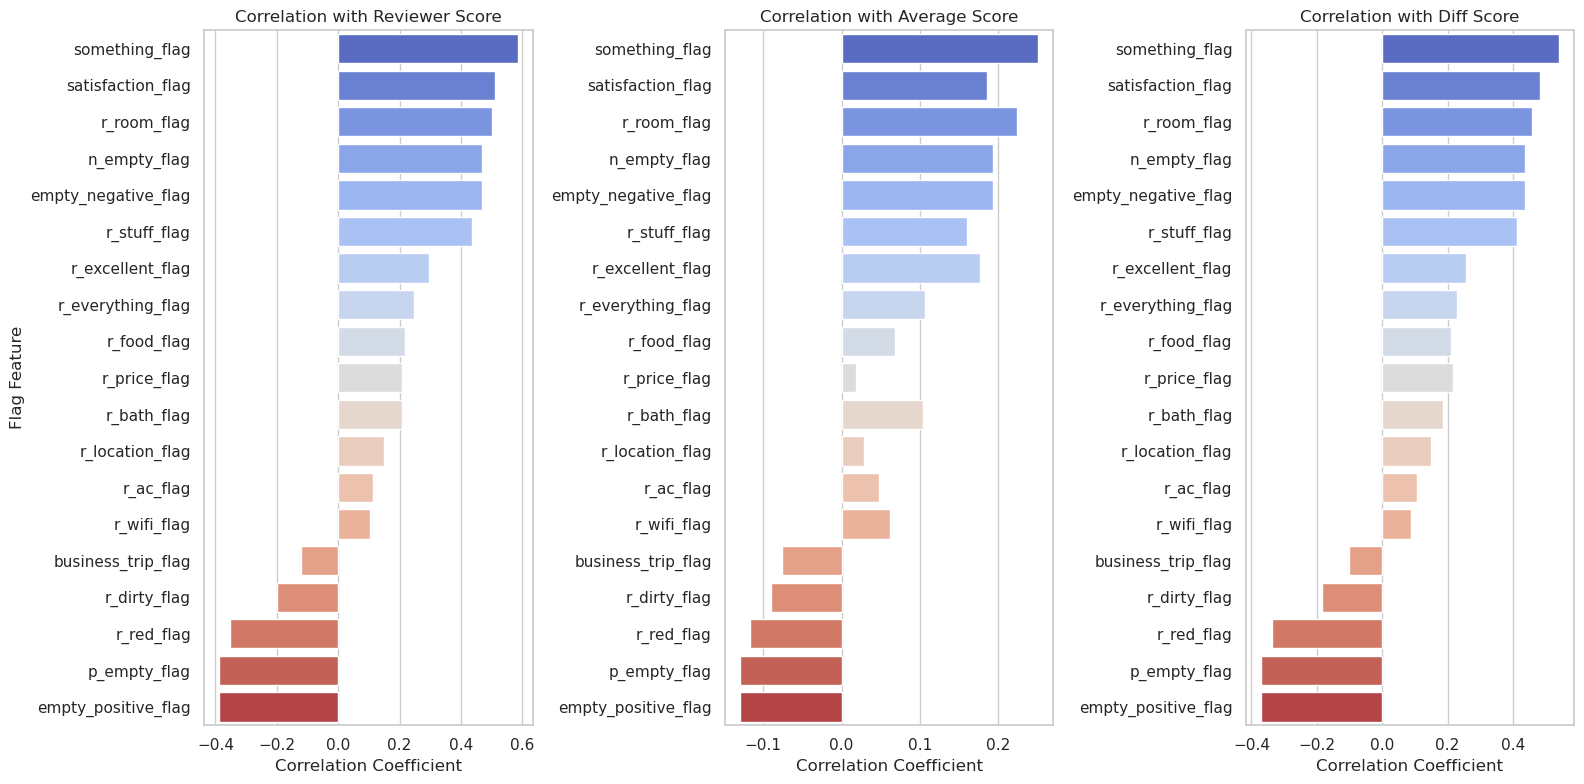

🔹 Flags with weak correlation (<0.05) with reviewer_score:

Empty DataFrame
Columns: [Corr_with_ReviewerScore, Corr_with_AverageScore, Corr_with_DiffScore]
Index: []


In [125]:
# =====================================================
#  Step: Correlation Between Flag Features and Ratings
# =====================================================

# Automatically select all columns that end with "_flag"
flag_cols = [col for col in sampled_hotels.columns if col.endswith('_flag')]
type_cols = flag_cols
# Create a DataFrame containing only flags and target columns
flag_data = sampled_hotels[type_cols + ['reviewer_score', 'average_score']]
flag_data['diff_score'] = flag_data['reviewer_score'] - flag_data['average_score']
#flag_data.drop(['sample'], axis=1, inplace=True)

# Compute the correlation matrix
corr_matrix = flag_data.corr(numeric_only=True)

# Extract correlations of flags with reviewer_score and average_score
corr_with_reviewer = corr_matrix['reviewer_score'].sort_values(ascending=False)
corr_with_average = corr_matrix['average_score'].sort_values(ascending=False)
corr_with_diff = corr_matrix['diff_score'].sort_values(ascending=False)

# Combine into one DataFrame for better comparison
flag_corr = pd.DataFrame({
    'Corr_with_ReviewerScore': corr_with_reviewer[type_cols],
    'Corr_with_AverageScore': corr_with_average[type_cols],
    'Corr_with_DiffScore': corr_with_diff[type_cols]
}).sort_values(by='Corr_with_ReviewerScore', ascending=False)



# Choose the threshold
threshold = 0.05

# Identify weak flags
weak_flags = flag_corr[flag_corr['Corr_with_ReviewerScore'].abs() < threshold].index.tolist()

print("🔹 Removing weak flag columns:")
print(weak_flags)

# Drop weak flags from your dataframe
#n_hotels_reduced = n_hotels.drop(columns=weak_flags)
if 'mobile_flag' in weak_flags:
    weak_flags.remove('mobile_flag')
n_hotels = n_hotels.drop(columns=weak_flags)


#print(f"\nRemaining columns: {n_hotels.shape[1]}")




# =====================================================
#  Visualization: Flag Correlation with Ratings
# =====================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

# Reviewer Score
sns.barplot(
    x='Corr_with_ReviewerScore',
    y=flag_corr.index,
    data=flag_corr,
    palette='coolwarm',
    ax=axes[0]
)
axes[0].set_title('Correlation with Reviewer Score')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_ylabel('Flag Feature')

# Average Score
sns.barplot(
    x='Corr_with_AverageScore',
    y=flag_corr.index,
    data=flag_corr,
    palette='coolwarm',
    ax=axes[1]
)
axes[1].set_title('Correlation with Average Score')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_ylabel('')  # No need to repeat label


# Average Score
sns.barplot(
    x='Corr_with_DiffScore',
    y=flag_corr.index,
    data=flag_corr,
    palette='coolwarm',
    ax=axes[2]
)
axes[2].set_title('Correlation with Diff Score')
axes[2].set_xlabel('Correlation Coefficient')
axes[2].set_ylabel('')  # No need to repeat label

plt.tight_layout()
plt.show()

weak_flags = flag_corr[flag_corr['Corr_with_ReviewerScore'].abs() < 0.05]
print("🔹 Flags with weak correlation (<0.05) with reviewer_score:\n")
print(weak_flags)

In [126]:
# Summary statistics for numerical columns
print(n_hotels.describe().T)

                                      count         mean          std  \
additional_number_of_scoring       470470.0   495.564261   499.075502   
average_score                      470470.0     8.393366     0.550863   
review_total_negative_word_counts  470470.0    16.721438    29.651248   
total_number_of_reviews            470470.0  2738.570147  2314.139124   
review_total_positive_word_counts  470470.0    17.164884    22.064040   
...                                     ...          ...          ...   
days_since_review_e                470470.0     0.003743     0.048364   
additional_number_of_scoring_log   470470.0     5.767122     0.986017   
total_feedback_log                 470470.0     7.750786     0.857877   
total_number_of_reviews_log        470470.0     7.588757     0.852135   
total_scoring_log                  470470.0     7.750786     0.857877   

                                             min            25%  \
additional_number_of_scoring        1.000000e+00   1.680

- Some flags are very rare (pet_flag, disability_flag, no_window_flag) → consider grouping or ignoring if analyzing correlation.

- Most reviewers stay 1–2 nights, so nights can be treated as categorical or ordinal.

- pos_to_neg_ratio has very high max (385) → might need log transform for visualization.

# Visualize distributions of numerical features

In [127]:
sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()


In [128]:
sampled_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       ...
       'first_months_flag', 'total_scoring', 'add_scoreing_%', 'tot_reviews_%',
       'tot_rev_vs_add_scoring', 'days_since_review_e',
       'additional_number_of_scoring_log', 'total_feedback_log',
       'total_number_of_reviews_log', 'total_scoring_log'],
      dtype='object', length=115)

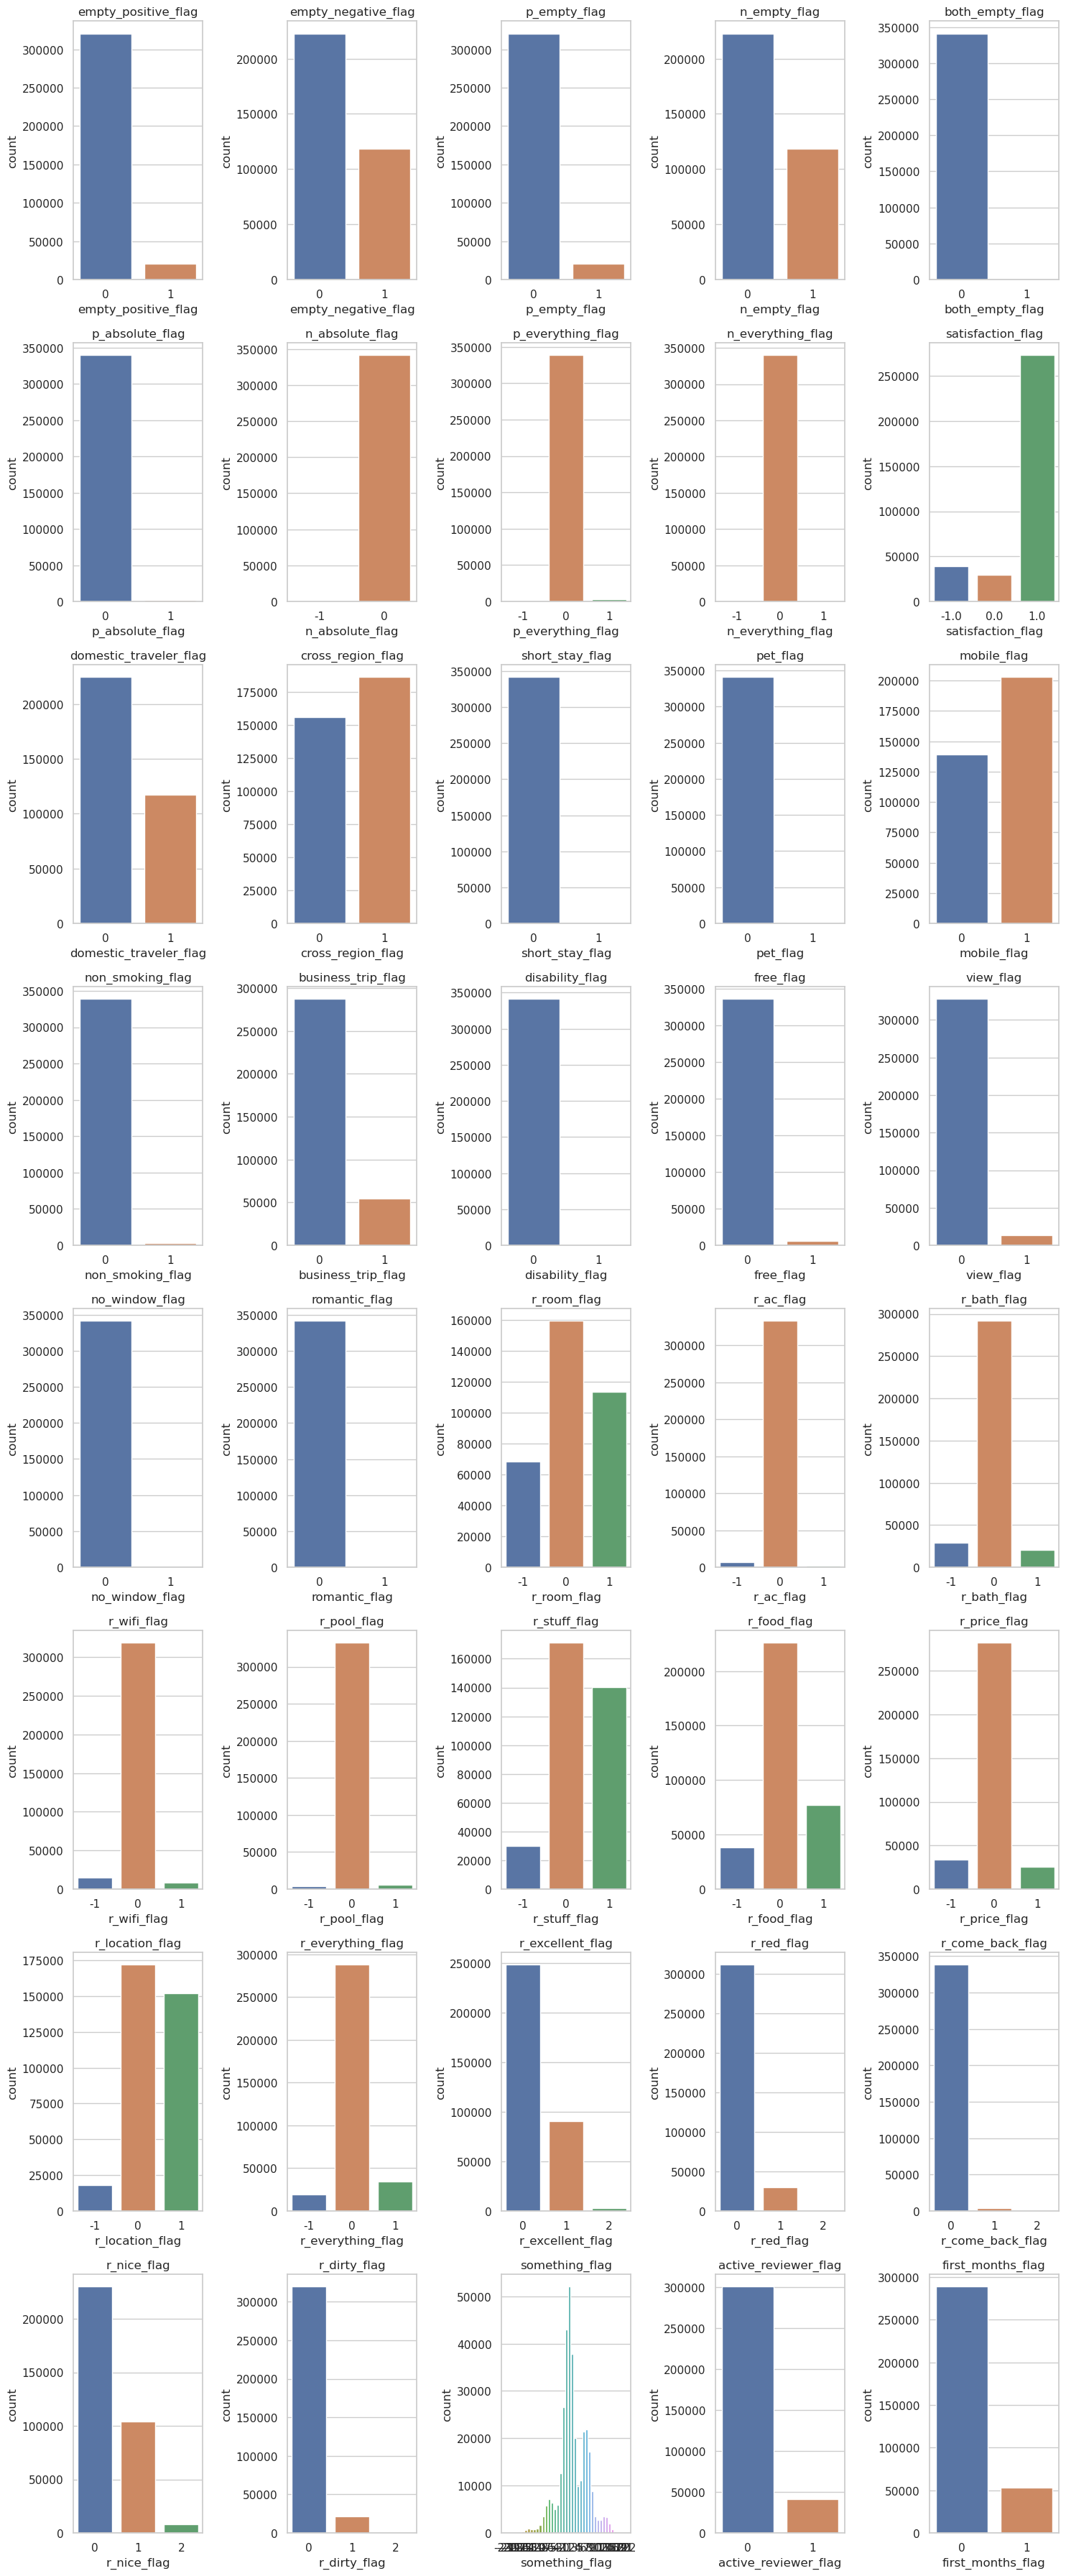

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()
# Select all _flag columns
flag_cols = [col for col in n_hotels.columns if col.endswith('_flag')]

# Plot distributions side by side
fig, axes = plt.subplots(len(flag_cols)//5 + 1, 5, figsize=(15, len(flag_cols)))
axes = axes.flatten()

for i, col in enumerate(flag_cols):
    sns.countplot(x=col, data=sampled_hotels, ax=axes[i])
    axes[i].set_title(f'{col}')

# Remove empty axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



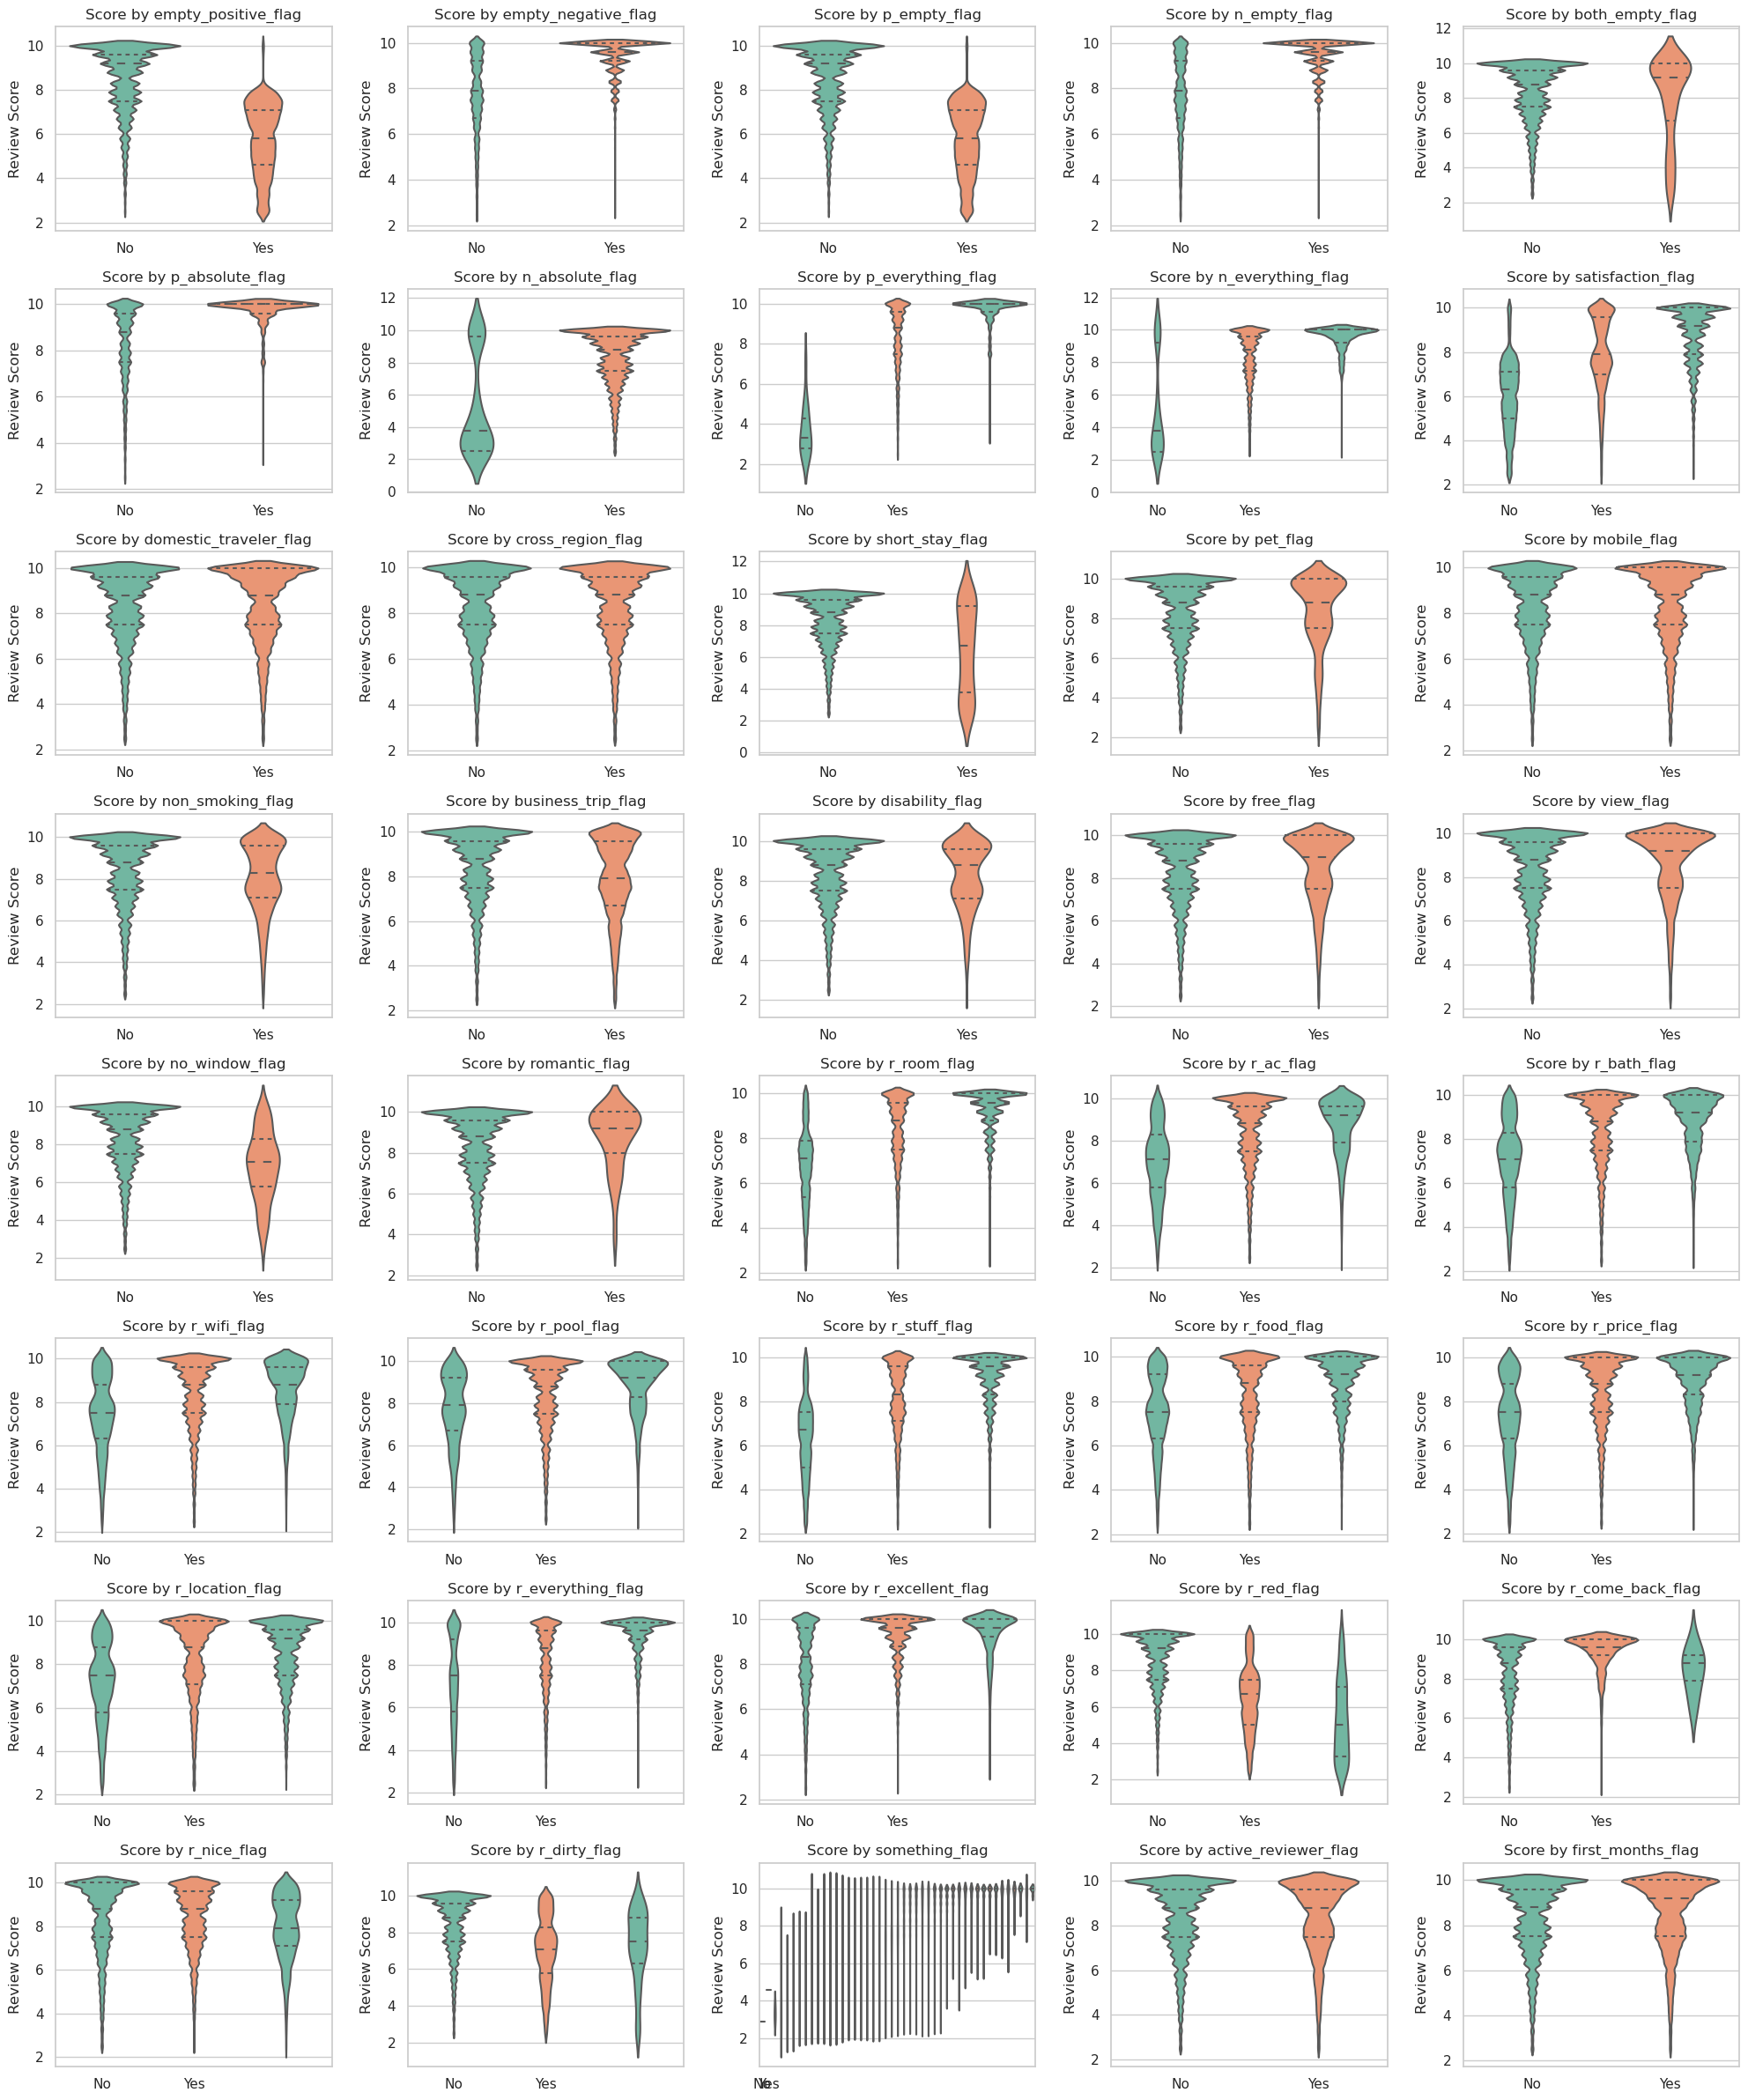

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select all columns ending with '_flag'
#
# flag_cols = [col for col in sampled_hotels.columns if col.endswith('_flag')]

# Set up the plot grid
n_flags = len(flag_cols)
n_cols = 5  # number of subplots per row
n_rows = (n_flags + n_cols - 1) // n_cols  # calculate rows needed

plt.figure(figsize=(n_cols*4, n_rows*3))

for i, flag in enumerate(flag_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(
        x=flag,
        y='reviewer_score',
        data=sampled_hotels,
        inner='quartile',
        palette=['#66c2a5','#fc8d62']
    )
    plt.xticks([0,1], ['No','Yes'])
    plt.title(f'Score by {flag}')
    plt.xlabel('')
    plt.ylabel('Review Score')

plt.tight_layout()
plt.show()


In [131]:
other_cols = n_hotels.select_dtypes(include=['int64', 'float64']).columns.difference(flag_cols)
other_cols

Index(['add_scoreing_%', 'additional_number_of_scoring',
       'additional_number_of_scoring_log', 'average_score', 'cluster',
       'cluster_mean_score', 'cluster_median_score', 'cluster_std_score',
       'days_since_review', 'days_since_review_e', 'distance_from_city_center',
       'distance_to_bad_landmark', 'distance_to_closest_landmark', 'h_cluster',
       'hotel_mean_score', 'hotel_median_score', 'hotel_std_score', 'lat',
       'lng', 'neg_word_count_bin', 'neg_word_count_bin2',
       'neg_word_count_log', 'negative_score', 'negative_score_e',
       'negative_word_%', 'nights', 'old_review', 'pos_vs_neg', 'pos_vs_neg2',
       'pos_word_count_bin', 'pos_word_count_bin2', 'pos_word_count_log',
       'positive_score', 'positive_score_e', 'positive_word_%',
       'review_total_negative_word_counts',
       'review_total_positive_word_counts', 'reviewer_score', 'room_capacity',
       'room_quality_level', 'sample', 'satisfaction_flag1',
       'satisfaction_flag2', 'satisf

In [132]:
#n_hotels.drop('tag_list', axis=1, inplace=True)
#_hotels.columns

In [133]:
# ==========================
# Identify categorical and numeric columns
# ==========================

# categorical features
cat_cols = [ 'sample', 'distance_zone', 'traveler_type', 'room_capacity', 'room_quality_level',]

# numerical features
num_cols = other_cols.difference(cat_cols) #list(n_hotels.drop(columns=cat_cols, axis=1))

num_cols, cat_cols

(Index(['add_scoreing_%', 'additional_number_of_scoring',
        'additional_number_of_scoring_log', 'average_score', 'cluster',
        'cluster_mean_score', 'cluster_median_score', 'cluster_std_score',
        'days_since_review', 'days_since_review_e', 'distance_from_city_center',
        'distance_to_bad_landmark', 'distance_to_closest_landmark', 'h_cluster',
        'hotel_mean_score', 'hotel_median_score', 'hotel_std_score', 'lat',
        'lng', 'neg_word_count_bin', 'neg_word_count_bin2',
        'neg_word_count_log', 'negative_score', 'negative_score_e',
        'negative_word_%', 'nights', 'old_review', 'pos_vs_neg', 'pos_vs_neg2',
        'pos_word_count_bin', 'pos_word_count_bin2', 'pos_word_count_log',
        'positive_score', 'positive_score_e', 'positive_word_%',
        'review_total_negative_word_counts',
        'review_total_positive_word_counts', 'reviewer_score',
        'satisfaction_flag1', 'satisfaction_flag2', 'satisfaction_flag3',
        'tot_rev_vs_add_sco

In [134]:
'''import matplotlib.pyplot as plt
import seaborn as sns

sampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()
#num_cols = n_hotels.select_dtypes(include=['int64', 'float64']).columns.tolist()
#plot_cols = [x for x in num_cols if x not in flag_cols]

plt.figure(figsize=(16, 20))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    sns.boxplot(x=sampled_hotels[col])
    plt.title(col)
plt.tight_layout()
plt.show()
'''

"import matplotlib.pyplot as plt\nimport seaborn as sns\n\nsampled_hotels = n_hotels[n_hotels['sample'] == 1].copy()\n#num_cols = n_hotels.select_dtypes(include=['int64', 'float64']).columns.tolist()\n#plot_cols = [x for x in num_cols if x not in flag_cols]\n\nplt.figure(figsize=(16, 20))\nfor i, col in enumerate(num_cols, 1):\n    plt.subplot(len(num_cols)//3 + 1, 3, i)\n    sns.boxplot(x=sampled_hotels[col])\n    plt.title(col)\nplt.tight_layout()\nplt.show()\n"

## Outliers

**Tree-based models** split by thresholds, so extreme values won’t “pull” the model the way they would in regression.

In [135]:
'''
#   3-sigma method (Tukey's method) to identify outliers in numerical features
import pandas as pd

def outliers_iqr(data, feature, k=3.0):
    """Detect and remove outliers using the Tukey IQR method."""
    x = data[feature]
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# Create a cleaned copy of the dataset
data_cleaner = n_hotels.copy()

# Loop through numeric columns
for feature in num_cols:
    outliers, cleaned = outliers_iqr(data_cleaner, feature, k=3)
    print(f"{feature}: removed {len(outliers)} outliers")
    data_cleaner = cleaned  # progressively clean the dataset

'''

'\n#   3-sigma method (Tukey\'s method) to identify outliers in numerical features\nimport pandas as pd\n\ndef outliers_iqr(data, feature, k=3.0):\n    """Detect and remove outliers using the Tukey IQR method."""\n    x = data[feature]\n    q1, q3 = x.quantile(0.25), x.quantile(0.75)\n    iqr = q3 - q1\n    lower_bound = q1 - k * iqr\n    upper_bound = q3 + k * iqr\n    outliers = data[(x < lower_bound) | (x > upper_bound)]\n    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]\n    return outliers, cleaned\n\n# Create a cleaned copy of the dataset\ndata_cleaner = n_hotels.copy()\n\n# Loop through numeric columns\nfor feature in num_cols:\n    outliers, cleaned = outliers_iqr(data_cleaner, feature, k=3)\n    print(f"{feature}: removed {len(outliers)} outliers")\n    data_cleaner = cleaned  # progressively clean the dataset\n\n'

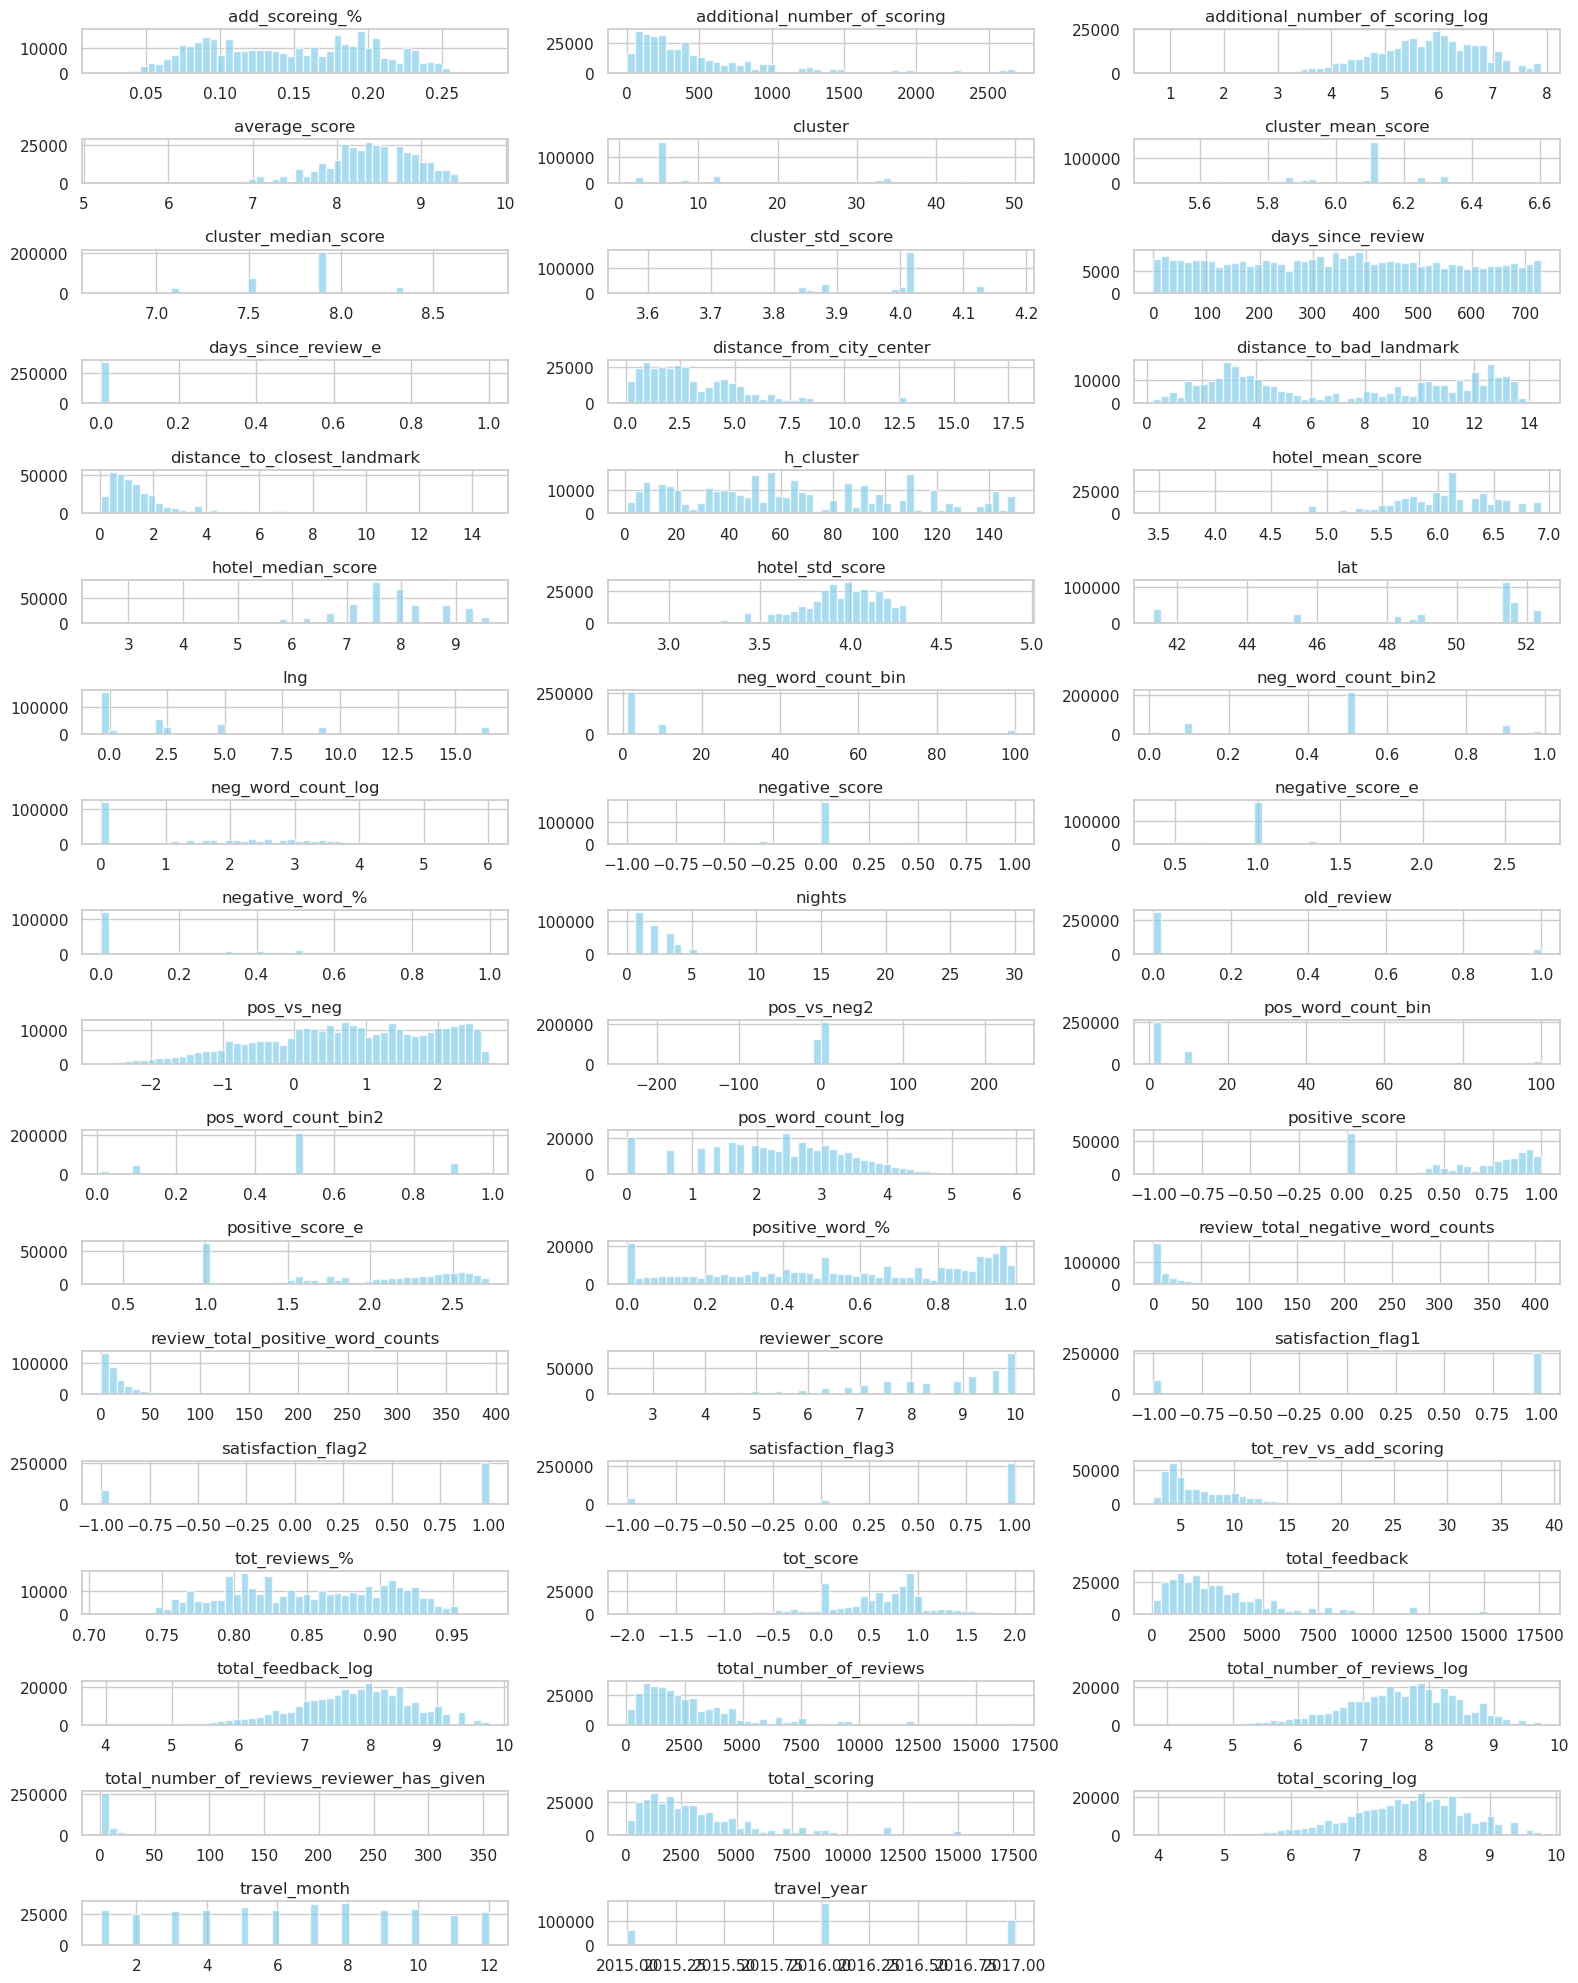

In [136]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    plt.hist(x=sampled_hotels[col], bins=50, color='skyblue', alpha=0.7)
    plt.title(col)
plt.tight_layout()
plt.show()

In [137]:
"""import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    # Before cleaning
    axes[i, 0].hist(n_hotels[col], bins=50, color='skyblue', alpha=0.7)
    axes[i, 0].set_title(f'{col} — Before Cleaning')

    # After cleaning
    axes[i, 1].hist(data_cleaner[col], bins=50, color='lightgreen', alpha=0.7)
    axes[i, 1].set_title(f'{col} — After Cleaning')

plt.tight_layout()
plt.show()"""

"import matplotlib.pyplot as plt\n\nfig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4 * len(num_cols)))\n\nfor i, col in enumerate(num_cols):\n    # Before cleaning\n    axes[i, 0].hist(n_hotels[col], bins=50, color='skyblue', alpha=0.7)\n    axes[i, 0].set_title(f'{col} — Before Cleaning')\n\n    # After cleaning\n    axes[i, 1].hist(data_cleaner[col], bins=50, color='lightgreen', alpha=0.7)\n    axes[i, 1].set_title(f'{col} — After Cleaning')\n\nplt.tight_layout()\nplt.show()"

In [138]:
"""# Create a cleaned copy of the dataset
n_hotels_cleaner = n_hotels.copy()

# It seems like, some of the features do require outlier cleaning
# --- Apply cleaning only to selected columns ---
out_cols = [
    'total_number_of_reviews',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'nights'
]

for feature in out_cols:
    outliers, cleaned = outliers_iqr(n_hotels, feature, k=3)
    print(f"{feature}: removed {len(outliers)} outliers")
    n_hotels_cleaner = cleaned  # progressively remove outliers"""

'# Create a cleaned copy of the dataset\nn_hotels_cleaner = n_hotels.copy()\n\n# It seems like, some of the features do require outlier cleaning\n# --- Apply cleaning only to selected columns ---\nout_cols = [\n    \'total_number_of_reviews\',\n    \'review_total_negative_word_counts\',\n    \'review_total_positive_word_counts\',\n    \'total_number_of_reviews_reviewer_has_given\',\n    \'nights\'\n]\n\nfor feature in out_cols:\n    outliers, cleaned = outliers_iqr(n_hotels, feature, k=3)\n    print(f"{feature}: removed {len(outliers)} outliers")\n    n_hotels_cleaner = cleaned  # progressively remove outliers'

## Scaling

For numeric features that vary a lot in magnitude and will otherwise dominate distance-based or linear models.

**Tree-based models** (RandomForest, XGBoost, etc.) are scale-invariant, so scaling is not needed.
However, if you’ll use regression, PCA, or neural networks, scaling is highly recommended.


In [139]:
'''
to_scale = [
    'additional_number_of_scoring',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews',
    'total_number_of_reviews_reviewer_has_given',
    'nights',
    'days_since_review_n'
]
no_scale = [
    'average_score',
    'reviewer_score',
    'lat', 'lng',
    'lat_nationality', 'lng_nationality',
    'year'
]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
n_hotels[to_scale] = scaler.fit_transform(n_hotels[to_scale])
'''

"\nto_scale = [\n    'additional_number_of_scoring',\n    'review_total_negative_word_counts',\n    'review_total_positive_word_counts',\n    'total_number_of_reviews',\n    'total_number_of_reviews_reviewer_has_given',\n    'nights',\n    'days_since_review_n'\n]\nno_scale = [\n    'average_score',\n    'reviewer_score',\n    'lat', 'lng',\n    'lat_nationality', 'lng_nationality',\n    'year'\n]\n\nfrom sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nn_hotels[to_scale] = scaler.fit_transform(n_hotels[to_scale])\n"

In [140]:
'''

import numpy as np

def cap_outliers(df, columns, factor=1.5):
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        # cap values
        df[col] = np.where(df[col] < lower, lower,
                           np.where(df[col] > upper, upper, df[col]))
    return df

n_hotels[num_cols] = cap_outliers(n_hotels, num_cols)

'''

'\n\nimport numpy as np\n\ndef cap_outliers(df, columns, factor=1.5):\n    df = df.copy()\n    for col in columns:\n        Q1 = df[col].quantile(0.25)\n        Q3 = df[col].quantile(0.75)\n        IQR = Q3 - Q1\n        lower = Q1 - factor * IQR\n        upper = Q3 + factor * IQR\n        # cap values\n        df[col] = np.where(df[col] < lower, lower,\n                           np.where(df[col] > upper, upper, df[col]))\n    return df\n\nn_hotels[num_cols] = cap_outliers(n_hotels, num_cols)\n\n'

## Remove strongly correlated features

In [141]:
# We generated a lot of features, lets remove those that just duplicate the information to make the learning part faster
# 

chosen_hotels = n_hotels.select_dtypes(include=['number'])

chosen_hotels.columns


Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample',
       ...
       'first_months_flag', 'total_scoring', 'add_scoreing_%', 'tot_reviews_%',
       'tot_rev_vs_add_scoring', 'days_since_review_e',
       'additional_number_of_scoring_log', 'total_feedback_log',
       'total_number_of_reviews_log', 'total_scoring_log'],
      dtype='object', length=103)

In [142]:
chosen_hotels.drop(['lat', 'lng'] , axis=1, inplace=True)
chosen_hotels.drop(['distance_from_city_center','total_scoring'] , axis=1, inplace=True)
chosen_hotels.drop(['total_number_of_reviews','both_empty_flag','short_stay_flag','pet_flag', 'non_smoking_flag', 'no_window_flag', 'romantic_flag','active_reviewer_flag'] , axis=1, inplace=True)
#chosen_hotels.drop(['positive_score', 'negative_score', 'p_nothing_flag', 'n_nothing_flag','r_room_flag', 'r_stuff_flag', 'r_price_flag', 'r_location_flag'] , axis=1, inplace=True)


sampled_hotels = chosen_hotels[chosen_hotels['sample'] == 1].copy()


chosen_hotels.columns



Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'sample', 'reviewer_score', 'neg_word_count_log', 'pos_word_count_log',
       'empty_positive_flag', 'empty_negative_flag', 'pos_word_count_bin',
       'neg_word_count_bin', 'pos_word_count_bin2', 'neg_word_count_bin2',
       'p_empty_flag', 'n_empty_flag', 'p_absolute_flag', 'n_absolute_flag',
       'p_everything_flag', 'n_everything_flag', 'positive_score',
       'negative_score', 'tot_score', 'positive_score_e', 'negative_score_e',
       'satisfaction_flag', 'positive_word_%', 'negative_word_%', 'pos_vs_neg',
       'pos_vs_neg2', 'satisfaction_flag1', 'satisfaction_flag2',
       'satisfaction_flag3', 'country_Austria', 'country_France',
       'country_Italy', 'country_Netherlands', 'country_Spain',
       'country_United Kingdom', 'distance_to_closest_l

In [143]:
n_hotels.isna().sum().sum()

0

In [144]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_uncorrelated_features(df, threshold_lower=0.0, threshold_upper=0.9, target=None, return_vif=False):
    numeric_df = df.select_dtypes(include=[np.number]).copy()

    # ---- Remove target temporarily ----
    if target is not None:
        numeric_df_no_target = numeric_df.drop(columns=[target])
    else:
        numeric_df_no_target = numeric_df.copy()

    # ---- HIGH CORRELATION REMOVAL (feature-to-feature) ----
    corr_matrix = numeric_df_no_target.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    highly_corr_drop = [col for col in upper.columns if any(upper[col] > threshold_upper)]

    # ---- LOW CORRELATION REMOVAL (feature-to-target) ----
    if target is not None:
        corr_with_target = numeric_df.corr()[target]
        weak_corr_drop = corr_with_target[abs(corr_with_target) < threshold_lower].index.tolist()
        weak_corr_drop = [col for col in weak_corr_drop if col != target]  # safeguard
    else:
        weak_corr_drop = []

    # Combine drops
    features_to_drop = set(highly_corr_drop) | set(weak_corr_drop) #

    # Features to keep
    features_to_keep = [col for col in numeric_df.columns if col not in features_to_drop]

    # Add target back
    if target is not None and target not in features_to_keep:
        features_to_keep.append(target)

    # ---- VIF calculation ----
    if return_vif:
        vif_df = pd.DataFrame()
        vif_cols = [col for col in features_to_keep if col != target]
        vif_df["feature"] = vif_cols
        vif_df["VIF"] = [variance_inflation_factor(df[vif_cols].values, i)
                         for i in range(len(vif_cols))]
        return features_to_keep, list(features_to_drop), vif_df

    return features_to_keep, list(features_to_drop)




# Example usage:
features_to_keep, features_to_drop, vif_df = get_uncorrelated_features(
    sampled_hotels, 
    threshold_lower=0.0, 
    threshold_upper=0.95, 
    target='reviewer_score', 
    return_vif=True
    )

print("Columns to keep:", features_to_keep)
print(vif_df.sort_values("VIF", ascending=False))

/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: d

Columns to keep: ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'sample', 'reviewer_score', 'neg_word_count_log', 'pos_word_count_log', 'empty_positive_flag', 'empty_negative_flag', 'pos_word_count_bin', 'neg_word_count_bin', 'pos_word_count_bin2', 'p_absolute_flag', 'n_absolute_flag', 'p_everything_flag', 'n_everything_flag', 'positive_score', 'negative_score', 'tot_score', 'satisfaction_flag', 'positive_word_%', 'pos_vs_neg', 'pos_vs_neg2', 'satisfaction_flag1', 'country_Austria', 'country_France', 'country_Italy', 'country_Netherlands', 'country_Spain', 'country_United Kingdom', 'distance_to_closest_landmark', 'distance_to_bad_landmark', 'domestic_traveler_flag', 'cross_region_flag', 'cluster', 'cluster_mean_score', 'cluster_median_score', 'cluster_std_score', 'nights', 'traveler_type', 'mobile_flag', 'business_trip_flag', 'disability_flag',

In [145]:
features_to_drop

['satisfaction_flag3',
 'hotel_median_score',
 'satisfaction_flag2',
 'total_number_of_reviews_log',
 'positive_score_e',
 'hotel_std_score',
 'hotel_mean_score',
 'n_empty_flag',
 'negative_score_e',
 'neg_word_count_bin2',
 'tot_reviews_%',
 'p_empty_flag',
 'total_scoring_log',
 'negative_word_%']

In [146]:

features_to_keep

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'sample',
 'reviewer_score',
 'neg_word_count_log',
 'pos_word_count_log',
 'empty_positive_flag',
 'empty_negative_flag',
 'pos_word_count_bin',
 'neg_word_count_bin',
 'pos_word_count_bin2',
 'p_absolute_flag',
 'n_absolute_flag',
 'p_everything_flag',
 'n_everything_flag',
 'positive_score',
 'negative_score',
 'tot_score',
 'satisfaction_flag',
 'positive_word_%',
 'pos_vs_neg',
 'pos_vs_neg2',
 'satisfaction_flag1',
 'country_Austria',
 'country_France',
 'country_Italy',
 'country_Netherlands',
 'country_Spain',
 'country_United Kingdom',
 'distance_to_closest_landmark',
 'distance_to_bad_landmark',
 'domestic_traveler_flag',
 'cross_region_flag',
 'cluster',
 'cluster_mean_score',
 'cluster_median_score',
 'cluster_std_score',
 'nights',
 'traveler_type',
 'mobile_flag',
 'business_tri

In [147]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       ...
       'first_months_flag', 'total_scoring', 'add_scoreing_%', 'tot_reviews_%',
       'tot_rev_vs_add_scoring', 'days_since_review_e',
       'additional_number_of_scoring_log', 'total_feedback_log',
       'total_number_of_reviews_log', 'total_scoring_log'],
      dtype='object', length=115)

In [148]:
my_columns=['average_score', 'sample', 'reviewer_score', 'empty_positive_review', 'empty_negative_review',
       'tot_score', 'positive_score_e', 'negative_score_e',
       'positive_word_%', 'negative_word_%', 'pos_vs_neg',
       'country_United Kingdom','distance_to_closest_landmark', 'cluster', 'cluster_mean_score',
       'cluster_median_score', 'cluster_std_score', 'traveler_type',
       'business_trip_flag', 'room_quality_level', 'r_excellent_flag',
       'r_poor_flag', 'r_come_back_flag', 'something_flag','old_review', 
       'h_cluster', 'hotel_median_score','hotel_std_score', 'mean_reviewer_score', 'diff_reviewer_score',
       'add_scoreing_%', 'tot_reviews_%']

len( my_columns )

32

In [149]:
chosen_hotels = chosen_hotels[features_to_keep].copy()


## Correlation map

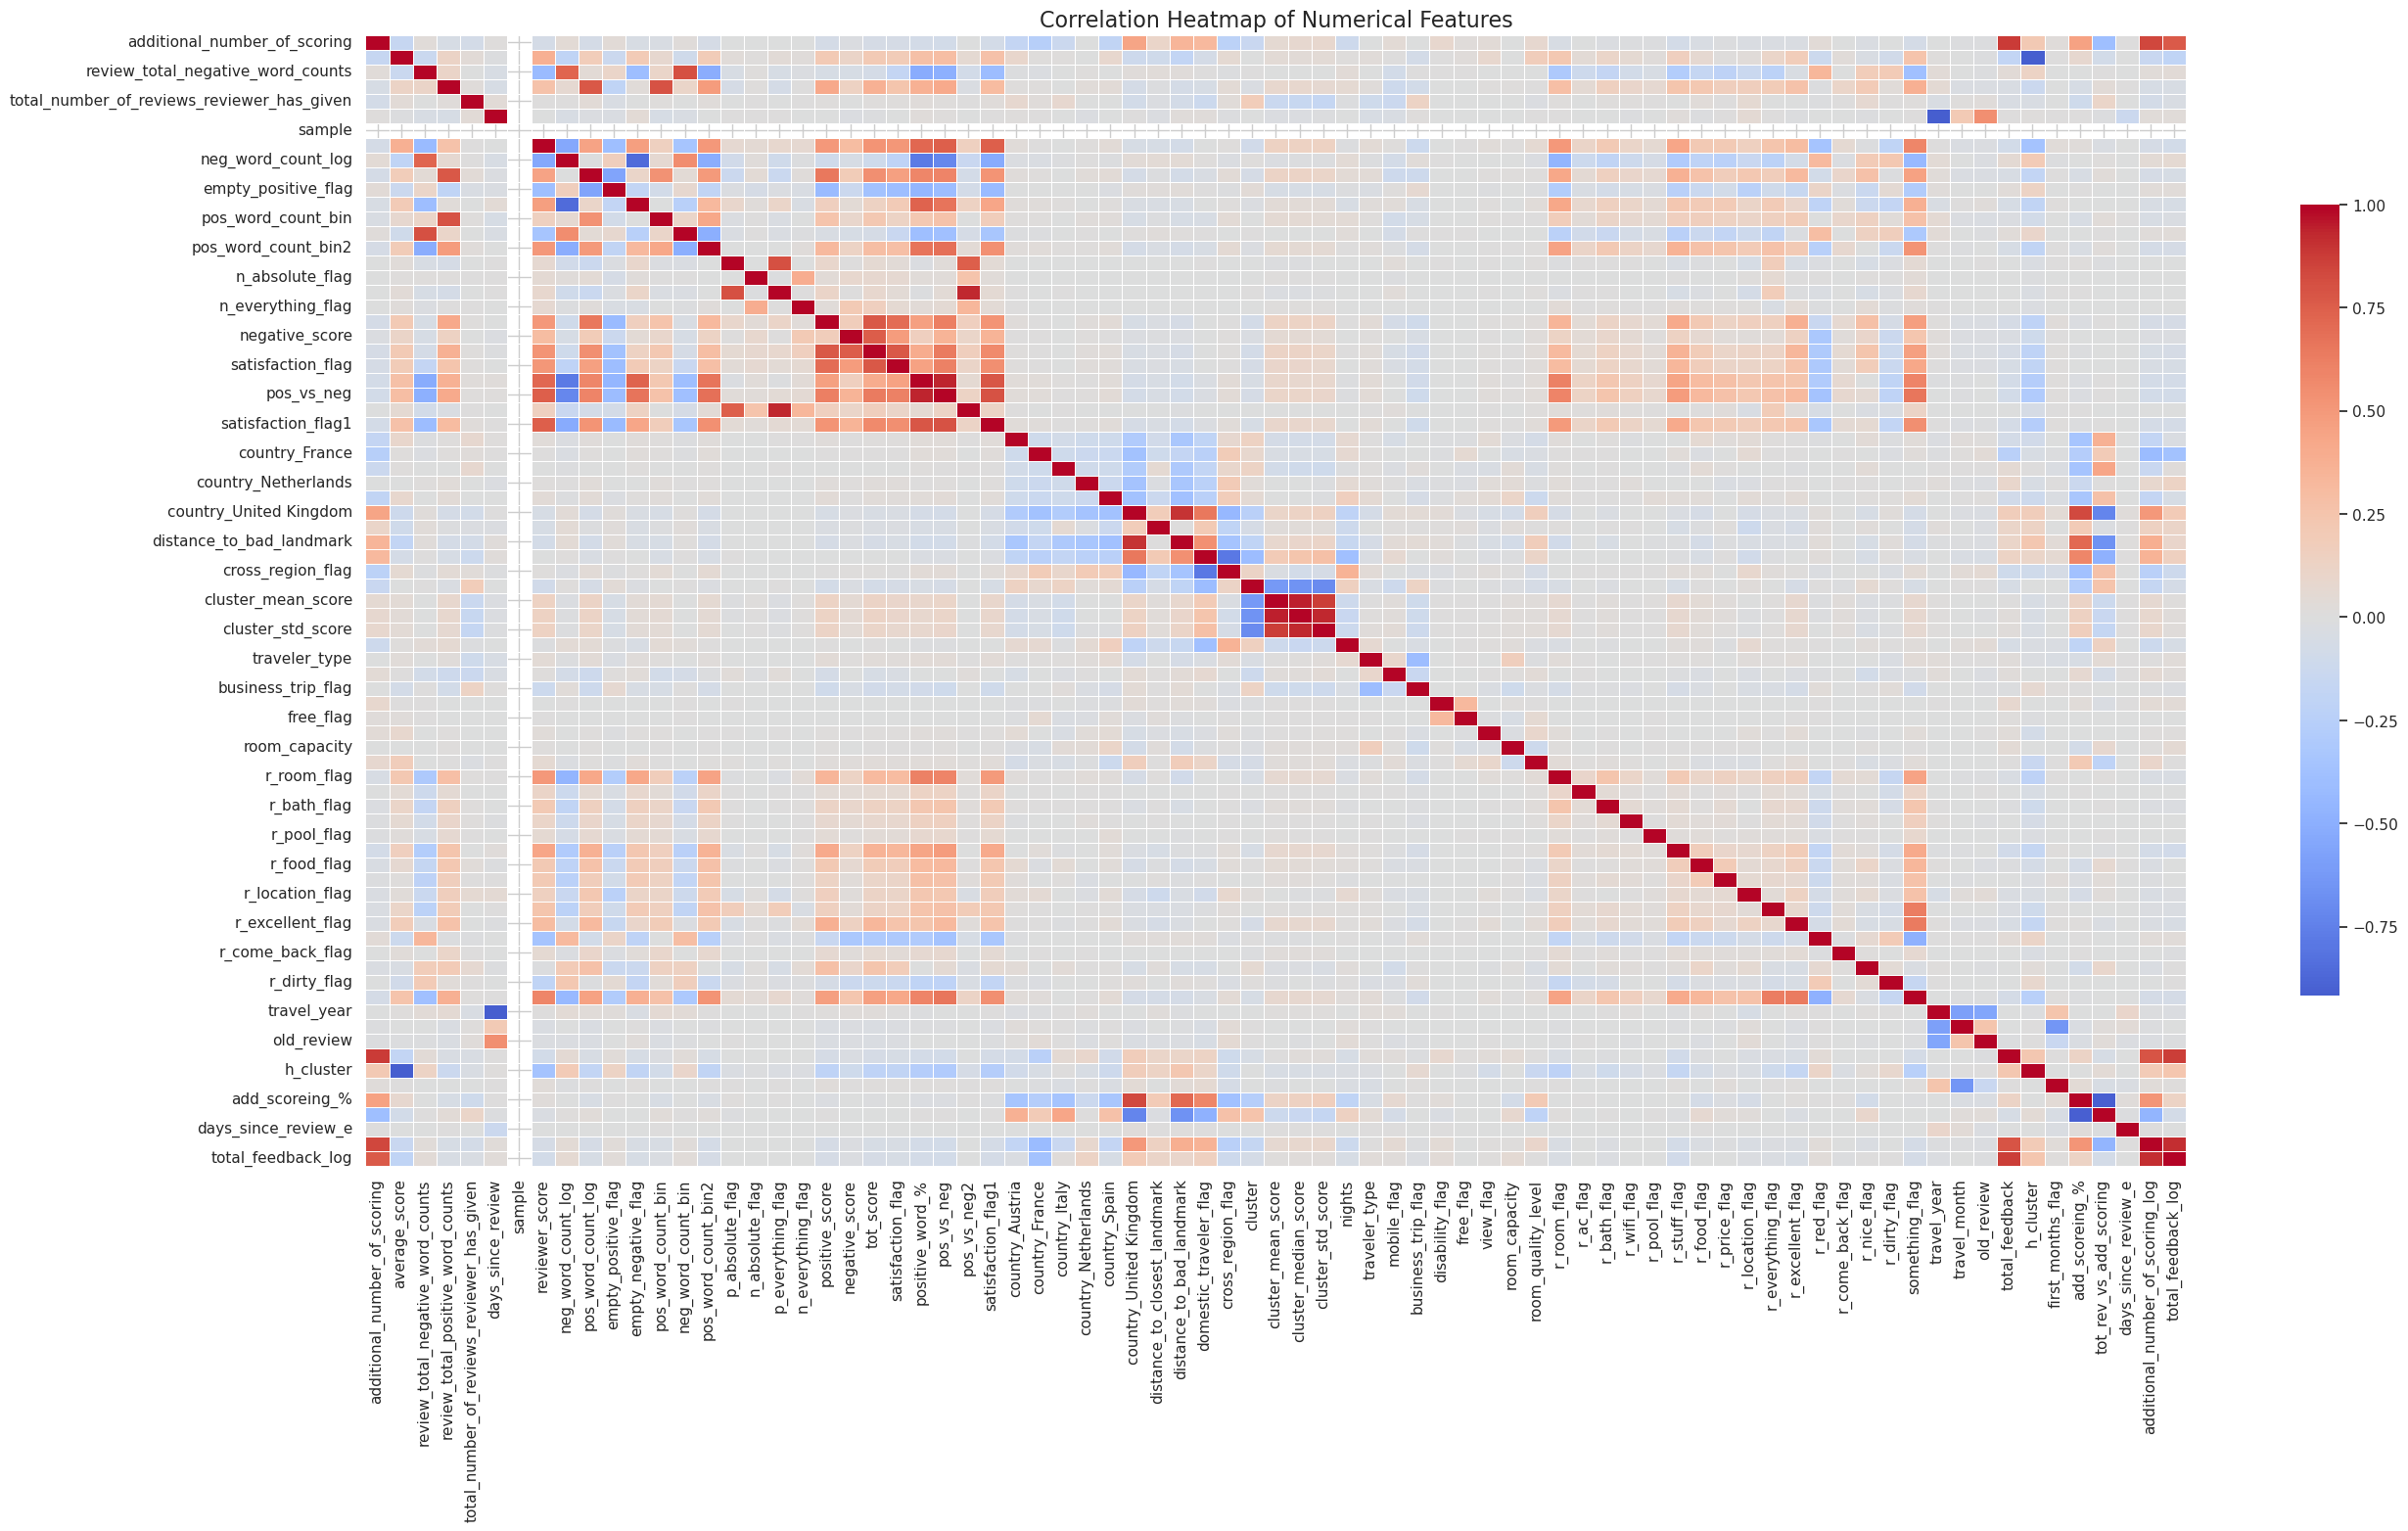

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation only for numerical columns
#chosen_hotels = n_hotels[features_to_keep]
sampled_hotels = chosen_hotels[chosen_hotels['sample'] == 1].copy()
corr = sampled_hotels.select_dtypes(include=['number']).corr()

# Create a better visual
plt.figure(figsize=(30,15))
sns.heatmap(
    corr, 
    cmap='coolwarm',       # better contrast
    center=0,              # zero-centered colors
    annot=False,           # can set True for small matrices
    linewidths=0.5,
    cbar_kws={'shrink': .7}
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

# Train/Test Split and Model Training

In [151]:
'''# Compute correlation matrix only for numeric features
corr = n_hotels.corr(numeric_only=True)

# Get correlation with the target variable
target_corr = corr['reviewer_score'].drop('reviewer_score', errors='ignore')

# Select features with |corr| >= 0.1
strong_features = target_corr[abs(target_corr) >= 0.02].index.tolist()

# Keep only these features (plus target)
n_hotels_filtered = n_hotels[strong_features + ['reviewer_score']]

print(f"Kept {len(strong_features)} features:")
print(strong_features)'''

'# Compute correlation matrix only for numeric features\ncorr = n_hotels.corr(numeric_only=True)\n\n# Get correlation with the target variable\ntarget_corr = corr[\'reviewer_score\'].drop(\'reviewer_score\', errors=\'ignore\')\n\n# Select features with |corr| >= 0.1\nstrong_features = target_corr[abs(target_corr) >= 0.02].index.tolist()\n\n# Keep only these features (plus target)\nn_hotels_filtered = n_hotels[strong_features + [\'reviewer_score\']]\n\nprint(f"Kept {len(strong_features)} features:")\nprint(strong_features)'

In [152]:
chosen_hotels.columns


Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'sample', 'reviewer_score', 'neg_word_count_log', 'pos_word_count_log',
       'empty_positive_flag', 'empty_negative_flag', 'pos_word_count_bin',
       'neg_word_count_bin', 'pos_word_count_bin2', 'p_absolute_flag',
       'n_absolute_flag', 'p_everything_flag', 'n_everything_flag',
       'positive_score', 'negative_score', 'tot_score', 'satisfaction_flag',
       'positive_word_%', 'pos_vs_neg', 'pos_vs_neg2', 'satisfaction_flag1',
       'country_Austria', 'country_France', 'country_Italy',
       'country_Netherlands', 'country_Spain', 'country_United Kingdom',
       'distance_to_closest_landmark', 'distance_to_bad_landmark',
       'domestic_traveler_flag', 'cross_region_flag', 'cluster',
       'cluster_mean_score', 'cluster_median_score', 'cluster_std_sco

In [153]:
# =====================================================
# 10. Train/Test Split, Encoding, and Model Training
# =====================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import pandas as pd

# Separate train and test data
train_data = chosen_hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = chosen_hotels.query('sample == 0').drop(['sample'], axis=1)

# Target and features
y = train_data['reviewer_score']
X = train_data.drop(['reviewer_score'], axis=1)

In [154]:
train_data['reviewer_score']

128935    10.0
128936     6.3
128937     7.5
128938    10.0
128939     9.6
          ... 
470465     8.8
470466     9.2
470467     8.3
470468     9.2
470469     8.8
Name: reviewer_score, Length: 341535, dtype: float64

In [155]:
chosen_hotels.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'sample', 'reviewer_score', 'neg_word_count_log', 'pos_word_count_log',
       'empty_positive_flag', 'empty_negative_flag', 'pos_word_count_bin',
       'neg_word_count_bin', 'pos_word_count_bin2', 'p_absolute_flag',
       'n_absolute_flag', 'p_everything_flag', 'n_everything_flag',
       'positive_score', 'negative_score', 'tot_score', 'satisfaction_flag',
       'positive_word_%', 'pos_vs_neg', 'pos_vs_neg2', 'satisfaction_flag1',
       'country_Austria', 'country_France', 'country_Italy',
       'country_Netherlands', 'country_Spain', 'country_United Kingdom',
       'distance_to_closest_landmark', 'distance_to_bad_landmark',
       'domestic_traveler_flag', 'cross_region_flag', 'cluster',
       'cluster_mean_score', 'cluster_median_score', 'cluster_std_sco

In [156]:
# ==========================
# Split train data into train/test sets
# ==========================
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==========================
# Optional: Scale numeric features (not required for Random Forest)
# ==========================
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_valid_scaled = scaler.transform(X_valid)



In [157]:
print("X shape:", X.shape)
print("X_train shape:", X_train.shape)

X shape: (341535, 75)
X_train shape: (273228, 75)


#  Hyperparameter tuning

In [158]:
'''del n_hotels

import gc
gc.collect()'''

'del n_hotels\n\nimport gc\ngc.collect()'

In [159]:
# ==========================
# Train Random Forest Model
# ==========================
#rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
#rf.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

#mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Define hyperparameter grid for tuning
#param_grid = {
#    'n_estimators': [100],
#    'max_depth': [20],
#    'min_samples_split': [40 ],
#    'min_samples_leaf': [2],
#}

#rf = RandomForestRegressor(random_state=42)

#grid = GridSearchCV(
#    rf,
#    param_grid=param_grid,
#    scoring=mape_scorer,#"neg_root_mean_squared_error",
#    n_jobs=-1,
#    cv=3
#)

#grid.fit(X_train, y_train)
#best_rf = grid.best_estimator_
#print(best_rf)
#model = best_rf
model = RandomForestRegressor(n_estimators=200, verbose=1, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

'''import xgboost as xgb

# Создаем модель XGBoost
model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Обучаем модель
model.fit(X_train, y_train)

# Предсказание
y_pred_xgb = model.predict(X_valid)

# Вычисляем Mean Absolute Error
mae_xgb = metrics.mean_absolute_error(y_valid, y_pred_xgb)
print('MAE (XGBoost):', mae_xgb)'''



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 11.7min finished


"import xgboost as xgb\n\n# Создаем модель XGBoost\nmodel = xgb.XGBRegressor(n_estimators=100, random_state=42)\n\n# Обучаем модель\nmodel.fit(X_train, y_train)\n\n# Предсказание\ny_pred_xgb = model.predict(X_valid)\n\n# Вычисляем Mean Absolute Error\nmae_xgb = metrics.mean_absolute_error(y_valid, y_pred_xgb)\nprint('MAE (XGBoost):', mae_xgb)"

In [160]:
# ==========================
# Evaluate model
# ==========================
#y_pred = best_rf.predict(X_valid)
y_pred = model.predict(X_valid)
mape = metrics.mean_absolute_percentage_error(y_valid, y_pred) * 100
mae = metrics.mean_absolute_error(y_valid, y_pred)
#rmse = metrics.mean_squared_error(y_valid, y_pred, squared=False)
r2 = metrics.r2_score(y_valid, y_pred)

print(f"MAE: {mae:.2f}")
#print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"Test MAPE: {mape:.2f}%")
#MAE: 0.84
#RMSE: 1.13
#R²: 0.524
#Test MAPE: 12.03%

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


MAE: 0.72
R²: 0.688
Test MAPE: 10.31%


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.0s finished


In [161]:
print('MAPE:', metrics.mean_absolute_error(y_valid, y_pred))

MAPE: 0.721986570434461


In [162]:
#model = best_rf

print(model.get_params()['n_estimators'])
print(model.get_params()['max_depth'])
print(model.get_params()['min_samples_split'])
print(model.get_params()['min_samples_leaf'])
print(model.get_params()['max_features'])

200
None
2
1
1.0


# Visual inspection

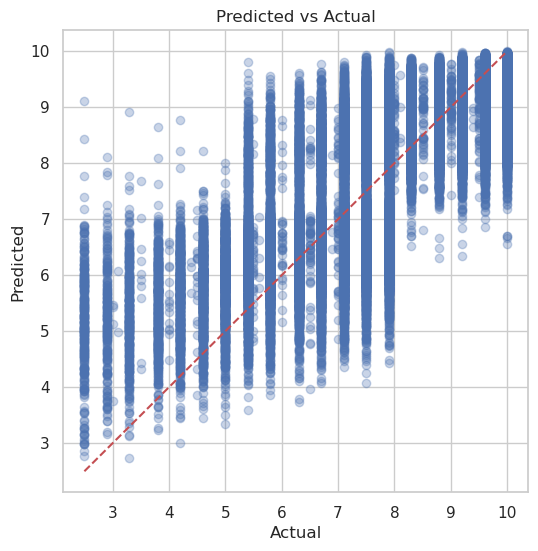

In [163]:
import matplotlib.pyplot as plt
#y_true = y_valid

plt.figure(figsize=(6,6))
plt.scatter(y_valid[:], y_pred[:], alpha=0.3)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

## (Optional) Feature Importance Plot

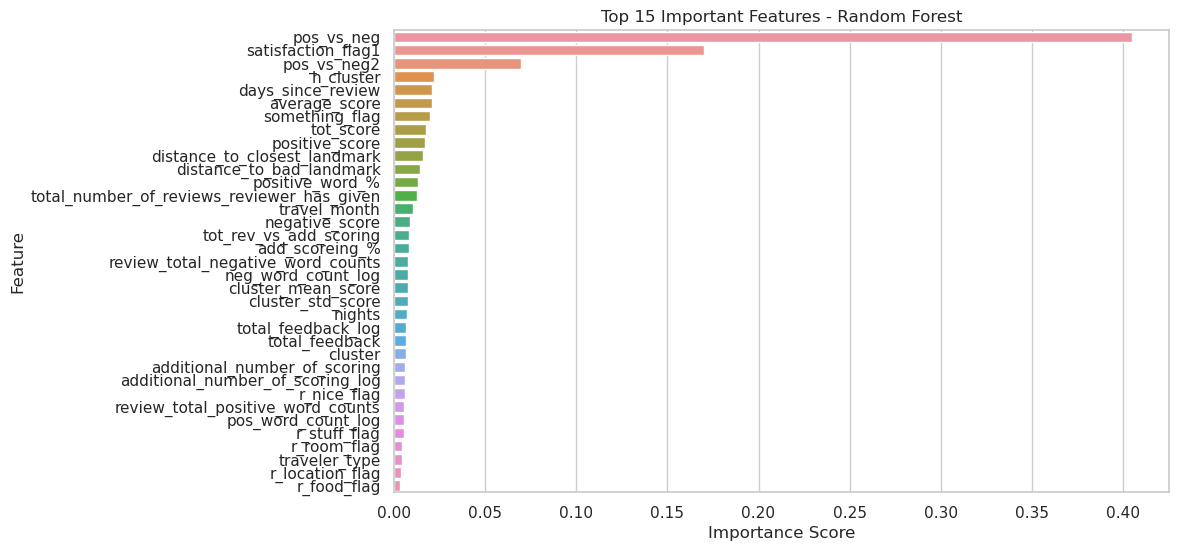

In [164]:
# =====================================================
# 12. Feature Importance Visualization
# =====================================================
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(35), y=importances.head(35).index)
plt.title('Top 15 Important Features - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Submission

In [165]:
XX = test_data.drop(['reviewer_score'], axis=1)
XX.head()

additional_number_of_scoring  average_score  \
0                           904            8.1   
1                           612            8.6   
2                            46            8.3   
3                           241            9.1   
4                           834            9.1   

   review_total_negative_word_counts  review_total_positive_word_counts  \
0                                 50                                 60   
1                                  9                                  0   
2                                  1                                  4   
3                                  0                                 26   
4                                  0                                  5   

   total_number_of_reviews_reviewer_has_given  days_since_review  \
0                                           1                 13   
1                                           7                234   
2                                          15                616   
3                                           9                656   
4                                           2                444   

   neg_word_count_log  pos_word_count_log  empty_positive_flag  \
0            3.931826            4.110874                    0   
1            2.302585            0.000000                    1   
2            0.693147            1.609438                    0   
3            0.000000            3.295837                    0   
4            0.000000            1.791759                    0   

   empty_negative_flag  pos_word_count_bin  neg_word_count_bin  \
0                    0                 100                  10   
1                    0                   1                   1   
2                    0                   1                   1   
3                    1                  10                   1   
4                    1                   1                   1   

   pos_word_count_bin2  p_absolute_flag  n_absolute_flag  p_everything_flag  \
0             0.909091                0                0                  0   
1             0.500000                0                0                  0   
2             0.500000                0                0                  0   
3             0.909091                0                0                  0   
4             0.500000                0                0                  0   

   n_everything_flag  positive_score  negative_score  tot_score  \
0                  0          0.9615         -0.0554     0.9061   
1                  0          0.0000         -0.2960    -0.2960   
2                  0          0.6908          0.0000     0.6908   
3                  0          0.9153          0.0000     0.9153   
4                  0          0.7717          0.0000     0.7717   

   satisfaction_flag  positive_word_%  pos_vs_neg  pos_vs_neg2  \
0                1.0         0.540541    0.937737     0.937737   
1               -1.0         0.000000   -1.210023    -1.210023   
2                1.0         0.666667    1.163541     1.163541   
3                1.0         0.962963    2.405023     2.405023   
4                1.0         0.833333    1.802867     1.802867   

   satisfaction_flag1  country_Austria  country_France  country_Italy  \
0                 1.0                0               0              1   
1                -1.0                0               0              0   
2                 1.0                0               0              0   
3                 1.0                0               0              1   
4                 1.0                0               0              0   

   country_Netherlands  country_Spain  country_United Kingdom  \
0                    0              0                       0   
1                    1              0                       0   
2                    0              1                       0   
3                    0              0                       0   
4        

In [166]:
train_data.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'reviewer_score', 'neg_word_count_log', 'pos_word_count_log',
       'empty_positive_flag', 'empty_negative_flag', 'pos_word_count_bin',
       'neg_word_count_bin', 'pos_word_count_bin2', 'p_absolute_flag',
       'n_absolute_flag', 'p_everything_flag', 'n_everything_flag',
       'positive_score', 'negative_score', 'tot_score', 'satisfaction_flag',
       'positive_word_%', 'pos_vs_neg', 'pos_vs_neg2', 'satisfaction_flag1',
       'country_Austria', 'country_France', 'country_Italy',
       'country_Netherlands', 'country_Spain', 'country_United Kingdom',
       'distance_to_closest_landmark', 'distance_to_bad_landmark',
       'domestic_traveler_flag', 'cross_region_flag', 'cluster',
       'cluster_mean_score', 'cluster_median_score', 'cluster_std_score',
     

In [167]:
predict_submission = model.predict(test_data.drop(['reviewer_score'], axis=1))
print(len(predict_submission)) 
len(sample_submission)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.5s


128935


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.8s finished


128935

In [168]:
for file in os.listdir('/kaggle/working'):
    if file.endswith('.csv') or file.endswith('.pkl'):
        os.remove(os.path.join('/kaggle/working', file))

In [169]:
#sample_submission = pd.read_csv( DATA_DIR + 'submission.csv' ) # самбмишн

sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission.head()

reviewer_score      id
0          8.5675  488440
1          6.7175  274649
2          8.2565  374688
3          9.7070  404352
4          9.7120  451596

In [170]:
print(os.getcwd())

/kaggle/working


In [171]:
os.listdir('/kaggle/working')

['__notebook__.ipynb', 'submission.csv']